## Análisis descriptivo y carga de datos (general: para pipeline)

### Carga y comprobaciones iniciales

Como primera parte vamos a cargar los datos necesarios que vamos a reescructurar y analizar. Son datos de la conocida media maratón de Barcelona, organizados en archivos json como antes adelantábamos, en athletes e issues. Por ahora solo se va analizar una carrera, ya que la mayoría tienen una estructura similar y nos va a servir para tener una visión general de las variables y datos almacenados en las carreras.

In [10]:
import pandas as pd
import unidecode
import json
from pathlib import Path
import uuid
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import Levenshtein
from scipy import stats
from collections import deque
from Levenshtein import distance as levenshtein_distance
from itertools import combinations
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
import warnings
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu, fisher_exact
from sklearn.linear_model import LogisticRegression
from scipy.cluster.hierarchy import linkage, dendrogram


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

data_dir = r"C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\data_lake\JSON"
ruta_base = r"C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\reportes"

### Cambio de estructura

In [2]:
def flatten_dict(d, parent_key='', sep='_'):
    
    items = []  # se guardan las tuplas (clave, valor)
    for k, v in d.items():  # Iteramos sobre cada clave y valor del diccionario
        # si hay clave padre, se concatena; si no, se usa la clave tal cual
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):  # si el valor es otro diccionario
            # llamada recursiva aplanar el hijo
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            # si no es diccionario, lo agregamos a la lista
            items.append((new_key, v))
    return dict(items)


def parse_athletes_json(data):
    
    athletes_rows, events_rows, times_rows = [], [], []
    rankings_rows, commentator_rows, backups_rows = [], [], []
    locations_rows, chips_rows, custom_rankings_rows = [], [], []
    penalties_rows, team_type_rows = [], []

    # iteramos sobre cada atleta
    for athlete in data:
        athlete_id = athlete.get("id")

        # aplanamos el diccionario del atleta, excluyendo "events" por que la tratamos mas tarde
        athlete_flat = flatten_dict({k: v for k, v in athlete.items() if k != "events"})
        athlete_flat["athlete_id"] = athlete_id  # id para referencia
        athletes_rows.append(athlete_flat)  #lo añadimos

        # ahora iteramos eventos
        for event in athlete.get("events", []):
            # id para evento
            event_id = event.get("event") or event.get("id") or f"{athlete_id}_{len(events_rows)}"
            
            # aplanamos los datos de eventos y evadimos subentidades complejas 
            event_flat = flatten_dict({
                k: v for k, v in event.items()
                if k not in ["times", "rankings", "commentator", "backups",
                             "locations", "chip", "custom-rankings",
                             "penalties", "team_type"]
            })
            # añadimos referencias al atleta y al evento
            event_flat.update({"athlete_id": athlete_id, "event_id": event_id})
            events_rows.append(event_flat)

            # splits
            for split_name, split_data in event.get("times", {}).items():
                time_flat = flatten_dict(split_data)  #aplnamos splits
                # mismo de antes
                time_flat.update({"athlete_id": athlete_id, "event_id": event_id, "split": split_name})
                times_rows.append(time_flat)

            # rankings
            for split_name, ranking_data in event.get("rankings", {}).items():
                rank_flat = flatten_dict(ranking_data)
                rank_flat.update({"athlete_id": athlete_id, "event_id": event_id, "split": split_name})
                rankings_rows.append(rank_flat)

            # commentator
            for key, value in event.get("commentator", {}).items():
                if "_" in key:  # separa el split del nombre del campo
                    split, field = key.split("_", 1)
                    commentator_rows.append({
                        "athlete_id": athlete_id,
                        "event_id": event_id,
                        "split": split,
                        field: value
                    })

            # backups
            for split_name, backup_data in event.get("backups", {}).items():
                backup_flat = flatten_dict(backup_data)
                backup_flat.update({"athlete_id": athlete_id, "event_id": event_id, "split": split_name})
                backups_rows.append(backup_flat)

            # localizaciones
            for loc in event.get("locations", []):
                loc_flat = flatten_dict(loc)
                loc_flat.update({"athlete_id": athlete_id, "event_id": event_id})
                locations_rows.append(loc_flat)

            # chips
            for chip in event.get("chip", []):
                chips_rows.append({"athlete_id": athlete_id, "event_id": event_id, "chip": chip})

            # rankings
            custom_rankings = event.get("custom-rankings", {})
            if isinstance(custom_rankings, dict):
                for key, val in custom_rankings.items():
                    custom_rankings_rows.append({
                        "athlete_id": athlete_id,
                        "event_id": event_id,
                        "ranking_name": key,
                        "ranking_value": val
                    })
            elif isinstance(custom_rankings, list):
                for item in custom_rankings:
                    if isinstance(item, dict):
                        custom_rankings_rows.append({
                            "athlete_id": athlete_id,
                            "event_id": event_id,
                            **flatten_dict(item)
                        })
                    else:
                        custom_rankings_rows.append({
                            "athlete_id": athlete_id,
                            "event_id": event_id,
                            "ranking_value": item
                        })

            # penalizaciones
            for pen in event.get("penalties", []):
                pen_flat = flatten_dict(pen)
                pen_flat.update({"athlete_id": athlete_id, "event_id": event_id})
                penalties_rows.append(pen_flat)

            # tipos de equipo
            for t in event.get("team_type", []):
                team_type_rows.append({"athlete_id": athlete_id, "event_id": event_id, "team_type": t})

    return {
        "athletes_df": pd.DataFrame(athletes_rows),
        "athletes_events_df": pd.DataFrame(events_rows),
        "athletes_time_df": pd.DataFrame(times_rows),
        "athletes_rankings_df": pd.DataFrame(rankings_rows),
        "athletes_commentator_df": pd.DataFrame(commentator_rows),
        "athletes_backups_df": pd.DataFrame(backups_rows),
        "athletes_locations_df": pd.DataFrame(locations_rows),
        "athletes_event_chips_df": pd.DataFrame(chips_rows),
        "athletes_custom_rankings_df": pd.DataFrame(custom_rankings_rows),
        "athletes_penalties_df": pd.DataFrame(penalties_rows),
        "athletes_team_type_df": pd.DataFrame(team_type_rows)
    }


def parse_issues_json_flat(data):
    issues_rows, issues_data_rows = [], []
    events_rows, times_rows = [], []
    attributes_rows, chips_rows = [], []

    # Aplanar posibles listas dentro de data
    flat_issues = []
    for sublist in data:
        if isinstance(sublist, list):
            flat_issues.extend(sublist)
        else:
            flat_issues.append(sublist)

    all_event_keys = set()
    for issue in flat_issues:
        athlete_data = issue.get("data", {})
        for event_val in athlete_data.get("events", []):
            flat = flatten_dict(event_val)
            all_event_keys.update({f"data_events_{k}" for k in flat.keys()})

    for issue in flat_issues:
        if not isinstance(issue, dict):
            continue

        issue_id = issue.get("id")
        athlete_data = issue.get("data", {})
        athlete_id = issue.get("athlete_id") or athlete_data.get("id")

  
        event_id_issue = issue.get("event", "independiente")

        general = {k: v for k, v in issue.items() if k != "data"}
        general.update({
            "issue_id": issue_id,
            "athlete_id": athlete_id,
            "event_id": event_id_issue
        })
        issues_rows.append(general)

        data_gen = {f"data_{k}": v for k, v in athlete_data.items() if k != "events"}
        data_gen.update({
            "issue_id": issue_id,
            "athlete_id": athlete_id,
            "event_id": event_id_issue
        })
        issues_data_rows.append(data_gen)

        for idx, event_val in enumerate(athlete_data.get("events", [])):
            flat = flatten_dict(event_val)
            flat_prefixed = {f"data_events_{k}": v for k, v in flat.items()}

            complete_event = {k: flat_prefixed.get(k, "") for k in all_event_keys}
            complete_event.update({
                "issue_id": issue_id,
                "athlete_id": athlete_id,
                "event_index": idx,
                "event_id": event_id_issue
            })
            events_rows.append(complete_event)

            for split_name, split_data in event_val.get("times", {}).items():
                time_flat = flatten_dict(split_data)
                time_flat.update({
                    "issue_id": issue_id,
                    "athlete_id": athlete_id,
                    "event_index": idx,
                    "event_id": event_id_issue,
                    "split": split_name
                })
                times_rows.append(time_flat)

            for attr_key, attr_val in event_val.get("attributes", {}).items():
                attributes_rows.append({
                    "issue_id": issue_id,
                    "athlete_id": athlete_id,
                    "event_index": idx,
                    "event_id": event_id_issue,
                    "attribute": attr_key,
                    "value": attr_val
                })

            for chip in event_val.get("chip", []):
                chips_rows.append({
                    "issue_id": issue_id,
                    "athlete_id": athlete_id,
                    "event_index": idx,
                    "event_id": event_id_issue,
                    "chip": chip
                })

    return {
        "issues_df": pd.DataFrame(issues_rows),
        "issues_data_df": pd.DataFrame(issues_data_rows),
        "issues_events_df": pd.DataFrame(events_rows),
        "issues_times_df": pd.DataFrame(times_rows),
        "issues_attributes_df": pd.DataFrame(attributes_rows),
        "issues_chips_df": pd.DataFrame(chips_rows)
    }



def load_all_json(folder_path):
    folder = Path(folder_path)
    races_file = Path(r"C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\datos\historicos\races\races.json")
    races_file.parent.mkdir(parents=True, exist_ok=True)

    # si hay archivo de races, se carga
    races = []
    if races_file.exists():
        with open(races_file, "r", encoding="utf-8") as f:
            races = json.load(f)

    # Mapa nombre carrera -> race_id
    race_map = {r["race_name"].lower(): r["race_id"] for r in races}

    combined = {
        "athletes_df": [], "athletes_events_df": [], "athletes_time_df": [],
        "athletes_rankings_df": [], "athletes_commentator_df": [], "athletes_backups_df": [],
        "athletes_locations_df": [], "athletes_event_chips_df": [],
        "athletes_custom_rankings_df": [], "athletes_penalties_df": [], "athletes_team_type_df": [],
        "issues_df": [], "issues_data_df": [], "issues_events_df": [], "issues_times_df": [],
        "issues_attributes_df": [], "issues_chips_df": []
    }

    for file in folder.glob("*athletes*.json"):
        race_name = file.stem.replace("athletes_", "").replace(".athletes", "").replace(".issues", "").lower()
        if race_name not in race_map:
            race_id = str(uuid.uuid4())
            race_map[race_name] = race_id
            races.append({"race_id": race_id, "race_name": race_name})
        else:
            race_id = race_map[race_name]

        with open(file, "r", encoding="utf-8") as f:
            data = json.load(f)

        dfs = parse_athletes_json(data)
        for name, df in dfs.items():
            if not df.empty:
                df["race_id"] = race_id
            combined[name].append(df)

    for file in folder.glob("*issues*.json"):
        race_name = file.stem.replace("issues_", "").replace(".athletes", "").replace(".issues", "").lower()
        race_id = race_map.get(race_name)
        if race_id is None:
            print(f"No se encontró race_id para {race_name}, saltando...")
            continue

        with open(file, "r", encoding="utf-8") as f:
            data = json.load(f)

        dfs = parse_issues_json_flat(data)
        for name, df in dfs.items():
            if not df.empty:
                df["race_id"] = race_id
            combined[name].append(df)

    with open(races_file, "w", encoding="utf-8") as f:
        json.dump(races, f, indent=4, ensure_ascii=False)

    result = {}
    for name, dfs_list in combined.items():
        if dfs_list:
            df_concat = pd.concat(dfs_list, ignore_index=True, sort=True)
            
            if "event_id" in df_concat.columns:
                # Convertimos toda la columna a string, reemplazando None o dict/list por "independiente"
                df_concat["event_id"] = df_concat["event_id"].apply(
                    lambda x: str(x) if isinstance(x, str) else "independiente"
                )
            
            # Eliminamos sólo las columnas complejas que NO sean event_id_issue
            complex_cols = [
                col for col in df_concat.columns
                if col != "event_id" and df_concat[col].apply(lambda x: isinstance(x, (dict, list))).any()
            ]
            df_clean = df_concat.drop(columns=complex_cols, errors='ignore')
            result[name] = df_clean
        else:
            result[name] = pd.DataFrame()

    # simplemente aseguramos que existan y los dejamos tal cual
    for name in [
        "issues_df", "issues_data_df", "issues_events_df",
        "issues_times_df", "issues_attributes_df", "issues_chips_df"
    ]:
        if name in result and not result[name].empty:
            # NO MERGE — NO HACEMOS NADA
            result[name] = result[name]

    print(f"Se procesaron {len(races)} carreras. races.json actualizado en {races_file}")
    return result, pd.DataFrame(races)


In [3]:
dfs, races_df = load_all_json(data_dir)
copia = dfs.copy()

Se procesaron 4 carreras. races.json actualizado en C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\datos\historicos\races\races.json


In [4]:
nombres_dfs = [
    "athletes_df",
    "athletes_events_df",
    "athletes_time_df",
    "issues_df",
    "issues_data_df",
    "issues_events_df",
    "issues_times_df"
]

dfs_filtrados = {k: v for k, v in copia.items() if k in nombres_dfs}

In [5]:
athletes_df = dfs_filtrados.get("athletes_df")
athletes_events_df = dfs_filtrados.get("athletes_events_df")
athletes_time_df = dfs_filtrados.get("athletes_time_df")
issues_df = dfs_filtrados.get("issues_df")
issues_data_df = dfs_filtrados.get("issues_data_df")
issues_events_df = dfs_filtrados.get("issues_events_df")
issues_time_df = dfs_filtrados.get("issues_time_df")

In [6]:
dfs = dfs_filtrados

In [7]:
for name, df in dfs.items():
    print(f"{name}: {len(df)} filas")

athletes_df: 106905 filas
athletes_events_df: 109642 filas
athletes_time_df: 558466 filas
issues_df: 537970 filas
issues_data_df: 537970 filas
issues_events_df: 401376 filas
issues_times_df: 366 filas


### Comprobación datos de tiempo

In [8]:
import pandas as pd
import numpy as np
import os

def sugerir_conversion_global(dic_dfs, id_col='race_id', nombre_archivo='sugerir_conversion.txt'):
    """
    Calcula el máximo de dígitos por carrera y sugiere conversión a ms o ns.
    Guarda el resultado en un archivo dentro de ruta_base con el nombre especificado.
    """
    max_digitos_por_race = {}

    for nombre_df, df in dic_dfs.items():
        if df.empty or id_col not in df.columns:
            continue
        
        numericos = df.select_dtypes(include=[np.number])
        if numericos.empty:
            continue

        for race_id, grupo in df.groupby(id_col):
            max_digitos = 0
            for col in numericos.columns:
                serie = grupo[col].dropna().abs().astype(np.int64)
                if not serie.empty:
                    max_col = serie.astype(str).str.len().max()
                    if max_col > max_digitos:
                        max_digitos = max_col
            if race_id in max_digitos_por_race:
                max_digitos_por_race[race_id] = max(max_digitos_por_race[race_id], max_digitos)
            else:
                max_digitos_por_race[race_id] = max_digitos

    resultados = []
    hay_ns = False
    for race_id, max_dig in max_digitos_por_race.items():
        sugerencia = 'ms' if max_dig < 16 else 'ns'
        if sugerencia == 'ns':
            hay_ns = True
        resultados.append({
            'race_id': race_id,
            'max_digitos': max_dig,
            'sugerencia': sugerencia
        })

    df_result = pd.DataFrame(resultados)

    ruta_salida = os.path.join(ruta_base, nombre_archivo)
    os.makedirs(os.path.dirname(ruta_salida), exist_ok=True)
    df_result.to_csv(ruta_salida, sep='\t', index=False)
    print(f"Archivo guardado en: {ruta_salida}")

    if hay_ns:
        ns_race_ids = df_result[df_result['sugerencia'] == 'ns']['race_id'].tolist()
        print("Carreras que requieren conversión a nanosegundos (ns):", ns_race_ids)

    return df_result

conversion_df = sugerir_conversion_global(copia)

Archivo guardado en: C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\reportes\sugerir_conversion.txt


### Valores complejos

In [9]:
def check_complex_fields(result):
    """
    Revisa cada DataFrame en un diccionario y muestra por pantalla
    las columnas que contienen datos complejos (listas o diccionarios).
    No imprime nada si todas las columnas son simples.
    """
    for name, df in result.items():
        if df.empty:
            continue 

        complex_cols = []

        for col in df.columns:
            sample = df[col].dropna().head(1)
            if not sample.empty:
                val = sample.iloc[0]
                if isinstance(val, (list, dict)):
                    complex_cols.append(col)

        if complex_cols:
            print(f"{name}: contiene campos complejos -> {complex_cols}")

check_complex_fields(dfs)

No vemos valores complejos en los dfs

In [10]:
import pandas as pd
import os

def resumen_por_carrera(dfs, nombre_archivo='resumen_por_carrera.txt'):
    athletes_df = dfs.get('athletes_df', pd.DataFrame())
    issues_df = dfs.get('issues_df', pd.DataFrame())

    if athletes_df.empty:
        print("No hay datos de atletas.")
        return

    carreras = athletes_df['race_id'].unique()
    resultados = []

    for race in carreras:
        num_atletas = athletes_df.loc[athletes_df['race_id'] == race, 'athlete_id'].nunique()
        num_issues = issues_df.loc[issues_df['race_id'] == race, 'issue_id'].nunique() if not issues_df.empty else 0
        resultados.append({
            'race_id': race,
            'num_atletas': num_atletas,
            'num_issues': num_issues
        })
        if num_atletas == 0 or num_issues == 0:
            print(f"Carrera {race}: {num_atletas} atletas, {num_issues} issues")

    df_result = pd.DataFrame(resultados)

    ruta_salida = os.path.join(ruta_base, nombre_archivo)
    os.makedirs(os.path.dirname(ruta_salida), exist_ok=True)
    df_result.to_csv(ruta_salida, sep='\t', index=False)
    print(f"Archivo guardado en: {ruta_salida}")

    return df_result

resumen_df = resumen_por_carrera(dfs)

Archivo guardado en: C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\reportes\resumen_por_carrera.txt


Podemos ver como en esta carrera podemso ver un número elevado de atletas, cerca de 30k personas. Por otro lado, podemos ver un número no muy alto de problemas en carrera, cerca de 400. 

### Resumen completo por carrera

In [11]:
def campos_resumen_por_carrera_to_csv(
    dfs_dic,
    id_col="race_id",
    solo_todas=False,
    columnas_filtrar=None
):
    """
    - Filtra columnas si se indica
    - Genera resumen por columna
    - Guarda cada resumen en CSV
    - Devuelve:
        1) resultados: dict con los DataFrames resumen
        2) dfs_dic: los DataFrames originales pero FILTRADOS/actualizados
    """

    os.makedirs(ruta_base, exist_ok=True)

    resultados = {}
    dfs_actualizados = {}

    patrones = []
    exactas = set()

    if columnas_filtrar is not None:
        for col in columnas_filtrar:
            if col.endswith("_"):  
                patrones.append(re.compile(f"^{re.escape(col)}"))
            else:
                exactas.add(col)

    for name, df in dfs_dic.items():
        try:
            if df.empty:
                continue

            df = df.copy() 

           
            if columnas_filtrar is not None:
                cols = []
                for c in df.columns:
                    if c in exactas:
                        cols.append(c)
                        continue
                    if any(p.match(c) for p in patrones):
                        cols.append(c)

                df = df[cols]

            dfs_actualizados[name] = df

            resumen = []

            for col in df.columns:
                sample = df[col].dropna().head(1)
                ejemplo = sample.iloc[0] if not sample.empty else None
                tipo = type(ejemplo).__name__ if ejemplo is not None else "NaN"
                cardinalidad = df[col].nunique()
                missing_pct = df[col].isna().mean() * 100

                if id_col in df.columns:
                    carreras_nonnull = df.loc[df[col].notna(), id_col].unique()
                    total_carreras = df[id_col].nunique()
                    num_carreras = len(carreras_nonnull)
                    carreras_info = "Todas" if num_carreras == total_carreras else num_carreras
                    carreras_list = list(carreras_nonnull)
                else:
                    carreras_info = None
                    carreras_list = []

                resumen.append({
                    "campo": col,
                    "tipo": tipo,
                    "ejemplo": ejemplo,
                    "cardinalidad": cardinalidad,
                    "% missing": missing_pct,
                    "carreras": carreras_list,
                    "num_carreras": carreras_info
                })

            resumen_df = pd.DataFrame(resumen)

            if solo_todas:
                resumen_df = resumen_df[resumen_df["num_carreras"] == "Todas"]

            archivo_salida = os.path.join(ruta_base, f"resumen_{name}.csv")
            resumen_df.to_csv(archivo_salida, index=False)

            resultados[name] = resumen_df

        except Exception as e:
            print(f"Error en campos_resumen para {name}: {e}")

    return resultados, dfs_actualizados

In [12]:
columnas = [
    "athlete_id", "birthdate", "club", "gender", "nationality", "fullName", "name", "surname",
    "race_id", "auto_category", "auto_chip", "category", "distance", "dorsal",
    "event_id", "gunTime", "gunTimeMode", "gunTimeModeConfig_wave", 
    "last_split_seen", "maxConsecutiveSplitsMissing", "realStatus", 
    "splitsMissing", "splitsSeen", "startNetTime", "startRawTime", 
    "startTime", "status", "team", "average", "incidence", "isBackup", 
    "netTime", "offset", "order", "rawTime", "split", "time", "issue_id",
    "type",
    "data_"
]

resultados, dfs_2 = campos_resumen_por_carrera_to_csv(
    dfs,
    columnas_filtrar=columnas
)

### Estandarizacion de eventos

In [13]:
import pandas as pd
import unidecode
import os

os.makedirs(ruta_base, exist_ok=True)

def remove_forbidden_events(dfs: dict):
    """
    Elimina de todos los DataFrames los eventos que contengan palabras prohibidas.
    """
    FORBIDDEN_WORDS = ['cadires', 'ponderada', 'ranking', 'carrera']

    for key, df in dfs.items():
        if 'event_id' in df.columns:
            mask_valid = df['event_id'].apply(
                lambda x: isinstance(x, str)
                and not any(word in unidecode.unidecode(x.lower()) for word in FORBIDDEN_WORDS)
            )
            dfs[key] = df[mask_valid].reset_index(drop=True)

    return dfs


def create_event_std_column(dfs: dict):
    """
    Crea una columna 'event_std' con eventos estandarizados: 'media', 'maraton', 'stage'.
    """
    def clean_event(event_name):
        if not isinstance(event_name, str):
            return None
        name = unidecode.unidecode(event_name.lower())

        if name == "independiente":
            return "independiente"
        elif 'mitja' in name or 'medio maraton' in name:
            return 'media'
        elif 'maraton' in name or 'marato' in name:
            return 'maraton'
        elif 'stage' in name:
            return 'stage'
        else:
            return None

    for key, df in dfs.items():
        if 'event_id' in df.columns:
            df['event_std'] = df['event_id'].apply(clean_event)
            dfs[key] = df

    return dfs


def generar_resumen_eventos(dfs: dict, filename="resumen_eventos.csv"):
    """
    Calcula:
      - eventos estandarizados
      - race_ids únicos por tipo de evento
      - conteos y descriptivos
    y lo guarda en un CSV.

    Combina todos los DF en uno solo para hacer un resumen general.
    """

    df_total = pd.concat(dfs.values(), ignore_index=True)

    if "event_std" not in df_total.columns or "race_id" not in df_total.columns:
        raise ValueError("Los DataFrames no contienen las columnas 'event_std' y/o 'race_id'")

    grouped = df_total.groupby("event_std")["race_id"].unique()

    resumen = pd.DataFrame({
        "race_ids_unicos": grouped,
        "num_carreras": df_total.groupby("event_std")["race_id"].nunique(),
        "num_filas": df_total.groupby("event_std")["race_id"].count(),
        "num_atletas_unicos": df_total.groupby("event_std")["athlete_id"].nunique() 
            if "athlete_id" in df_total.columns else None
    })

    total_filas = df_total.shape[0]
    resumen["porcentaje_total"] = (resumen["num_filas"] / total_filas * 100).round(2)

    ruta_salida = os.path.join(ruta_base, filename)
    resumen.to_csv(ruta_salida, index=True)

    return resumen, ruta_salida

In [14]:
dfs_clean = remove_forbidden_events(dfs_2)
dfs_clean = create_event_std_column(dfs_clean)
resumen_eventos, ruta = generar_resumen_eventos(dfs_clean)

print("Resumen generado en:", ruta)

Resumen generado en: C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\reportes\resumen_eventos.csv


### Estudio de tiempo

In [15]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict
import os

def convertir_temporales(dfs, ruta_base, nombre_csv_tipos="reporte_tipos.csv", nombre_csv_alertas="reporte_alertas.csv"):

    temporal_patterns = ['time', 'raw', 'offset', 'start', 'data']
    regex_date = re.compile(r"^\d{4}-\d{2}-\d{2}$")
    regex_datetime = re.compile(r"^\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}(?:\.\d+)?Z?$")

    time_columns = [
        'gunTime', 'gunTimeMode', 'gunTimeModeConfig_wave',
        'startRawTime', 'startTime', 'startNetTime',
        'netTime', 'originalTime', 'rawTime', 'time'
    ]

    reporte_tipos = []
    reporte_alertas = []
    tipos_detectados = defaultdict(lambda: set())

    for df_name in dfs:
        df = dfs[df_name]

        if df.empty:
            continue

        tipos_originales = {col: str(df[col].dtype) for col in df.columns}

        for col in df.columns:
            col_lower = col.lower().strip().replace(" ", "")
            serie = df[col]

            if col_lower.endswith("birthdate"):
                df[col] = pd.to_datetime(serie, errors='coerce', utc=False)
                continue

            if not any(p in col_lower for p in temporal_patterns):
                continue

            if pd.api.types.is_string_dtype(serie):
                mask_fecha = serie.astype(str).str.match(regex_datetime) | serie.astype(str).str.match(regex_date)
                if mask_fecha.any():
                    df[col] = pd.to_datetime(serie, errors='coerce', utc=True)
                    continue

            if pd.api.types.is_numeric_dtype(serie):
                valores_no_nulos = serie.dropna()
                if valores_no_nulos.empty:
                    continue
                valor_medio = valores_no_nulos.abs().median()
                if valor_medio > 1e15:
                    df[col] = pd.to_datetime(serie, errors='coerce')
                elif 1e10 <= valor_medio <= 1e15:
                    df[col] = pd.to_datetime(serie, unit='ms', errors='coerce')
                elif 1e3 <= valor_medio < 1e10:
                    df[f"{col}_td"] = pd.to_timedelta(serie, unit='ms')

        tipos_despues = {col: str(df[col].dtype) for col in df.columns}

        for col in df.columns:
            tipo_original = tipos_originales.get(col, "N/A")
            tipo_nuevo = tipos_despues.get(col, "N/A")
            reporte_tipos.append({
                "DF": df_name,
                "Columna": col,
                "Tipo_antes": tipo_original,
                "Tipo_despues": tipo_nuevo
            })

    
        for col in df.columns:
            if any(p in col.lower() for p in temporal_patterns):
                tipos_detectados[(col, df_name, 'GLOBAL')].add(str(df[col].dtype))

        if 'race_id' in df.columns and 'event_id' in df.columns:
            grouped = df.groupby(['race_id', 'event_id'])

            for (race, event), sub in grouped:
                existing_time_cols = [c for c in time_columns if c in sub.columns]

                for col in existing_time_cols:
                    tipos_detectados[(col, df_name, f"{race}-{event}")].add(str(sub[col].dtype))

                if not existing_time_cols or not sub[existing_time_cols].notna().any().any():
                    reporte_alertas.append({
                        "DF": df_name,
                        "Race": race,
                        "Event": event,
                        "Columna": None,
                        "Alerta": "VACÍO"
                    })
                    continue

                for col in existing_time_cols:
                    pct = sub[col].notna().mean()
                    if pct < 0.25:
                        reporte_alertas.append({
                            "DF": df_name,
                            "Race": race,
                            "Event": event,
                            "Columna": col,
                            "Alerta": f"POCO DATO ({pct*100:.1f}%)"
                        })

                if 'split' in sub.columns and sub['split'].nunique() < 2:
                    reporte_alertas.append({
                        "DF": df_name,
                        "Race": race,
                        "Event": event,
                        "Columna": "split",
                        "Alerta": "SPLITS <2"
                    })

        columnas_temporales = list(set([key[0] for key in tipos_detectados]))
        for col in columnas_temporales:
            tipos_por_evento = {k: v for k, v in tipos_detectados.items() if k[0] == col and k[2] != 'GLOBAL'}
            todos_los_tipos = []
            for (_, df_name_ev, race_event), tipos_set in tipos_por_evento.items():
                if len(tipos_set) > 1:
                    reporte_alertas.append({
                        "DF": df_name_ev,
                        "RaceEvent": race_event,
                        "Columna": col,
                        "Alerta": f"MEZCLA TIPOS {tipos_set}"
                    })
                todos_los_tipos.extend(list(tipos_set))

            tipo_dominante = pd.Series(todos_los_tipos).mode()[0] if todos_los_tipos else None
            for (colname, df_name_ev, race_event), tipos_set in tipos_por_evento.items():
                if tipo_dominante and tipo_dominante not in tipos_set:
                    reporte_alertas.append({
                        "DF": df_name_ev,
                        "RaceEvent": race_event,
                        "Columna": col,
                        "Alerta": f"OUTLIER TIPO {tipos_set} vs dominante {tipo_dominante}"
                    })


    os.makedirs(ruta_base, exist_ok=True)

    df_tipos = pd.DataFrame(reporte_tipos)
    ruta_tipos = os.path.join(ruta_base, nombre_csv_tipos)
    df_tipos.to_csv(ruta_tipos, index=False)
    print(f"Reporte de tipos guardado en '{ruta_tipos}'")

    df_alertas = pd.DataFrame(reporte_alertas)
    ruta_alertas = os.path.join(ruta_base, nombre_csv_alertas)
    df_alertas.to_csv(ruta_alertas, index=False)
    print(f"Reporte de alertas guardado en '{ruta_alertas}'")

    return dfs

In [16]:
dfs2 = convertir_temporales(dfs_clean, ruta_base)

c:\Users\mario\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
c:\Users\mario\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: invalid value encountered in multiply
  return bound(*args, **kwds)


Reporte de tipos guardado en 'C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\reportes\reporte_tipos.csv'
Reporte de alertas guardado en 'C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\reportes\reporte_alertas.csv'


In [17]:
import pandas as pd
import os

def tipos_y_ejemplos(dic_dfs, ruta_base, nombre_csv="tipos_y_ejemplos.csv"):
    os.makedirs(ruta_base, exist_ok=True)
    
    reporte_completo = []

    for nombre_df, df in dic_dfs.items():
        info = []
        for col in df.columns:
            tipo = df[col].dtype
            ejemplo = df[col].dropna().iloc[0] if not df[col].dropna().empty else None
            info.append({"Columna": col, "Tipo": tipo, "Ejemplo": ejemplo})
            
            reporte_completo.append({
                "DF": nombre_df,
                "Columna": col,
                "Tipo": tipo,
                "Ejemplo": ejemplo
            })

        resumen = pd.DataFrame(info)

    ruta_csv = os.path.join(ruta_base, nombre_csv)
    df_reporte = pd.DataFrame(reporte_completo)
    df_reporte.to_csv(ruta_csv, index=False)
    print(f"\nCSV guardado en '{ruta_csv}'")

In [18]:
tipos_y_ejemplos(dfs2, ruta_base)


CSV guardado en 'C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\reportes\tipos_y_ejemplos.csv'


### Missings

Ahora que hemos convertido los tiempos de manera efectiva vamos a estudiar los valores perdidos con gráficos pertinentes

In [19]:
import pandas as pd
import os

def missing_by_race_event(dfs, ruta_base,
                        nombre_csv_outliers="missing_outliers.csv",
                        nombre_csv_promedio="missing_promedio.csv"):
    """
    Genera:
    1) Reporte de columnas completamente vacías o outliers de missing por IQR (por pantalla y CSV).
    2) Reporte de promedio de missing por columna (solo CSV).
    """
    os.makedirs(ruta_base, exist_ok=True)

    reporte_outliers = []
    reporte_promedio = []

    for df_name, df in dfs.items():
        if df.empty or 'race_id' not in df.columns or 'event_id' not in df.columns:
            continue

        grouped = df.groupby(['race_id', 'event_id'])

        for col in df.columns:
            pct_por_grupo = grouped[col].apply(lambda x: x.notna().mean())

            for idx, pct in pct_por_grupo.items():
                if pct == 0:
                    race, event = idx
                    reporte_outliers.append({
                        "DF": df_name,
                        "Race": race,
                        "Event": event,
                        "Columna": col,
                        "Tipo": "Vacio",
                        "Missing": 1.0
                    })

            if len(pct_por_grupo) >= 5:
                Q1 = pct_por_grupo.quantile(0.25)
                Q3 = pct_por_grupo.quantile(0.75)
                IQR = Q3 - Q1
                lower = Q1 - 1.5*IQR
                upper = Q3 + 1.5*IQR

                for idx, pct in pct_por_grupo.items():
                    if pct < lower or pct > upper:
                        race, event = idx
                        reporte_outliers.append({
                            "DF": df_name,
                            "Race": race,
                            "Event": event,
                            "Columna": col,
                            "Tipo": "Outlier",
                            "Missing": 1 - pct
                        })

            pct_missing_global = 1 - df[col].notna().mean()
            reporte_promedio.append({
                "DF": df_name,
                "Columna": col,
                "Missing_promedio": pct_missing_global
            })

    if reporte_outliers:
        print("=== Columnas vacías o outliers de missing ===")
        for r in reporte_outliers:
            print(f"{r['DF']} - Race {r['Race']}, Event {r['Event']}: "
                  f"Columna '{r['Columna']}' Tipo={r['Tipo']} Missing={r['Missing']:.2f}")
    else:
        print("No se encontraron columnas vacías ni outliers de missing.")

    df_outliers = pd.DataFrame(reporte_outliers)
    ruta_outliers = os.path.join(ruta_base, nombre_csv_outliers)
    df_outliers.to_csv(ruta_outliers, index=False)
    print(f"\nCSV de vacíos y outliers guardado en '{ruta_outliers}'")

    df_promedio = pd.DataFrame(reporte_promedio)
    ruta_promedio = os.path.join(ruta_base, nombre_csv_promedio)
    df_promedio.to_csv(ruta_promedio, index=False)
    print(f"CSV de missing promedio guardado en '{ruta_promedio}'")

In [20]:
missing_by_race_event(dfs2, ruta_base)

=== Columnas vacías o outliers de missing ===
athletes_events_df - Race 01675eec-4b8b-4b92-80b7-5e22a1878f38, Event Medio Maratón: Columna 'team' Tipo=Outlier Missing=0.77
athletes_events_df - Race 49603c2f-1b2b-457f-b82e-fed8bded1d3d, Event Marato: Columna 'team' Tipo=Outlier Missing=0.00
athletes_events_df - Race b228b93e-2a15-4123-baf9-ca0915165c6a, Event Mitja: Columna 'team' Tipo=Outlier Missing=0.00
athletes_time_df - Race 78a14be0-36cc-4ce4-bb5a-b81744a7390e, Event Stage 6: Columna 'incidence' Tipo=Vacio Missing=1.00
athletes_time_df - Race 78a14be0-36cc-4ce4-bb5a-b81744a7390e, Event Stage 6: Columna 'isBackup' Tipo=Vacio Missing=1.00
athletes_time_df - Race 01675eec-4b8b-4b92-80b7-5e22a1878f38, Event Medio Maratón: Columna 'isBackup' Tipo=Outlier Missing=0.99
athletes_time_df - Race 49603c2f-1b2b-457f-b82e-fed8bded1d3d, Event Marato: Columna 'isBackup' Tipo=Outlier Missing=1.00
athletes_time_df - Race 78a14be0-36cc-4ce4-bb5a-b81744a7390e, Event Stage 6: Columna 'offset' Tipo=Va

### Consistencia datos

In [21]:
import pandas as pd
import os
from collections import defaultdict

def describe_dfs(dfs_dict, ruta_base, nombre_csv="reporte_tipos_ejemplos.csv",
                                   n_examples=10, n_examples_by_type=3):
    """
    Genera un CSV con descripción de columnas y tipos,
    e imprime solo cuando aparece un tipo de dato nuevo en una columna
    en algún race_id + event_id, **ignorando la primera aparición**.
    """
    os.makedirs(ruta_base, exist_ok=True)
    
    reporte = []
    tipos_acumulativos = defaultdict(lambda: defaultdict(set))  
    primera_aparicion = defaultdict(lambda: defaultdict(bool))  
    
    for df_name, df in dfs_dict.items():
        if df.empty:
            continue
        
        grouped = df.groupby(['race_id', 'event_id']) if 'race_id' in df.columns and 'event_id' in df.columns else [(None, df)]
        
        for key, sub_df in grouped:
            race_event_label = f"{key[0]}-{key[1]}" if key is not None else "GLOBAL"
            
            for col in sub_df.columns:
                col_data = sub_df[col]
                tipos_en_grupo = set(col_data.dropna().map(type))
                
                n_nulls = col_data.isna().sum()
                n_empty_strings = col_data.eq('').sum() if col_data.dtype == object else 0
                examples = list(col_data.dropna().unique())[:n_examples]
                
                examples_by_type = {}
                for t in tipos_en_grupo:
                    examples_of_type = list(col_data[col_data.map(type) == t].dropna().unique())[:n_examples_by_type]
                    examples_by_type[t.__name__] = examples_of_type
                
                reporte.append({
                    "DF": df_name,
                    "Race_Event": race_event_label,
                    "Columna": col,
                    "Tipos_distintos": [t.__name__ for t in tipos_en_grupo],
                    "Nulos": n_nulls,
                    "Strings_vacios": n_empty_strings,
                    "Ejemplos": examples,
                    "Ejemplos_por_tipo": examples_by_type
                })
                
                if primera_aparicion[df_name][col] is False:
                    primera_aparicion[df_name][col] = True
                else:
                    tipos_nuevos = tipos_en_grupo - tipos_acumulativos[df_name][col]
                    if tipos_nuevos:
                        print(f"[TIPO NUEVO] DF={df_name} Race/Event={race_event_label} Columna='{col}' aparece tipo(s) nuevo(s): {[t.__name__ for t in tipos_nuevos]}")
                
                tipos_acumulativos[df_name][col].update(tipos_en_grupo)

    df_reporte = pd.DataFrame(reporte)
    ruta_csv = os.path.join(ruta_base, nombre_csv)
    df_reporte.to_csv(ruta_csv, index=False)
    print(f"\nCSV de descripción de columnas guardado en '{ruta_csv}'")

In [22]:
describe_dfs(dfs2, ruta_base)

[TIPO NUEVO] DF=issues_data_df Race/Event=01675eec-4b8b-4b92-80b7-5e22a1878f38-independiente Columna='data_Dorsal entregado' aparece tipo(s) nuevo(s): ['str']
[TIPO NUEVO] DF=issues_data_df Race/Event=01675eec-4b8b-4b92-80b7-5e22a1878f38-independiente Columna='data_LICENCIA' aparece tipo(s) nuevo(s): ['str']
[TIPO NUEVO] DF=issues_data_df Race/Event=01675eec-4b8b-4b92-80b7-5e22a1878f38-independiente Columna='data_MEDALLA' aparece tipo(s) nuevo(s): ['str']
[TIPO NUEVO] DF=issues_data_df Race/Event=01675eec-4b8b-4b92-80b7-5e22a1878f38-independiente Columna='data_TALLA' aparece tipo(s) nuevo(s): ['str']
[TIPO NUEVO] DF=issues_data_df Race/Event=01675eec-4b8b-4b92-80b7-5e22a1878f38-independiente Columna='data_Teléfono emergencia' aparece tipo(s) nuevo(s): ['str']
[TIPO NUEVO] DF=issues_data_df Race/Event=01675eec-4b8b-4b92-80b7-5e22a1878f38-independiente Columna='data_birthdate' aparece tipo(s) nuevo(s): ['Timestamp']
[TIPO NUEVO] DF=issues_data_df Race/Event=01675eec-4b8b-4b92-80b7-5e22a1

### Armonizar tipos de datos

In [23]:
import pandas as pd
import numpy as np
import os

def armonizar_columnas(db_dict: dict, ruta_base: str, nombre_csv="reporte_armonizacion.csv") -> dict:
    def detectar_tipos(serie):
        tipos = set()
        for v in serie:
            if pd.isna(v):
                tipos.add("nulo")
            elif isinstance(v, (int, float)):
                tipos.add("num")
            elif isinstance(v, str):
                if v.strip() == "":
                    tipos.add("vacio")
                else:
                    tipos.add("str")
            else:
                tipos.add("otro")
        return tipos

    clave_cols = set()
    col_count = {}
    for df in db_dict.values():
        for col in df.columns:
            if col.endswith("_id") or col.endswith("_index"):
                col_count[col] = col_count.get(col, 0) + 1
    clave_cols = {col for col, c in col_count.items() if c > 1}

    reporte_rows = []

    for nombre_df, df in db_dict.items():
        for col in df.columns:
            tipos = detectar_tipos(df[col])
            categoria = None
            accion_razon = None

            if col == "athlete_id":
                df[col] = df[col].apply(lambda x: str(x) if isinstance(x, (int, float)) else x)
                df[col] = df[col].astype(str)
                categoria = "modificada"
                accion_razon = "athlete_id → convertir todos a str"

            elif col in clave_cols:
                categoria = "clave protegida"
                accion_razon = "columna protegida (clave)"
            elif "otro" in tipos:
                categoria = "tipo otro"
                accion_razon = "columna protegida (tipo 'otro')"

            elif len(tipos) <= 1:
                categoria = "no modificada"
                accion_razon = "solo un tipo"

            else:
                accion = None
                if tipos == {"num", "str"}:
                    df[col] = df[col].apply(lambda x: str(x) if isinstance(x, (int, float)) else x)
                    accion = "num → str"

                elif tipos == {"num", "vacio"}:
                    df[col] = df[col].replace("", np.nan)
                    accion = "vacio → NaN"

                elif tipos == {"str", "nulo"}:
                    df[col] = df[col].replace({np.nan: ""})
                    accion = "nulo → ''"

                elif tipos == {"num", "str", "nulo"}:
                    df[col] = df[col].apply(lambda x: str(x) if isinstance(x, (int, float)) else ("" if pd.isna(x) else x))
                    accion = "num → str, nulo → ''"

                elif tipos == {"num", "str", "vacio"}:
                    df[col] = df[col].apply(lambda x: str(x) if isinstance(x, (int, float)) else x)
                    accion = "num → str"

                elif tipos == {"num", "nulo", "vacio"}:
                    df[col] = df[col].replace("", np.nan)
                    accion = "vacio → NaN"

                elif tipos == {"str", "nulo", "vacio"}:
                    df[col] = df[col].replace({np.nan: ""})
                    accion = "nulo → ''"

                elif tipos == {"num", "str", "nulo", "vacio"}:
                    df[col] = df[col].apply(lambda x: str(x) if isinstance(x, (int, float)) else ("" if pd.isna(x) else x))
                    accion = "num → str, nulo → ''"

                if accion:
                    categoria = "modificada"
                    accion_razon = accion
                else:
                    categoria = "sin regla aplicable"
                    accion_razon = "no hay regla para esta combinación de tipos"

            reporte_rows.append({
                "tabla": nombre_df,
                "columna": col,
                "categoria": categoria,
                "tipos_detectados": ",".join(sorted(list(tipos))),
                "accion_razon": accion_razon
            })

            if categoria in ["clave protegida", "tipo otro", "sin regla aplicable"]:
                print(f"[ALERTA] DF={nombre_df} Columna='{col}' → {accion_razon}, tipos detectados: {tipos}")

    os.makedirs(ruta_base, exist_ok=True)
    ruta_csv = os.path.join(ruta_base, nombre_csv)
    df_reporte = pd.DataFrame(reporte_rows)
    df_reporte.to_csv(ruta_csv, index=False)
    print(f"\nReporte CSV generado en: {ruta_csv}")

    return {
        "dataframes": db_dict,
        "reporte_csv": ruta_csv,
        "reporte_df": df_reporte
    }

In [24]:
resultado = armonizar_columnas(dfs2, ruta_base)

[ALERTA] DF=athletes_df Columna='birthdate' → columna protegida (tipo 'otro'), tipos detectados: {'nulo', 'otro'}
[ALERTA] DF=athletes_df Columna='race_id' → columna protegida (clave), tipos detectados: {'str'}
[ALERTA] DF=athletes_events_df Columna='category' → no hay regla para esta combinación de tipos, tipos detectados: {'vacio', 'str'}
[ALERTA] DF=athletes_events_df Columna='event_id' → columna protegida (clave), tipos detectados: {'str'}
[ALERTA] DF=athletes_events_df Columna='gunTime' → columna protegida (tipo 'otro'), tipos detectados: {'otro'}
[ALERTA] DF=athletes_events_df Columna='race_id' → columna protegida (clave), tipos detectados: {'str'}
[ALERTA] DF=athletes_events_df Columna='startNetTime' → no hay regla para esta combinación de tipos, tipos detectados: {'num', 'nulo'}
[ALERTA] DF=athletes_events_df Columna='startRawTime' → columna protegida (tipo 'otro'), tipos detectados: {'nulo', 'otro'}
[ALERTA] DF=athletes_events_df Columna='startTime' → no hay regla para esta co

C:\Users\mario\AppData\Local\Temp\ipykernel_20392\2276354642.py:78: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace("", np.nan)
C:\Users\mario\AppData\Local\Temp\ipykernel_20392\2276354642.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace("", np.nan)


[ALERTA] DF=issues_events_df Columna='event_id' → columna protegida (clave), tipos detectados: {'str'}
[ALERTA] DF=issues_events_df Columna='issue_id' → columna protegida (clave), tipos detectados: {'str'}
[ALERTA] DF=issues_events_df Columna='race_id' → columna protegida (clave), tipos detectados: {'str'}
[ALERTA] DF=issues_times_df Columna='event_id' → columna protegida (clave), tipos detectados: {'str'}
[ALERTA] DF=issues_times_df Columna='issue_id' → columna protegida (clave), tipos detectados: {'str'}
[ALERTA] DF=issues_times_df Columna='race_id' → columna protegida (clave), tipos detectados: {'str'}
[ALERTA] DF=issues_times_df Columna='time_td' → columna protegida (tipo 'otro'), tipos detectados: {'otro'}

Reporte CSV generado en: C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\reportes\reporte_armonizacion.csv


In [25]:
dfs_final = resultado['dataframes']

### Variables creadas 

In [ ]:
dfs_final['athletes_events_df']['race_date'] = dfs_final['athletes_events_df']['gunTime'].dt.date

events_min = dfs_final['athletes_events_df'][['athlete_id', 'race_date']].copy()

dfs_final['athletes_df']['birthdate'] = pd.to_datetime(dfs_final['athletes_df']['birthdate'])

dfs_final['athletes_df'] = dfs_final['athletes_df'].merge(
    events_min,
    on='athlete_id',
    how='left'
)

dfs_final['athletes_df']['race_date'] = pd.to_datetime(dfs_final['athletes_df']['race_date'])


dfs_final['athletes_df']['age'] = (
    dfs_final['athletes_df']['race_date'] - dfs_final['athletes_df']['birthdate']
).dt.days // 365

bins = [0, 20, 30, 40, 50, 60, 70, 80, 100]
labels = ['0-19','20-29','30-39','40-49','50-59','60-69','70-79','80+']
dfs_final['athletes_df']['age_group'] = pd.cut(
    dfs_final['athletes_df']['age'],
    bins=bins,
    labels=labels,
    right=False
)

dfs_final['athletes_df'][['athlete_id','birthdate','race_date','age','age_group']].head()

KeyError: 'race_date'

In [34]:
events_min.columns

NameError: name 'events_min' is not defined

### Guardar dataframes

In [1]:
import pickle
ruta_guardado = r"C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\data_lake\PKL\dfs_final.pkl"

In [66]:
with open(ruta_guardado, 'wb') as f:
    pickle.dump(dfs_final, f)

In [2]:
with open(ruta_guardado, 'rb') as f:
    dfs_final = pickle.load(f)

In [3]:
dfs = dfs_final

### Duplicados

In [26]:
import pandas as pd
import os

def reporte_duplicados(dfs, ruta_base):
    os.makedirs(ruta_base, exist_ok=True)
    alertas_outlier = []

    for df_name, df in dfs.items():
        if df.empty:
            continue

        dup = df[df.duplicated(keep=False)]
        ruta_csv = os.path.join(ruta_base, f"{df_name}_duplicados.csv")
        dup.to_csv(ruta_csv, index=False)
        print(f"{df_name}: {dup.shape[0]} duplicados totales → CSV guardado en {ruta_csv}")

        if df_name != "issues_data_df" and 'race_id' in df.columns and 'event_id' in df.columns:
            grouped = df.groupby(['race_id', 'event_id'])
            duplicados_por_grupo = grouped.apply(lambda x: x.duplicated(keep=False).sum())

            if len(duplicados_por_grupo) >= 5:  
                Q1 = duplicados_por_grupo.quantile(0.25)
                Q3 = duplicados_por_grupo.quantile(0.75)
                IQR = Q3 - Q1
                lower = Q1 - 1.5*IQR
                upper = Q3 + 1.5*IQR

                for idx, num_dup in duplicados_por_grupo.items():
                    if num_dup < lower or num_dup > upper:
                        race, event = idx
                        alertas_outlier.append(
                            f"[DUPLICADOS OUTLIER] {df_name} - Race {race}, Event {event}: {num_dup} duplicados (IQR [{lower:.1f}, {upper:.1f}])"
                        )

    if alertas_outlier:
        print("\n=== Alertas duplicados por grupo (IQR) ===")
        print("\n".join(alertas_outlier))
    else:
        print("No se detectaron duplicados fuera del rango esperado por grupo.")

In [ ]:
reporte_duplicados(dfs, ruta_base)

athletes_df: 0 duplicados totales → CSV guardado en C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\reportes\athletes_df_duplicados.csv
athletes_events_df: 0 duplicados totales → CSV guardado en C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\reportes\athletes_events_df_duplicados.csv


C:\Users\mario\AppData\Local\Temp\ipykernel_6056\637355781.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  duplicados_por_grupo = grouped.apply(lambda x: x.duplicated(keep=False).sum())


athletes_time_df: 0 duplicados totales → CSV guardado en C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\reportes\athletes_time_df_duplicados.csv


C:\Users\mario\AppData\Local\Temp\ipykernel_6056\637355781.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  duplicados_por_grupo = grouped.apply(lambda x: x.duplicated(keep=False).sum())


issues_df: 0 duplicados totales → CSV guardado en C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\reportes\issues_df_duplicados.csv


C:\Users\mario\AppData\Local\Temp\ipykernel_6056\637355781.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  duplicados_por_grupo = grouped.apply(lambda x: x.duplicated(keep=False).sum())


issues_data_df: 294 duplicados totales → CSV guardado en C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\reportes\issues_data_df_duplicados.csv
issues_events_df: 0 duplicados totales → CSV guardado en C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\reportes\issues_events_df_duplicados.csv
issues_times_df: 0 duplicados totales → CSV guardado en C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\reportes\issues_times_df_duplicados.csv
No se detectaron duplicados fuera del rango esperado por grupo.


C:\Users\mario\AppData\Local\Temp\ipykernel_6056\637355781.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  duplicados_por_grupo = grouped.apply(lambda x: x.duplicated(keep=False).sum())
C:\Users\mario\AppData\Local\Temp\ipykernel_6056\637355781.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  duplicados_por_grupo = grouped.apply(lambda x: x.duplicated(keep=False).sum())


## Análisis descriptivo

Vamos a pasar a hacer un análisis descriptivo simple de la carrera, que nos enseñe valores clave para poder entender la mayoría de variables

In [ ]:
import pandas as pd
import numpy as np
import os

def descriptive_template(dfs_dic, race_col="race_id", athlete_col="athlete_id", event_col="event",
                         variables_analizar=None):
    """
    Analiza variables de athletes_df agregadas por evento dentro de cada carrera,
    guardando los resultados en archivos .txt en la carpeta 'descriptivo'.
    """
    athletes_df = dfs_dic.get("athletes_df")
    athletes_events_df = dfs_dic.get("athletes_events_df")

    if athletes_df is None or athletes_events_df is None:
        print("Faltan los DataFrames 'athletes_df' o 'athletes_events_df'.")
        return

    if variables_analizar is None:
        variables_analizar = ["gender", "birthdate", "club", "nationality"]

    athletes_min = [athlete_col, race_col] + variables_analizar
    merged = athletes_events_df[[athlete_col, race_col, event_col]].merge(
        athletes_df[athletes_min],
        on=[athlete_col, race_col],
        how="left"
    )

    carpeta_salida = os.path.join(ruta_base, "descriptivo")
    os.makedirs(carpeta_salida, exist_ok=True)

    for (race_id, event), grupo in merged.groupby([race_col, event_col]):
        filename = os.path.join(carpeta_salida, f"carrera_{race_id}_evento_{event}.txt")
        with open(filename, "w", encoding="utf-8") as f:
            f.write(f"ANÁLISIS COMPLETO | Carrera: {race_id} | Evento: {event} | Atletas: {grupo.shape[0]}\n")
            f.write("="*100 + "\n")
            _resumen_completo(grupo, variables_analizar, f)

        if "birthdate" in variables_analizar:
            hoy = pd.Timestamp.today()
            edades = (hoy - pd.to_datetime(grupo["birthdate"], errors="coerce")).dt.days // 365
            if edades.min() < 16 or edades.max() > 95:
                print(f"Atención: Carrera {race_id} / Evento {event} tiene atletas <16 o >95 años.")

        if "gender" in variables_analizar:
            if grupo["gender"].dropna().nunique() > 1:
                prop = grupo["gender"].value_counts(normalize=True)
                if (prop.max() > 0.7) or (prop.min() < 0.3):
                    print(f"Atención: Carrera {race_id} / Evento {event} tiene proporción de géneros muy desigual.")

    for event, grupo in merged.groupby(event_col):
        filename = os.path.join(carpeta_salida, f"resumen_evento_{event}.txt")
        with open(filename, "w", encoding="utf-8") as f:
            f.write(f"RESUMEN COMPLETO POR EVENTO | Evento: {event} | Atletas totales: {grupo.shape[0]}\n")
            f.write("="*100 + "\n")
            _resumen_completo(grupo, variables_analizar, f)

    print("\nANÁLISIS FINALIZADO. Archivos guardados en:", carpeta_salida)


def _resumen_completo(df, variables, file_obj):
    """
    Función interna que hace el análisis completo de un DataFrame reducido
    para un conjunto de variables, guardando el resultado en file_obj.
    """
    for col in variables:
        serie = df[col]
        tipo = str(serie.dtype)
        nulos = serie.isna().sum()
        vacios = (serie == "").sum() if serie.dtype == "object" else 0
        unicos = serie.nunique(dropna=True)

        file_obj.write(f"\nColumna: {col}\n")
        file_obj.write(f"Tipo: {tipo} | Valores únicos: {unicos:,} | Nulos: {nulos:,} | Vacíos: {vacios:,}\n")

        if pd.api.types.is_numeric_dtype(serie):
            desc = serie.describe(percentiles=[.25, .5, .75])
            media = desc.get("mean", np.nan)
            mediana = desc.get("50%", np.nan)
            desv = desc.get("std", np.nan)
            minimo = desc.get("min", np.nan)
            maximo = desc.get("max", np.nan)
            q1 = desc.get("25%", np.nan)
            q3 = desc.get("75%", np.nan)
            rango = maximo - minimo if pd.notna(maximo) and pd.notna(minimo) else np.nan
            iqr = q3 - q1 if pd.notna(q3) and pd.notna(q1) else np.nan

            file_obj.write(f"Media: {media:.3f}\n" if pd.notna(media) else "Media: no aplica\n")
            file_obj.write(f"Mediana: {mediana:.3f}\n" if pd.notna(mediana) else "Mediana: no aplica\n")
            file_obj.write(f"Desviación estándar: {desv:.3f}\n" if pd.notna(desv) else "Desviación estándar: no aplica\n")
            file_obj.write(f"Mínimo: {minimo:.3f}\n" if pd.notna(minimo) else "Mínimo: no aplica\n")
            file_obj.write(f"Máximo: {maximo:.3f}\n" if pd.notna(maximo) else "Máximo: no aplica\n")
            file_obj.write(f"Rango: {rango:.3f}\n" if pd.notna(rango) else "Rango: no aplica\n")
            file_obj.write(f"Q1 (25%): {q1:.3f} | Q3 (75%): {q3:.3f} | IQR: {iqr:.3f}\n")
            file_obj.write(f"Skew: {serie.skew():.3f} | Kurtosis: {serie.kurt():.3f}\n")

        elif pd.api.types.is_datetime64_any_dtype(serie):
            try:
                serie = serie.dt.tz_localize(None)
            except Exception:
                pass
            rango = (serie.max() - serie.min()).days if not serie.empty else "no aplica"
            años = serie.dt.year.mode()
            meses = serie.dt.month.mode()
            file_obj.write(f"Fecha mínima: {serie.min()}\n")
            file_obj.write(f"Fecha máxima: {serie.max()}\n")
            file_obj.write(f"Rango de días: {rango}\n")
            file_obj.write(f"Año más frecuente: {años.iloc[0] if not años.empty else 'no aplica'}\n")
            file_obj.write(f"Mes más frecuente: {meses.iloc[0] if not meses.empty else 'no aplica'}\n")

        elif pd.api.types.is_timedelta64_dtype(serie):
            file_obj.write(f"Duración mínima: {serie.min()}\n")
            file_obj.write(f"Duración media: {serie.mean()}\n")
            file_obj.write(f"Duración máxima: {serie.max()}\n")
            file_obj.write(f"Rango de tiempo: {serie.max() - serie.min()}\n")

        elif pd.api.types.is_bool_dtype(serie):
            prop_true = serie.mean() * 100
            file_obj.write(f"% Verdaderos (True): {prop_true:.2f}%\n")
            file_obj.write(f"% Falsos (False): {100 - prop_true:.2f}%\n")

        else:
            try:
                modo = serie.mode(dropna=True)
                valor_mas_frecuente = modo.iloc[0] if not modo.empty else "no aplica"
            except Exception:
                valor_mas_frecuente = "no aplica"

            try:
                frecuencia_moda = serie.value_counts(dropna=True).iloc[0] if not serie.value_counts(dropna=True).empty else 0
                top5 = serie.value_counts(dropna=True).head(5)
            except Exception:
                frecuencia_moda = 0
                top5 = pd.Series(dtype="object")

            prop_nulos_vacios = (nulos + vacios) / len(df) if len(df) > 0 else np.nan

            file_obj.write(f"Moda: {valor_mas_frecuente} ({frecuencia_moda} ocurrencias)\n")
            file_obj.write(f"% Nulos + Vacíos: {prop_nulos_vacios*100:.2f}%\n")
            if not top5.empty:
                file_obj.write("Top 5 valores:\n")
                for valor, freq in top5.items():
                    file_obj.write(f"  - {valor}: {freq:,}\n")

In [ ]:
resuultado = descriptive_template(dfs, 'race_id', 'athlete_id', 'event_id', None)

⚠️ Atención: Carrera 01675eec-4b8b-4b92-80b7-5e22a1878f38 / Evento Medio Maratón tiene proporción de géneros muy desigual.
⚠️ Atención: Carrera 49603c2f-1b2b-457f-b82e-fed8bded1d3d / Evento Marato tiene atletas <16 o >95 años.
⚠️ Atención: Carrera 49603c2f-1b2b-457f-b82e-fed8bded1d3d / Evento Marato tiene proporción de géneros muy desigual.
⚠️ Atención: Carrera 78a14be0-36cc-4ce4-bb5a-b81744a7390e / Evento Stage 1 tiene proporción de géneros muy desigual.
⚠️ Atención: Carrera 78a14be0-36cc-4ce4-bb5a-b81744a7390e / Evento Stage 2 tiene proporción de géneros muy desigual.
⚠️ Atención: Carrera 78a14be0-36cc-4ce4-bb5a-b81744a7390e / Evento Stage 3 tiene proporción de géneros muy desigual.
⚠️ Atención: Carrera 78a14be0-36cc-4ce4-bb5a-b81744a7390e / Evento Stage 4 tiene proporción de géneros muy desigual.
⚠️ Atención: Carrera 78a14be0-36cc-4ce4-bb5a-b81744a7390e / Evento Stage 5 tiene proporción de géneros muy desigual.
⚠️ Atención: Carrera 78a14be0-36cc-4ce4-bb5a-b81744a7390e / Evento Stage

## EDA

In [4]:
athletes_df = dfs['athletes_df']
athletes_events_df = dfs['athletes_events_df']
athletes_time_df = dfs['athletes_time_df']

issues_df = dfs['issues_df']
issues_events_df = dfs['issues_events_df']
issues_data_df = dfs['issues_data_df']
issues_times_df = dfs['issues_times_df']

In [5]:
athletes_events_df.columns

Index(['athlete_id', 'auto_category', 'auto_chip', 'category', 'distance',
       'dorsal', 'event_id', 'gunTime', 'gunTimeMode',
       'gunTimeModeConfig_wave', 'last_split_seen',
       'maxConsecutiveSplitsMissing', 'race_id', 'realStatus', 'splitsMissing',
       'splitsSeen', 'startNetTime', 'startRawTime', 'startTime', 'status',
       'team', 'event_std', 'startNetTime_td', 'startTime_td'],
      dtype='object')

### Nivel Atletas

Pasamos con el reporte de datos simples de atletas

In [6]:
import pandas as pd
import Levenshtein

def eda_athletes(df, max_dist=2, top_n=50):
    """
    Exploración del DataFrame de atletas.
    Detecta alertas:
    - Nombres/apellidos únicos globalmente (aparece solo 1 vez en todo el DF) con valores similares.
      Solo se muestran por pantalla.
    - Nombres/apellidos por carrera (aparece solo 1 vez en la carrera) con valores similares.
      Se guardan en el reporte por carrera.
    - Edades <16 o >95 (se muestran por pantalla y se guardan).
    - Nacionalidades de 3+ letras que coinciden en al menos 2 letras con códigos válidos de 2 letras (se muestran).
    """

    def detectar_casi_iguales(columna, top_valores=None):
        valores = columna.dropna().astype(str).str.strip().str.lower()
        conteo = valores.value_counts()
        if top_valores is None:
            top_valores = conteo.head(top_n).index.tolist()
        posibles_errores = {}
        for val in valores.unique():
            if val in top_valores:
                continue
            for top_val in top_valores:
                if Levenshtein.distance(val, top_val) <= max_dist:
                    posibles_errores[val] = top_val
                    break
        return posibles_errores

    conteos_globales = {}
    for col in ['name', 'surname']:
        if col in df.columns:
            conteos_globales[col] = df[col].dropna().value_counts()

    
    def analizar_subdf(subdf, es_global=False):
        report = {}
        report['nombres_apellidos'] = {}

        for col in ['name', 'surname']:
            if col not in subdf.columns:
                continue

            uniques = subdf[col].dropna().unique()
            n_null = subdf[col].isnull().sum()

            top_valores = subdf[col].dropna().value_counts().head(top_n).index.tolist()
            casi_iguales = detectar_casi_iguales(subdf[col], top_valores=top_valores)

            for val, sim in casi_iguales.items():
                conteos = conteos_globales[col] if es_global else subdf[col].value_counts()
                if conteos.get(val, 0) == 1:
                    if es_global:
                        matches = df.loc[df[col] == val, 'race_id']
                        race = matches.iloc[0] if not matches.empty else 'N/A'
                        print(f"Nombre/apellido único global: '{val}' ~ '{sim}' | Carrera: {race}")
                    else:
                        pass

            report['nombres_apellidos'][col] = {
                'n_unicos': len(uniques),
                'n_null': int(n_null),
                'ejemplos': list(uniques[:10]),
                'casi_iguales': casi_iguales if not es_global else {}  
            }

        if 'club' in subdf.columns:
            report['club'] = {}
            subdf['club_clean'] = subdf['club'].astype(str).str.strip().str.lower()
            n_null_club = subdf['club'].isnull().sum()
            top_clubs = subdf['club'].value_counts().head(10).to_dict()
            club_casi_iguales = detectar_casi_iguales(subdf['club'])
            report['club'] = {
                'n_null': int(n_null_club),
                'n_unicos': subdf['club'].nunique(),
                'top': top_clubs,
                'casi_iguales': club_casi_iguales
            }

        if 'gender' in subdf.columns:
            report['gender'] = {}
            genders = subdf['gender'].dropna().unique()
            n_null_gender = subdf['gender'].isnull().sum()
            report['gender']['unicos'] = list(genders)
            report['gender']['n_null'] = int(n_null_gender)
            report['gender']['conteo'] = subdf['gender'].value_counts().to_dict()

        if 'birthdate' in subdf.columns:
            report['birthdate'] = {}
            subdf['birthdate'] = pd.to_datetime(subdf['birthdate'], errors='coerce')
            edades = (pd.Timestamp.now() - subdf['birthdate']).dt.days // 365
            report['birthdate']['edades_estadisticas'] = edades.describe().to_dict()

            alertas = subdf.loc[(edades < 16) | (edades > 95), ['name', 'surname', 'birthdate']]
            for idx, row in alertas.iterrows():
                race = subdf.loc[idx, 'race_id'] if 'race_id' in subdf.columns else 'N/A'
                edad = (pd.Timestamp.now() - row['birthdate']).days // 365
                print(f"Edad fuera de rango: {row['name']} {row['surname']} | Edad: {edad} | Carrera: {race}")
            report['birthdate']['outliers'] = alertas.to_dict(orient='records')

        if 'nationality' in subdf.columns:
            report['nationality'] = {}
            subdf['nationality_clean'] = subdf['nationality'].astype(str).str.upper().str.strip()
            n_null_nat = subdf['nationality_clean'].isnull().sum()
            codigos_invalidos = subdf.loc[~subdf['nationality_clean'].str.match(r'^[A-Z]{2}$', na=False), 'nationality_clean'].unique()
            report['nationality']['n_null'] = int(n_null_nat)
            report['nationality']['codigos_invalidos'] = list(codigos_invalidos)
            report['nationality']['conteo'] = subdf['nationality_clean'].value_counts().to_dict()

            codigos_2 = [v for v in subdf['nationality_clean'].dropna().unique() if len(v) == 2]
            codigos_3m = [v for v in subdf['nationality_clean'].dropna().unique() if len(v) >= 3]
            for val in codigos_3m:
                for v2 in codigos_2:
                    if Levenshtein.distance(val, v2) <= len(v2) - 2:
                        matches = subdf.loc[subdf['nationality_clean'] == val, 'race_id']
                        race = matches.iloc[0] if not matches.empty else 'N/A'
                        print(f"Nacionalidad sospechosa: {val} ~ {v2} | Carrera: {race}")

        if 'featured' in subdf.columns:
            report['featured'] = {}
            report['featured']['conteo'] = subdf['featured'].value_counts().to_dict()
            try:
                report['featured']['proporcion'] = float(subdf['featured'].mean())
            except:
                report['featured']['proporcion'] = None

        return report


    analizar_subdf(df, es_global=True)
    race_reports = {}
    if 'race_id' in df.columns:
        for race_id, group in df.groupby('race_id'):
            race_reports[race_id] = analizar_subdf(group, es_global=False)

    return {
        'por_carrera': race_reports
    }

In [7]:
report_eda = eda_athletes(athletes_df)

Nombre/apellido único global: 'samuel' ~ 'Manuel' | Carrera: b228b93e-2a15-4123-baf9-ca0915165c6a
Nombre/apellido único global: 'josé' ~ 'Jose' | Carrera: b228b93e-2a15-4123-baf9-ca0915165c6a
Nombre/apellido único global: 'louis' ~ 'Luis' | Carrera: 49603c2f-1b2b-457f-b82e-fed8bded1d3d
Nombre/apellido único global: 'fabio' ~ 'Pablo' | Carrera: 01675eec-4b8b-4b92-80b7-5e22a1878f38
Nombre/apellido único global: 'tiago' ~ 'Diego' | Carrera: 49603c2f-1b2b-457f-b82e-fed8bded1d3d
Nombre/apellido único global: 'víctor' ~ 'Victor' | Carrera: 49603c2f-1b2b-457f-b82e-fed8bded1d3d
Nombre/apellido único global: 'joao' ~ 'Joan' | Carrera: 01675eec-4b8b-4b92-80b7-5e22a1878f38
Nombre/apellido único global: 'andrew' ~ 'Andrea' | Carrera: 49603c2f-1b2b-457f-b82e-fed8bded1d3d
Nombre/apellido único global: 'ada' ~ 'Ana' | Carrera: b228b93e-2a15-4123-baf9-ca0915165c6a
Nombre/apellido único global: 'berta' ~ 'Marta' | Carrera: 49603c2f-1b2b-457f-b82e-fed8bded1d3d
Nombre/apellido único global: 'iris' ~ 'Lui

In [8]:
import os
import pandas as pd

def guardar_reporte_tabular(report_eda, ruta_base):
    """
    Guarda los reportes por carrera de un análisis eda_athletes en archivos .txt.
    """
    ruta_eda = os.path.join(ruta_base, "eda")
    os.makedirs(ruta_eda, exist_ok=True)

    def reporte_a_texto(reporte, titulo="REPORTE"):
        lines = []
        lines.append("="*80)
        lines.append(titulo)
        lines.append("="*80)

        if 'nombres_apellidos' in reporte:
            for col, data in reporte['nombres_apellidos'].items():
                lines.append(f"\n=== {col} ===")
                lines.append(f"Únicos: {data['n_unicos']}, Nulos: {data['n_null']}")
                lines.append(f"Ejemplos: {', '.join(map(str, data['ejemplos']))}")
                if data.get('casi_iguales'):
                    casi = pd.DataFrame(list(data['casi_iguales'].items()), columns=[col, 'Sugerido'])
                    lines.append("Posibles errores tipográficos (casi iguales):")
                    lines.append(casi.head(10).to_string(index=False))

        if 'club' in reporte:
            club = reporte['club']
            lines.append("\n=== Clubes ===")
            lines.append(f"Únicos: {club['n_unicos']}, Nulos: {club['n_null']}")
            lines.append("Top 10 clubes:")
            lines.append(pd.Series(club['top']).head(10).to_string())
            if club.get('casi_iguales'):
                casi_club = pd.DataFrame(list(club['casi_iguales'].items()), columns=['Club', 'Sugerido'])
                lines.append("Posibles errores tipográficos (casi iguales):")
                lines.append(casi_club.head(10).to_string(index=False))

        if 'gender' in reporte:
            g = reporte['gender']
            lines.append("\n=== Gender ===")
            lines.append(f"Únicos: {g['unicos']}, Nulos: {g['n_null']}")
            lines.append("Conteo:")
            lines.append(pd.Series(g['conteo']).to_string())

        if 'birthdate' in reporte:
            b = reporte['birthdate']
            lines.append("\n=== Birthdate ===")
            lines.append("Estadísticas de edades:")
            lines.append(pd.Series(b['edades_estadisticas']).to_string())
            lines.append("Outliers (edades sospechosas):")
            outliers = pd.DataFrame(b['outliers'])
            if not outliers.empty:
                lines.append(outliers.head(5).to_string(index=False))
            else:
                lines.append("  No se detectaron outliers.")

        if 'nationality' in reporte:
            n = reporte['nationality']
            lines.append("\n=== Nationality ===")
            lines.append(f"Nulos: {n['n_null']}")
            lines.append(f"Códigos inválidos: {', '.join(map(str, n['codigos_invalidos'][:10]))}")
            lines.append("Top 10 códigos:")
            lines.append(pd.Series(n['conteo']).head(10).to_string())
            lines.append("\nPosibles nacionalidades mal escritas (según distancia de Levenshtein):")
            if n.get('casi_iguales'):
                for invalido, sugerido in n['casi_iguales'].items():
                    lines.append(f"  - '{invalido}' → posible '{sugerido}'")
            else:
                lines.append("  No se detectaron nacionalidades sospechosas.")

        if 'featured' in reporte:
            f = reporte['featured']
            if f.get('proporcion') is not None:
                lines.append(f"\n=== Featured ===\nConteo: {f['conteo']}, Proporción: {f['proporcion']:.3f}")
            else:
                lines.append(f"\n=== Featured ===\nConteo: {f['conteo']}")

        return "\n".join(lines)

    for race_id, rep in report_eda['por_carrera'].items():
        nombre_archivo = os.path.join(ruta_eda, f"reporte_{race_id}.txt")
        with open(nombre_archivo, "w", encoding="utf-8") as f:
            texto = reporte_a_texto(rep, titulo=f"REPORTE CARRERA {race_id}")
            f.write(texto)
        print(f"Reporte guardado: {nombre_archivo}")


In [11]:
guardar_reporte_tabular(report_eda, ruta_base)

Reporte guardado: C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\reportes\eda\reporte_01675eec-4b8b-4b92-80b7-5e22a1878f38.txt
Reporte guardado: C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\reportes\eda\reporte_49603c2f-1b2b-457f-b82e-fed8bded1d3d.txt
Reporte guardado: C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\reportes\eda\reporte_78a14be0-36cc-4ce4-bb5a-b81744a7390e.txt
Reporte guardado: C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\reportes\eda\reporte_b228b93e-2a15-4123-baf9-ca0915165c6a.txt


### Nivel Atletas (Eventos)

#### Dorsales repetidos

In [ ]:
df = dfs_final['athletes_events_df']

if all(col in df.columns for col in ['race_id', 'event_id', 'dorsal']):

    for (race_id, event_id), subdf in df.groupby(['race_id', 'event_id']):

        counts = subdf['dorsal'].value_counts()
        repetidos = counts[counts > 1]

        if repetidos.empty:
            continue 

        print("\n" + "="*100)
        print(f"DORSALES REPETIDOS — Carrera {race_id} | Evento {event_id}")
        print("="*100)

        for dorsal, n in repetidos.items():
            print(f"\n➡ Dorsal '{dorsal}' aparece {n} veces en esta carrera-evento:\n")

            filas = subdf[subdf['dorsal'] == dorsal]

            cols = [
                c for c in [
                    'athlete_id', 'name', 'surname', 'full_name',
                    'team', 'club', 'gunTime', 'chipTime'
                ]
                if c in df.columns
            ]

            print(filas[cols].to_string(index=False))

    print("\n✔ Revisión completada.")
else:
    print("Faltan columnas obligatorias: 'race_id', 'event_id' o 'dorsal'.")


DORSALES REPETIDOS — Carrera 49603c2f-1b2b-457f-b82e-fed8bded1d3d | Evento Marato

➡ Dorsal '5598' aparece 2 veces en esta carrera-evento:

                          athlete_id team                          gunTime
                            Y468Y5D4      2025-03-16 07:40:06.273000+00:00
1c0e0a44-7f4c-4fe6-a23b-ea10ffe3c9b4      2025-03-16 07:40:06.273000+00:00

➡ Dorsal '18492' aparece 2 veces en esta carrera-evento:

                          athlete_id team                          gunTime
fdca5be6-f42c-4c24-9dde-a263fc2df3d4      2025-03-16 08:05:10.959000+00:00
                            F896Y91F             2025-03-16 08:09:17+00:00

➡ Dorsal '5141' aparece 2 veces en esta carrera-evento:

                          athlete_id team                          gunTime
8396d8f3-1eb0-4377-ad51-3c415d4afa8f      2025-03-16 07:31:15.272000+00:00
                            ZZ2D7949      2025-03-16 07:40:06.273000+00:00

➡ Dorsal '21234' aparece 2 veces en esta carrera-evento:

        

Para esta parte vamos a pasar a estudiar ciertas variables interesantes: 

- La relación entre category y auto-category, para ver cuántas de las categorías se añadieron de forma automática (suponiendo que a través de alguna característica del atleta). 
- Distribución de los tiempos de salida de cada atleta (startTime) y detección a través de IQR de datos anómnalos de salida. 
- Comprobación de status de atleta para observar si tiene sentido con lo expresado en los datos y distribución de los mismos por categoría. 
- Proporción de backups
- Conteo de missing splits (seguidos o en general)

In [86]:
""" import pandas as pd
import numpy as np

def analizar_categorias_por_carrera(df):
    """
    Analiza el porcentaje de valores True en las columnas
    'auto_category' y 'auto_chip', de forma general y por carrera (race_id).
    No genera gráficos.
    """
    print("=== Análisis general de las categorías ===")

    cols = ['auto_category', 'auto_chip']
    existentes = [c for c in cols if c in df.columns]

    if not existentes:
        print("No existen columnas 'auto_category' ni 'auto_chip' en el DataFrame.")
        return None, None

    # ---- Análisis global ----
    auto_summary = (df[existentes].agg(['mean']).T * 100).rename(columns={'mean': '%_True'})
    print(auto_summary, '\n')

    # ---- Análisis por carrera ----
    if 'race_id' not in df.columns:
        print("No existe columna 'race_id' — no se puede analizar por carrera.")
        return auto_summary, None

    print("=== Análisis por carrera ===")
    resumenes = []

    for race_id, subdf in df.groupby('race_id'):
        resumen = (subdf[existentes].agg(['mean']).T * 100).rename(columns={'mean': '%_True'})
        resumen['race_id'] = race_id
        resumenes.append(resumen.reset_index())

    resumenes_df = pd.concat(resumenes, ignore_index=True)
    print(resumenes_df.head(20).to_string(index=False))  # muestra primeras filas

    return auto_summary, resumenes_df """

IndentationError: unexpected indent (1157105172.py, line 6)

In [87]:
#auto_summary, resumenes_por_carrera = analizar_categorias_por_carrera(athletes_events_df)

Pasamos a analizar la salida 

#### startTime y startNetTime

In [ ]:
import pandas as pd

def verificar_valores_negativos(df, columnas, group_col=None):
    """
    Verifica valores negativos en columnas numéricas de un DataFrame.
    Si se encuentra algún valor negativo en 'startTime', muestra un aviso por pantalla.
    
    Args:
        df (pd.DataFrame): DataFrame a analizar.
        columnas (list): Lista de columnas numéricas a verificar.
        group_col (str): Columna para agrupar (opcional, p.ej. 'race_id').
    
    Retorna:
        resumen_df (pd.DataFrame): Resumen de valores negativos por grupo (si group_col)
                                   o global si no se indica group_col.
    """
    print("=== Análisis global ===")
    for col in columnas:
        if col in df.columns:
            neg_count = (df[col] < 0).sum()
            print(f"Valores negativos en {col}: {neg_count}")
            # Aviso específico si hay negativos en startTime
            if col == 'startTime' and neg_count > 0:
                print(f"¡Se encontraron {neg_count} valores negativos en 'startTime'!")
        else:
            print(f"La columna '{col}' no existe en el DataFrame.")
    print()

    if group_col and group_col in df.columns:
        print(f"=== Valores negativos por {group_col} ===")
        resumen = []
        for grp, subdf in df.groupby(group_col):
            fila = {group_col: grp}
            for col in columnas:
                count_neg = int((subdf[col] < 0).sum()) if col in subdf.columns else 0
                fila[f'negativos_{col}'] = count_neg
                if col == 'startTime' and count_neg > 0:
                    print(f"Grupo {grp}: {count_neg} valores negativos en 'startTime'")
            resumen.append(fila)
        resumen_df = pd.DataFrame(resumen)
        print(resumen_df.to_string(index=False))
        return resumen_df
    elif group_col:
        print(f"La columna de agrupamiento '{group_col}' no existe en el DataFrame.")
    
    return None

In [89]:
columnas_a_verificar = ['startTime', 'startNetTime']
resumen_negativos = verificar_valores_negativos(
    athletes_events_df,
    columnas=columnas_a_verificar,
    group_col='race_id'
)

=== Análisis global ===
Valores negativos en startTime: 0
Valores negativos en startNetTime: 559

=== Valores negativos por race_id ===
                             race_id  negativos_startTime  negativos_startNetTime
01675eec-4b8b-4b92-80b7-5e22a1878f38                    0                      34
49603c2f-1b2b-457f-b82e-fed8bded1d3d                    0                      60
78a14be0-36cc-4ce4-bb5a-b81744a7390e                    0                     437
b228b93e-2a15-4123-baf9-ca0915165c6a                    0                      28


#### nornmalidad

In [9]:
import numpy as np
import pandas as pd
from scipy import stats

def test_normalidad(df, col, group_col=None, alpha=0.05, transform=None):
    """
    Realiza tests de normalidad sobre una columna numérica con opción de transformación.
    Soporta agrupación por una o varias columnas.
    Avisa si al menos dos tests indican normalidad.
    """
    resultados = []

    def aplicar_transformacion(data, transform):
        if transform == 'log':
            return np.log(data[data > 0])  # evitar log(0)
        elif transform == 'sqrt':
            return np.sqrt(data[data >= 0])
        else:
            return data

    def evaluar_normalidad(subdf, group):
        data = subdf[col].dropna()
        data = aplicar_transformacion(data, transform)
        n = len(data)
        if n < 3:
            return None  # No hay suficientes datos

        # Shapiro-Wilk
        stat_shapiro, p_shapiro = stats.shapiro(data) if n <= 5000 else (None, None)
        
        # D’Agostino K²
        try:
            stat_dagostino, p_dagostino = stats.normaltest(data)
        except Exception:
            stat_dagostino, p_dagostino = None, None
        
        # Anderson-Darling
        ad_result = stats.anderson(data, dist='norm')
        stat_anderson = ad_result.statistic
        crit_val_5 = ad_result.critical_values[2] if len(ad_result.critical_values) >= 3 else None
        normal_ad = stat_anderson < crit_val_5 if crit_val_5 else None

        # Kolmogorov-Smirnov
        mean, std = np.mean(data), np.std(data, ddof=1)
        if n >= 8:
            stat_ks, p_ks = stats.kstest(data, 'norm', args=(mean, std))
        else:
            stat_ks, p_ks = None, None

        result = {
            'n': n,
            'shapiro_stat': stat_shapiro,
            'shapiro_p': p_shapiro,
            'dagostino_stat': stat_dagostino,
            'dagostino_p': p_dagostino,
            'anderson_stat': stat_anderson,
            'anderson_normal_5%': normal_ad,
            'ks_stat': stat_ks,
            'ks_p': p_ks,
            'normal_shapiro': p_shapiro > alpha if p_shapiro is not None else None,
            'normal_dagostino': p_dagostino > alpha if p_dagostino is not None else None,
            'normal_ks': p_ks > alpha if p_ks is not None else None
        }

        # Contar tests que indican normalidad
        normal_count = sum([
            result['normal_shapiro'] == True,
            result['normal_dagostino'] == True,
            result['normal_ks'] == True,
            result['anderson_normal_5%'] == True
        ])
        if normal_count >= 2:
            group_name = group if isinstance(group, str) else str(group)
            print(f"✅ Indicios de normalidad en '{col}' para grupo '{group_name}' (al menos 2 tests normales)")

        # Agregar identificadores de grupo
        if isinstance(group, tuple):
            for col_name, val in zip(group_col, group):
                result[col_name] = val
        elif group_col:
            result[group_col] = group
        else:
            result['group'] = 'global'

        resultados.append(result)

    # --- Agrupación ---
    if group_col is not None:
        if isinstance(group_col, list):
            df_grouped = df.groupby(group_col)
        elif isinstance(group_col, str):
            df_grouped = df.groupby([group_col])
        else:
            raise ValueError("group_col debe ser str, list o None")

        for group_vals, subdf in df_grouped:
            evaluar_normalidad(subdf, group_vals)
    else:
        evaluar_normalidad(df, group='global')

    df_result = pd.DataFrame(resultados)
    group_cols = group_col if isinstance(group_col, list) else ([group_col] if group_col else ['group'])
    col_order = group_cols + [c for c in df_result.columns if c not in group_cols]
    return df_result

In [93]:
resultados_normalidad = test_normalidad(athletes_events_df, 'startNetTime', group_col=['event', 'race_id'])
print(resultados_normalidad.head(10))

       n  shapiro_stat     shapiro_p  dagostino_stat   dagostino_p  \
0      7      0.782603  2.744519e-02             NaN           NaN   
1   1933      0.724559  9.228705e-49     1675.563823  0.000000e+00   
2  22592           NaN           NaN    10760.967309  0.000000e+00   
3  20954           NaN           NaN    24030.251261  0.000000e+00   
4  27462           NaN           NaN     9997.918127  0.000000e+00   
5    447      0.893266  4.283515e-17      192.208429  1.830080e-42   
6    444      0.949678  3.798820e-11       27.388405  1.128973e-06   
7    447      0.952876  9.587496e-11       77.744571  1.312142e-17   
8    442      0.954251  1.809880e-10       73.720378  9.813487e-17   
9    433      0.940991  4.322994e-12      106.343152  8.088684e-24   

   anderson_stat  anderson_normal_5%   ks_stat           ks_p normal_shapiro  \
0       0.726745                True       NaN            NaN          False   
1      43.802353               False  0.143504   3.366277e-35        

#### oleadas

In [ ]:
import os
import pandas as pd
import numpy as np

print("Análisis robusto de consistencia de salida por carrera y oleadas")

ruta_base = r"C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\reportes"
subcarpeta = "consistencia_salidas"
ruta_guardado = os.path.join(ruta_base, subcarpeta)
os.makedirs(ruta_guardado, exist_ok=True) 

if 'gender' not in athletes_events_df.columns:
    if 'gender' in athletes_df.columns:
        athletes_events_df = athletes_events_df.merge(
            athletes_df[['athlete_id', 'gender']], on='athlete_id', how='left'
        )
    else:
        print("La columna 'gender' no existe en athletes_df. Se asignará None.")
        athletes_events_df['gender'] = None

athletes_events_df['gunTime'] = pd.to_datetime(
    athletes_events_df['gunTime'], errors='coerce', infer_datetime_format=True
)
athletes_events_df['gunTime_local'] = athletes_events_df['gunTime']

athletes_events_df['startRawTime_dt'] = pd.to_datetime(
    athletes_events_df['startRawTime'], errors='coerce'
)

athletes_events_df['delay_sec'] = athletes_events_df['startNetTime_td'].dt.total_seconds()

def detectar_outliers(grupo, k=3):
    Q1 = grupo['delay_sec'].quantile(0.25)
    Q3 = grupo['delay_sec'].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + k * IQR
    
    grupo['delay_category'] = np.select(
        [
            grupo['delay_sec'] < 0,
            grupo['delay_sec'] > upper_bound
        ],
        ['Extremadamente temprana', 'Extremadamente tardía'],
        default='Normal'
    )
    grupo['upper_bound'] = upper_bound
    return grupo

gun_summary = (
    athletes_events_df.groupby(['race_id', 'gunTime_local'])
    .size()
    .reset_index(name='num_athletes')
    .sort_values(['race_id', 'gunTime_local'])
)
gun_summary.to_csv(os.path.join(ruta_guardado, "gun_summary.csv"), index=False)

athletes_events_df = athletes_events_df.groupby(
    ['race_id', 'gunTime_local'], group_keys=False
).apply(detectar_outliers)

delay_summary = athletes_events_df['delay_category'].value_counts(normalize=True) * 100
delay_summary.to_csv(os.path.join(ruta_guardado, "delay_summary_global.csv"))

resumen_por_carrera = (
    athletes_events_df.groupby('race_id')['delay_category']
    .value_counts(normalize=True)
    .mul(100)
    .rename('porcentaje')
    .reset_index()
)
resumen_por_carrera.to_csv(os.path.join(ruta_guardado, "delay_summary_por_carrera.csv"), index=False)

outliers_tardios_extremos = athletes_events_df[athletes_events_df['delay_sec'] > 1800]  # >30 min
outliers_tempranos_extremos = athletes_events_df[athletes_events_df['delay_sec'] < -10]  # <-10 s

total_tardios = len(outliers_tardios_extremos)
print(f"\nAtletas con retrasos muy extremos (>30 min): {total_tardios}")

resumen_tardios = (
    outliers_tardios_extremos.groupby(['race_id', 'event_id'])
    .size()
    .reset_index(name='num_athletes')
)
print(resumen_tardios.head(20))  
total_tempranos = len(outliers_tempranos_extremos)
print(f"\nAtletas que salieron antes de forma desmesurada (>10 s antes): {total_tempranos}")

resumen_tempranos = (
    outliers_tempranos_extremos.groupby(['race_id', 'event_id'])
    .size()
    .reset_index(name='num_athletes')
)
print(resumen_tempranos.head(20))  

athletes_events_df.to_csv(os.path.join(ruta_guardado, "athletes_events_categorizado.csv"), index=False)
outliers_tardios_extremos.to_csv(os.path.join(ruta_guardado, "outliers_tardios_extremos.csv"), index=False)
outliers_tempranos_extremos.to_csv(os.path.join(ruta_guardado, "outliers_tempranos_extremos.csv"), index=False)

Análisis robusto de consistencia de salida por carrera y oleadas


C:\Users\mario\AppData\Local\Temp\ipykernel_8032\2334987658.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  athletes_events_df['gunTime'] = pd.to_datetime(
C:\Users\mario\AppData\Local\Temp\ipykernel_8032\2334987658.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(detectar_outliers)



Atletas con retrasos muy extremos (>30 min): 0
Empty DataFrame
Columns: [race_id, event_id, num_athletes]
Index: []

Atletas que salieron antes de forma desmesurada (>10 s antes): 452
                                race_id       event_id  num_athletes
0  01675eec-4b8b-4b92-80b7-5e22a1878f38  Medio Maratón             2
1  49603c2f-1b2b-457f-b82e-fed8bded1d3d         Marato            12
2  78a14be0-36cc-4ce4-bb5a-b81744a7390e        Stage 6           433
3  b228b93e-2a15-4123-baf9-ca0915165c6a          Mitja             5


#### meta

In [ ]:
import os
import pandas as pd
import numpy as np

subcarpeta = "outliers_meta"
ruta_guardado = os.path.join(ruta_base, subcarpeta)
os.makedirs(ruta_guardado, exist_ok=True)

df_meta = athletes_time_df[athletes_time_df['split'] == 'Meta'].copy()
df_meta = df_meta.dropna(subset=['netTime'])

def detectar_outliers_iqr(df, k=1.5):

    outliers_list = []

    for (race, event), df_grp in df.groupby(['race_id', 'event_id']):

        Q1 = df_grp['netTime'].quantile(0.25)
        Q3 = df_grp['netTime'].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - k * IQR
        upper = Q3 + k * IQR

        outliers = df_grp[(df_grp['netTime'] < lower) | (df_grp['netTime'] > upper)]

        if not outliers.empty:
            outliers_list.append(outliers[['athlete_id', 'event_id', 'race_id', 'netTime']])

    if outliers_list:
        return pd.concat(outliers_list)
    return pd.DataFrame(columns=['athlete_id', 'event_id', 'race_id', 'netTime'])

outliers_df = detectar_outliers_iqr(df_meta, k=1.5)
outliers_csv_path = os.path.join(ruta_guardado, "outliers_meta.csv")
outliers_df.to_csv(outliers_csv_path, index=False)

print(f"Outliers detectados y guardados en: {outliers_csv_path}")

Outliers detectados y guardados en: C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\reportes\outliers_meta\outliers_meta.csv


#### status y realstatus

In [ ]:
import pandas as pd

print("Análisis de status y realStatus por carrera")

atletas_con_meta = athletes_time_df[athletes_time_df['split'] == 'Meta'][
    ['athlete_id', 'event_id', 'race_id']
]

meta_index = atletas_con_meta.set_index(['athlete_id', 'event_id', 'race_id']).index

for race in athletes_events_df['race_id'].unique():

    df_race = athletes_events_df[athletes_events_df['race_id'] == race].copy()
    print(f"\n=== Carrera: {race} ===")

    cond_finalizado_sin_meta = (
        (df_race['status'] == 'finished') &
        (~df_race.set_index(['athlete_id', 'event_id', 'race_id']).index.isin(meta_index))
    )

    cond_sin_salida_con_tiempo = (
        (df_race['status'] == 'notstarted') &
        (df_race['startTime_td'].notna())
    )

    incoherentes = df_race[cond_finalizado_sin_meta | cond_sin_salida_con_tiempo]

    print(f"Casos incoherentes: {len(incoherentes)}")

    if len(incoherentes) > 0:
        print("\nEjemplos de incoherentes:")
        display(incoherentes[
            ['athlete_id', 'event_id', 'status', 'realStatus', 'startTime_td']
        ].head(10))

Análisis de status y realStatus por carrera

=== Carrera: b228b93e-2a15-4123-baf9-ca0915165c6a ===
Casos incoherentes: 0

=== Carrera: 78a14be0-36cc-4ce4-bb5a-b81744a7390e ===
Casos incoherentes: 0

=== Carrera: 01675eec-4b8b-4b92-80b7-5e22a1878f38 ===
Casos incoherentes: 0

=== Carrera: 49603c2f-1b2b-457f-b82e-fed8bded1d3d ===
Casos incoherentes: 0


#### startnetime e isbackup

In [ ]:
import pandas as pd
import numpy as np

print("Análisis de atletas con startNetTime nulo o negativo y backup en el split de salida")

df_salida = athletes_time_df[athletes_time_df['split'] == 'Salida'].copy()

if 'startNetTime' not in athletes_events_df.columns:
    raise KeyError("No se encontró la columna 'startNetTime' en athletes_events_df.")

df_salida = df_salida.merge(
    athletes_events_df[['athlete_id', 'race_id', 'startNetTime']],
    on=['athlete_id', 'race_id'],
    how='left'
)

if pd.api.types.is_timedelta64_dtype(df_salida['startNetTime']):
    df_salida['startNetTime_sec'] = df_salida['startNetTime'].dt.total_seconds()
else:
    df_salida['startNetTime_sec'] = pd.to_numeric(df_salida['startNetTime'], errors='coerce')

def resumen_startNetTime(df):
    cond_nulo_neg = df['startNetTime_sec'].isna() | (df['startNetTime_sec'] < 0)
    cond_backup = df['isBackup'] == True
    
    total = len(df)
    total_cond = cond_nulo_neg.sum()
    total_cond_backup = (cond_nulo_neg & cond_backup).sum()
    
    resumen = {
        'total_atletas': total,
        'n_nulo_neg': total_cond,
        'pct_nulo_neg': (total_cond / total * 100) if total > 0 else 0,
        'n_backup_dentro_cond': total_cond_backup,
        'pct_backup_dentro_cond': (total_cond_backup / total_cond * 100) if total_cond > 0 else 0,
        'pct_backup_sobre_total': (total_cond_backup / total * 100) if total > 0 else 0
    }
    
    ejemplos = df.loc[cond_nulo_neg & cond_backup,
                      ['athlete_id', 'race_id', 'split', 'startNetTime', 'startNetTime_sec', 'isBackup']]
    
    return resumen, ejemplos

for race in df_salida['race_id'].unique():
    df_race = df_salida[df_salida['race_id'] == race]
    resumen_race, ejemplos_race = resumen_startNetTime(df_race)
    
    print(f"\n=== Carrera {race} ===")
    print(f"Total atletas en split 'Salida': {resumen_race['total_atletas']}")
    print(f"Atletas con startNetTime nulo o negativo: {resumen_race['n_nulo_neg']} ({resumen_race['pct_nulo_neg']:.2f}%)")
    print(f"De esos, con isBackup=True: {resumen_race['n_backup_dentro_cond']} ({resumen_race['pct_backup_dentro_cond']:.2f}% de los afectados)")
    print(f"En total, {resumen_race['pct_backup_sobre_total']:.2f}% del total de atletas tienen startNetTime nulo/negativo y backup activo en salida")
    
    if len(ejemplos_race) > 0:
        print("\nEjemplos:")
        display(ejemplos_race.head(10))

print("\n=== Conjunto total de carreras ===")
resumen_total, ejemplos_total = resumen_startNetTime(df_salida)
print(f"Total atletas en split 'Salida': {resumen_total['total_atletas']}")
print(f"Atletas con startNetTime nulo o negativo: {resumen_total['n_nulo_neg']} ({resumen_total['pct_nulo_neg']:.2f}%)")
print(f"De esos, con isBackup=True: {resumen_total['n_backup_dentro_cond']} ({resumen_total['pct_backup_dentro_cond']:.2f}% de los afectados)")
print(f"En total, {resumen_total['pct_backup_sobre_total']:.2f}% del total de atletas tienen startNetTime nulo/negativo y backup activo en salida")

if len(ejemplos_total) > 0:
    print("\nEjemplos:")
    display(ejemplos_total.head(10))

Análisis de atletas con startNetTime nulo o negativo y backup en el split de salida

=== Carrera 1a83229e-2547-42a3-b5b4-36c7425c4d8f ===
Total atletas en split 'Salida': 27462
Atletas con startNetTime nulo o negativo: 28 (0.10%)
De esos, con isBackup=True: 0 (0.00% de los afectados)
En total, 0.00% del total de atletas tienen startNetTime nulo/negativo y backup activo en salida

=== Carrera cf6f71f2-1235-45e3-802e-02833b71ae8b ===
Total atletas en split 'Salida': 15876
Atletas con startNetTime nulo o negativo: 2786 (17.55%)
De esos, con isBackup=True: 0 (0.00% de los afectados)
En total, 0.00% del total de atletas tienen startNetTime nulo/negativo y backup activo en salida

=== Carrera 331e7589-6440-4968-9b44-484ba589824e ===
Total atletas en split 'Salida': 22599
Atletas con startNetTime nulo o negativo: 60 (0.27%)
De esos, con isBackup=True: 0 (0.00% de los afectados)
En total, 0.00% del total de atletas tienen startNetTime nulo/negativo y backup activo en salida

=== Conjunto total

C:\Users\mario\AppData\Local\Temp\ipykernel_8032\1004051933.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


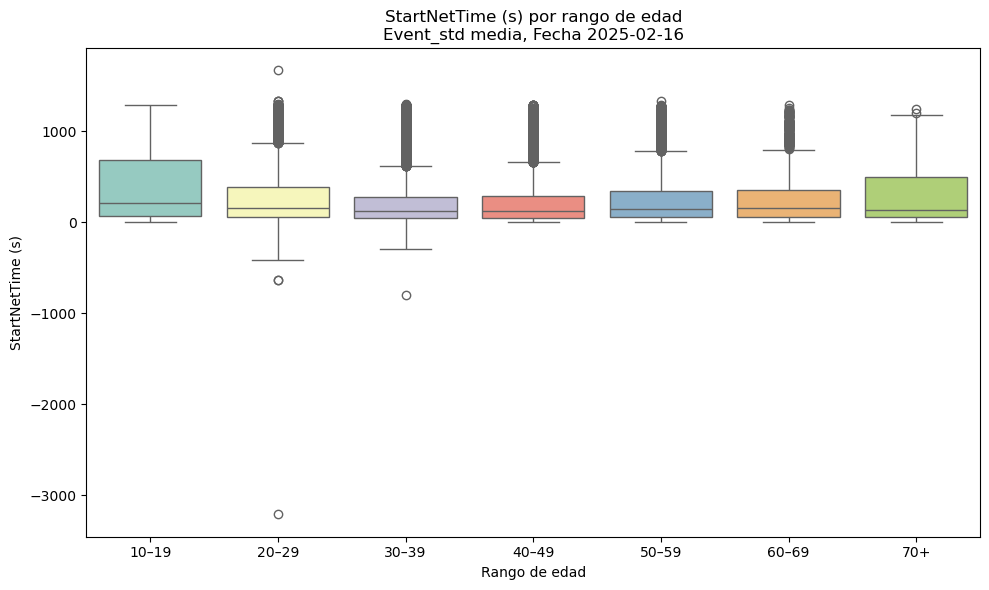

C:\Users\mario\AppData\Local\Temp\ipykernel_8032\1004051933.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


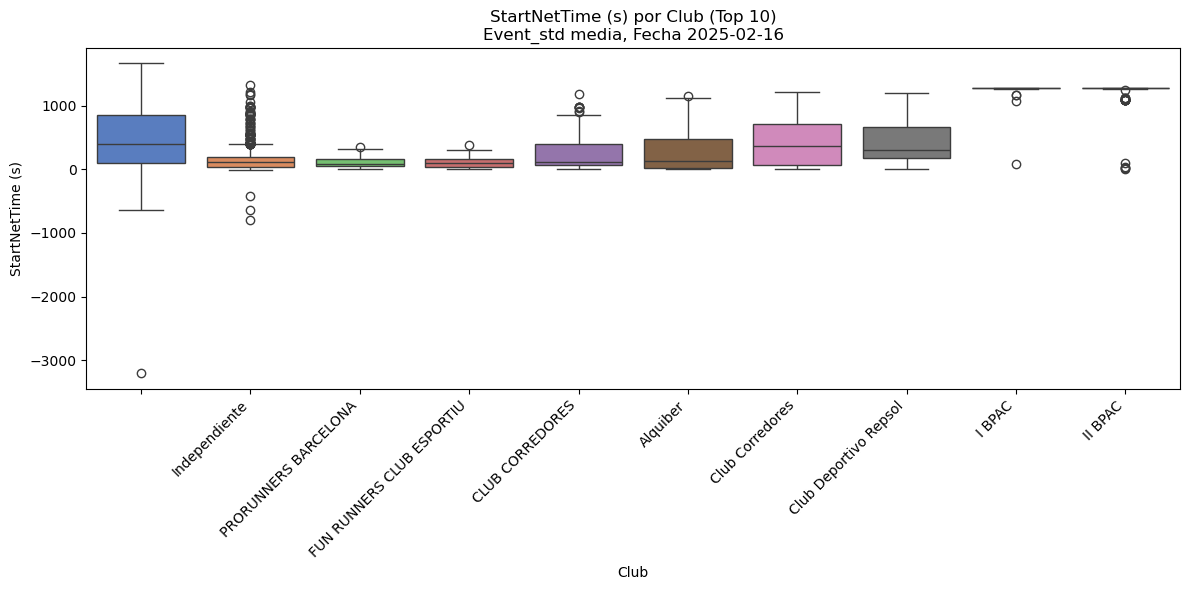

C:\Users\mario\AppData\Local\Temp\ipykernel_8032\1004051933.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


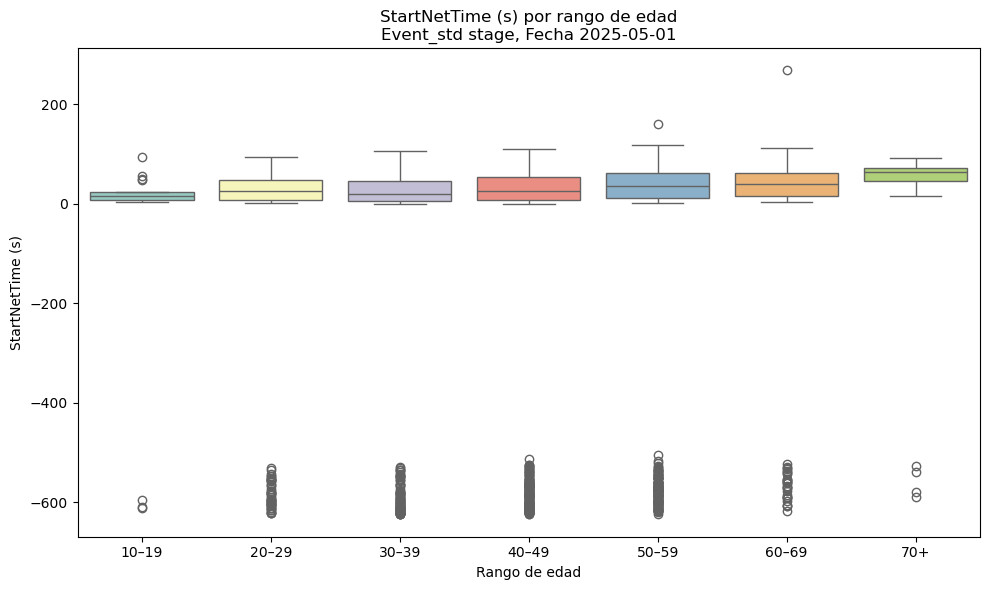

C:\Users\mario\AppData\Local\Temp\ipykernel_8032\1004051933.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


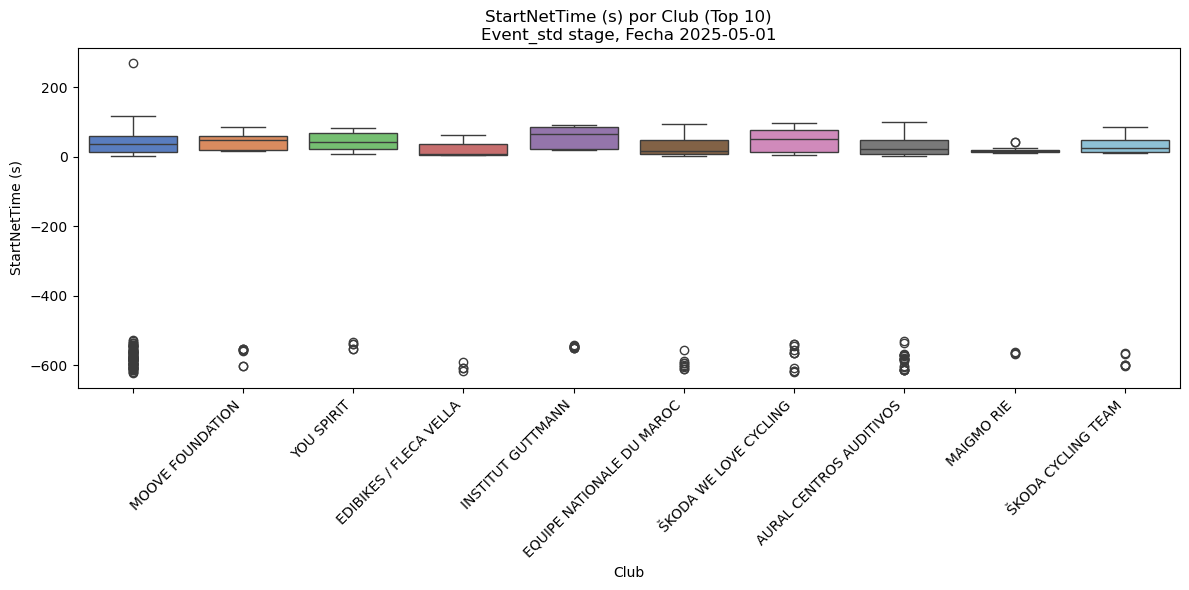

C:\Users\mario\AppData\Local\Temp\ipykernel_8032\1004051933.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


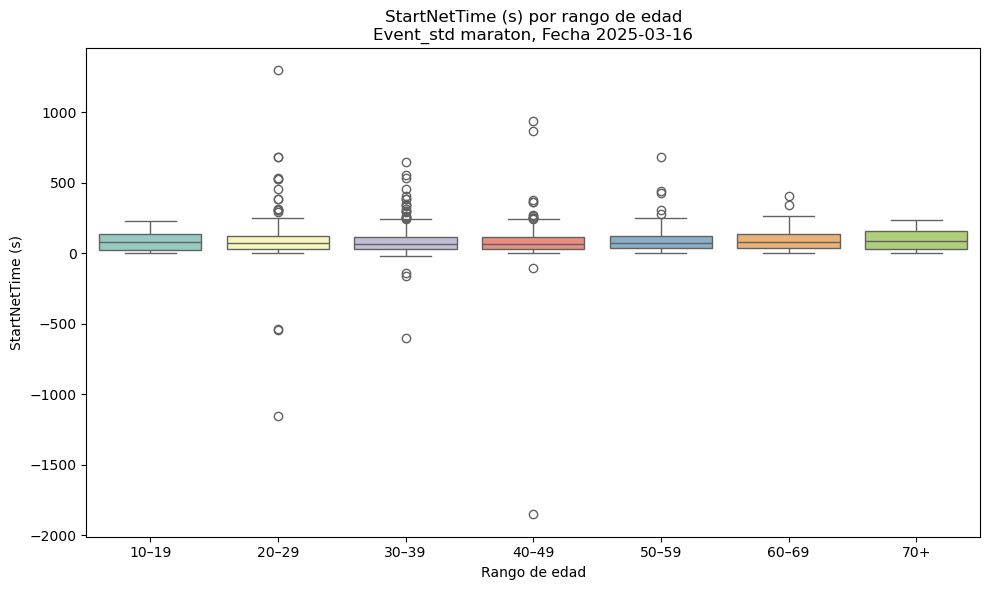

C:\Users\mario\AppData\Local\Temp\ipykernel_8032\1004051933.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


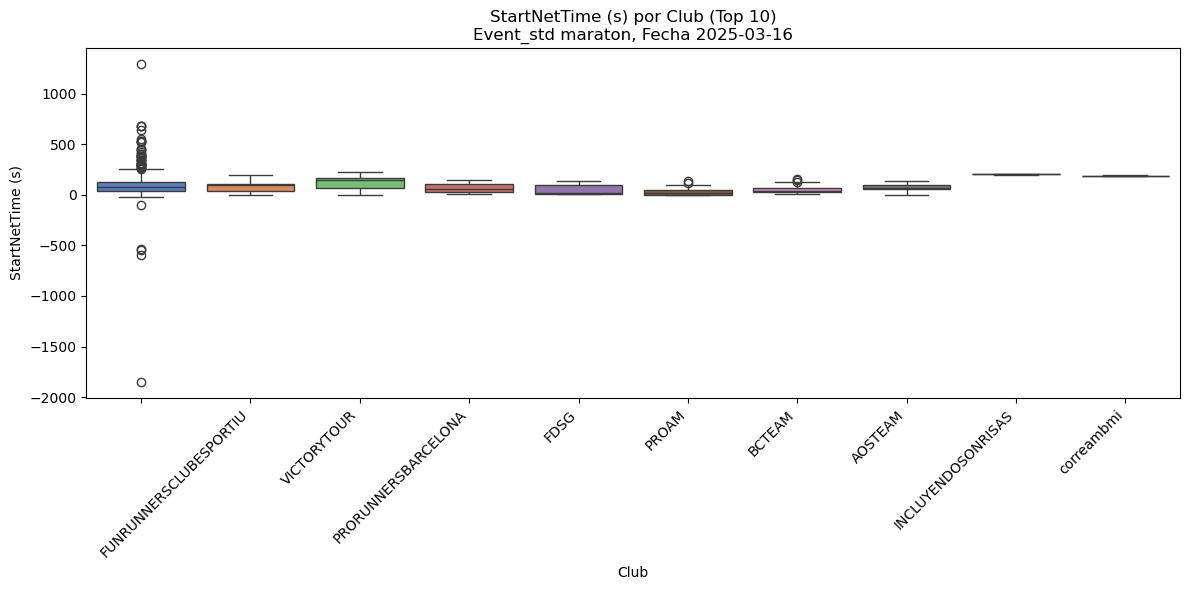

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ruta_graficos = os.path.join(ruta_base, "graficos_startNetTime")
os.makedirs(ruta_graficos, exist_ok=True)

merge_analisis = athletes_events_df.merge(
    athletes_df[['athlete_id', 'birthdate', 'club']],
    on='athlete_id',
    how='left'
).dropna(subset=['startRawTime', 'birthdate', 'club', 'event_std'])

for event_std in merge_analisis['event_std'].unique():
    df_event = merge_analisis[merge_analisis['event_std'] == event_std].copy()

    if len(df_event) < 100:
        print(f"event_std={event_std} tiene menos de 100 atletas. Saltando.")
        continue

    fecha_carrera = pd.to_datetime(df_event['startRawTime'].min().floor('D'))

    df_event['edad'] = (fecha_carrera - df_event['birthdate']).dt.days / 365.25
    df_event['edad'] = df_event['edad'].where(df_event['edad'].between(10, 100)).round(0)

    if 'startNetTime_td' in df_event.columns:
        df_event['startNetTime_td_sec'] = df_event['startNetTime_td'].dt.total_seconds()
    elif 'startNetTime' in df_event.columns:
        df_event['startNetTime_td_sec'] = df_event['startNetTime'] / 1000
    else:
        raise KeyError("No se encontró columna de startNetTime para convertir a segundos.")

    edad_bins = [10, 20, 30, 40, 50, 60, 70, 100]
    edad_labels = ['10–19','20–29','30–39','40–49','50–59','60–69','70+']
    df_event['rango_edad'] = pd.cut(df_event['edad'], bins=edad_bins, labels=edad_labels)
    df_event = df_event.dropna(subset=['rango_edad', 'startNetTime_td_sec', 'club'])
    df_event['rango_edad'] = df_event['rango_edad'].astype(str)

    ruta_event = os.path.join(ruta_graficos, f"event_{event_std}")
    os.makedirs(ruta_event, exist_ok=True)

    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=df_event,
        x='rango_edad',
        y='startNetTime_td_sec',
        palette='Set3',
        order=edad_labels
    )
    plt.title(f"StartNetTime (s) por rango de edad\nEvent_std {event_std}, Fecha {fecha_carrera.date()}")
    plt.xlabel("Rango de edad")
    plt.ylabel("StartNetTime (s)")
    plt.tight_layout()
    archivo_edad = os.path.join(ruta_event, f"boxplot_edad_event{event_std}.png")
    plt.savefig(archivo_edad)
    plt.show()

    top_clubs = df_event['club'].value_counts().head(10).index
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=df_event[df_event['club'].isin(top_clubs)],
        x='club',
        y='startNetTime_td_sec',
        palette='muted'
    )
    plt.title(f"StartNetTime (s) por Club (Top 10)\nEvent_std {event_std}, Fecha {fecha_carrera.date()}")
    plt.xlabel("Club")
    plt.ylabel("StartNetTime (s)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    archivo_club = os.path.join(ruta_event, f"boxplot_club_event{event_std}.png")
    plt.savefig(archivo_club)
    plt.show()

En este gráfico podemos observar como si hay valores de algunos atletas con valores negativos en salida, lo cuál podría indicar problemas en la misma y una posible intervención del cronometrador. 

En el siguiente código veremos el conteo de missings

In [ ]:
import pandas as pd
import os
import logging

logging.basicConfig(level=logging.INFO)

ruta_base = r"C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\reportes"
ruta_guardado = os.path.join(ruta_base, "splits_analysis")
os.makedirs(ruta_guardado, exist_ok=True)

df = athletes_events_df.dropna(subset=['event_std', 'splitsMissing']).copy()

# Iteramos por cada event_std
for event_std in df['event_std'].unique():
    df_event = df[df['event_std'] == event_std]
    
    # Contar por race_id
    resumen_list = []
    for race in df_event['race_id'].unique():
        df_race = df_event[df_event['race_id'] == race]
        total = len(df_race)
        conteo = df_race['splitsMissing'].value_counts().sort_index()
        pct = (conteo / total * 100).round(2)
        
        resumen = pd.DataFrame({
            'race_id': race,
            'splitsMissing': conteo.index,
            'count': conteo.values,
            'pct': pct.values
        })
        resumen_list.append(resumen)
    
    resumen_event = pd.concat(resumen_list, ignore_index=True)
    
    # Guardar CSV
    nombre_csv = f"splits_missing_event_{event_std}.csv"
    resumen_event.to_csv(os.path.join(ruta_guardado, nombre_csv), index=False)
    logging.info(f"Resumen guardado en: {nombre_csv}")
    
    # Detectar cambios significativos entre carreras (desviaciones grandes en %)
    median_pct = resumen_event.groupby('splitsMissing')['pct'].median()
    for race in df_event['race_id'].unique():
        df_race = resumen_event[resumen_event['race_id'] == race]
        # desviación máxima de la mediana
        max_diff = (df_race.set_index('splitsMissing')['pct'] - median_pct).abs().max()
        if max_diff > 10:  # umbral arbitrario, 10% de diferencia
            print(f"Race {race} para event_std={event_std} tiene distribución de splitsMissing significativamente distinta.")

INFO: Resumen guardado en: splits_missing_event_media.csv
INFO: Resumen guardado en: splits_missing_event_stage.csv
INFO: Resumen guardado en: splits_missing_event_maraton.csv


### Splismissing, last_split_seen...

In [41]:
athletes_events_df.columns

Index(['athlete_id', 'auto_category', 'auto_chip', 'category', 'distance',
       'dorsal', 'event_id', 'gunTime', 'gunTimeMode',
       'gunTimeModeConfig_wave', 'last_split_seen',
       'maxConsecutiveSplitsMissing', 'race_id', 'realStatus', 'splitsMissing',
       'splitsSeen', 'startNetTime', 'startRawTime', 'startTime', 'status',
       'team', 'event_std', 'startNetTime_td', 'startTime_td'],
      dtype='object')

In [49]:
df = dfs_final['athletes_events_df'].copy()

max_splits_map = {
    'maraton': 11,  
    'media': 6      
}

df['max_splits'] = df['event_std'].map(max_splits_map)

mask_total_splits = (df['splitsSeen'] + df['splitsMissing']) > df['max_splits']
mask_max_consec = df['maxConsecutiveSplitsMissing'] > df['splitsMissing']
mask_last_split = (df['splitsSeen'] == df['max_splits']) & (df['last_split_seen'] != 'Meta')

errores = df[mask_total_splits | mask_max_consec | mask_last_split].copy()

print(f"TOTAL filas con inconsistencias: {len(errores)}")
if not errores.empty:
    print(errores[['athlete_id','race_id','event_id',
                   'splitsSeen','splitsMissing','maxConsecutiveSplitsMissing',
                   'max_splits','last_split_seen']].head(20))


TOTAL filas con inconsistencias: 0


### Nivel Atleta (Tiempos)

- Anomalías por reglas para las variables temporales más importantes. 
- Boxplots e histogramas de tiempos netos por split y velocidades medias por split
- Análisis de backups y datos válidos

In [21]:
athletes_time_df = dfs['athletes_time_df']

df = athletes_time_df.copy()

df['netTime_sec'] = df['netTime_td'].dt.total_seconds()

df = df.sort_values(['athlete_id', 'race_id', 'event_id', 'netTime_sec'])

df['prev_netTime'] = df.groupby(['athlete_id', 'race_id', 'event_id'])['netTime_sec'].shift(1)
df['prev_split'] = df.groupby(['athlete_id', 'race_id', 'event_id'])['split'].shift(1)

df['first_split'] = df.groupby(['athlete_id', 'race_id', 'event_id']).cumcount() == 0

df['time_split_sec'] = 0.0
df.loc[df['split'] == 'Salida', 'time_split_sec'] = 0.0

mask_first = df['first_split'] & (df['split'] != 'Salida')
df.loc[mask_first, 'time_split_sec'] = df.loc[mask_first, 'netTime_sec']

mask_rest = ~df['first_split'] & (df['split'] != 'Salida')
df.loc[mask_rest, 'time_split_sec'] = df.loc[mask_rest, 'netTime_sec'] - df.loc[mask_rest, 'prev_netTime']

athletes_time_df['time_split_sec'] = df['time_split_sec']
athletes_time_df['prev_split'] = df['prev_split']

negativos = df[df['time_split_sec'] < 0]
display(negativos[['athlete_id','race_id','event_id','prev_split','split','netTime_td','time_split_sec']])

,athlete_id,race_id,event_id,prev_split,split,netTime_td,time_split_sec


In [10]:
resultados_normalidad = test_normalidad(df, 'time_split_sec', group_col=['event_id', 'race_id', 'split'])
print(resultados_normalidad.head(10))

c:\Users\mario\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:2248: RuntimeWarning: invalid value encountered in divide
  w = (y - xbar) / s
c:\Users\mario\anaconda3\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2071: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\Users\mario\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


       n  shapiro_stat  shapiro_p  dagostino_stat  dagostino_p  anderson_stat  \
0  22435           NaN        NaN    13196.154278          0.0     375.659795   
1  22349           NaN        NaN    19512.488072          0.0     307.361985   
2  22393           NaN        NaN    27231.111559          0.0     762.571181   
3  22158           NaN        NaN    40586.146462          0.0    1151.539635   
4  21838           NaN        NaN    31222.185109          0.0     909.158135   
5  21797           NaN        NaN    30563.392508          0.0    1018.412260   
6  21804           NaN        NaN    31582.256696          0.0     733.365241   
7  22323           NaN        NaN     5136.369333          0.0      14.795253   
8  22404           NaN        NaN    51738.518598          0.0    4262.572713   
9  22018           NaN        NaN    44760.530359          0.0    4755.755793   

   anderson_normal_5%   ks_stat           ks_p normal_shapiro  \
0               False  0.087955  1.846496e-

In [11]:
resultados_normalidad = test_normalidad(df, 'time_split_sec', group_col=['event_id', 'race_id', 'split'], transform='sqrt')
print(resultados_normalidad.head(10))

c:\Users\mario\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:2248: RuntimeWarning: invalid value encountered in divide
  w = (y - xbar) / s
c:\Users\mario\anaconda3\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2071: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\Users\mario\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


       n  shapiro_stat  shapiro_p  dagostino_stat  dagostino_p  anderson_stat  \
0  22435           NaN        NaN     7466.884086          0.0     183.859496   
1  22349           NaN        NaN    10018.776173          0.0     122.380956   
2  22393           NaN        NaN    16130.206093          0.0     299.667146   
3  22158           NaN        NaN    23142.662384          0.0     328.915593   
4  21838           NaN        NaN    17462.922882          0.0     320.614819   
5  21797           NaN        NaN    17165.996839          0.0     374.666901   
6  21804           NaN        NaN    15466.819765          0.0     224.656942   
7  22323           NaN        NaN     1609.359329          0.0      18.446944   
8  22404           NaN        NaN    38138.634398          0.0    1499.527886   
9  22018           NaN        NaN    32650.634236          0.0    2135.898448   

   anderson_normal_5%   ks_stat           ks_p normal_shapiro  \
0               False  0.064018   2.231902e

#### time_sec_split 

In [22]:
import os
import pandas as pd
import numpy as np
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
from Levenshtein import distance as levenshtein_distance
from collections import deque

ruta_base = r"C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\reportes"

df_times = athletes_time_df.copy()
df_times['netTime_sec'] = df_times['netTime_td'].dt.total_seconds()
df_times['time_sec'] = df_times['time_td'].dt.total_seconds()

df_times['speed_m_per_s'] = np.where(df_times['average'] > 0, 1 / df_times['average'], np.nan)
df_times['speed_flag'] = df_times['speed_m_per_s'] > 7  

def detect_anomalies(df):
    df['z_score'] = df.groupby('split')['netTime_sec'].transform(lambda x: zscore(x, nan_policy='omit'))
    df['outlier_z'] = df['z_score'].abs() > 3

    def outlier_iqr(x):
        q1, q3 = np.nanpercentile(x, [25, 75])
        iqr = q3 - q1
        lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        return (x < lower) | (x > upper)

    df['outlier_iqr'] = df.groupby('split')['netTime_sec'].transform(outlier_iqr)
    df['outlier_flag'] = df['outlier_z'] & df['outlier_iqr']

    df['anomaly_type'] = np.select(
        [
            df['speed_flag'] & df['outlier_flag'],
            df['speed_flag'],
            df['outlier_flag']
        ],
        [
            'Ambas (velocidad y tiempo)',
            'Velocidad imposible',
            'Outlier de tiempo'
        ],
        default='Normal'
    )
    return df

def group_events(event_list, max_dist=1):
    remaining = set(event_list)
    groups = []

    while remaining:
        start = remaining.pop()
        group = {start}
        queue = deque([start])
        while queue:
            current = queue.popleft()
            for other in list(remaining):
                if levenshtein_distance(current, other) <= max_dist:
                    group.add(other)
                    queue.append(other)
                    remaining.remove(other)
        groups.append(list(group))
    return groups

ORDER_MARATON = ['5K','10K','15K','19K','20K','Media','25K','30K','35K','40K','Meta']
order_index = {s: i for i, s in enumerate(ORDER_MARATON)}

def check_time_order(df_race, race, event_group):
    df_valid = df_race[df_race['split'].isin(ORDER_MARATON)]
    df_valid = df_valid.sort_values(
        ['athlete_id','event_id','split'],
        key=lambda col: col.map(order_index).fillna(999)
    )

    for athlete, df_a in df_valid.groupby(['athlete_id']):

        times = df_a.set_index('split')['netTime_sec']

        for s1, s2 in zip(ORDER_MARATON, ORDER_MARATON[1:]):
            if s1 in times and s2 in times:
                if times[s2] < times[s1]:
                    print(
                        f"ORDEN INCORRECTO | Carrera {race} | Evento(s): {event_group} | "
                        f"Athlete {athlete} | {s1} → {s2} ({times[s1]}s > {times[s2]}s)"
                    )

for race in df_times['race_id'].unique():

    race_folder = os.path.join(ruta_base, f"race_{race}")
    os.makedirs(race_folder, exist_ok=True)

    df_race = df_times[df_times['race_id'] == race].copy()
    df_race = detect_anomalies(df_race)

    eventos = df_race['event_id'].unique().tolist()
    grupos_eventos = group_events(eventos, max_dist=1)

    txt_path = os.path.join(race_folder, "anomalias.txt")
    txt_file = open(txt_path, "w", encoding="utf-8")


    for grupo in grupos_eventos:

        df_plot = df_race[df_race['event_id'].isin(grupo)].copy()
        nombre_comun = " & ".join(grupo)
        df_plot['event_group'] = nombre_comun

        if df_race['event_std'].iloc[0] != "stage":
            check_time_order(df_plot, race, nombre_comun)

        plt.figure(figsize=(10,6))
        if len(grupo) > 1:
            sns.boxplot(data=df_plot, x='split', y='netTime_sec', hue='event_id')
            plt.legend(title='Evento')
        else:
            sns.boxplot(data=df_plot, x='split', y='netTime_sec')
            plt.legend([], [], frameon=False)

        plt.title(f"Tiempos netos por split – Carrera {race} – Evento(s): {nombre_comun}")
        plt.xticks(rotation=45)
        plt.tight_layout()

        safe_name = nombre_comun.replace(" ", "_").replace("&", "_")
        plot_path = os.path.join(race_folder, f"boxplot_{safe_name}.png")
        plt.savefig(plot_path)
        plt.close()

        df_anom = df_plot[df_plot['anomaly_type'] != 'Normal']
        if not df_anom.empty:
            txt_file.write(f"\n=== Evento(s): {nombre_comun} ===\n")
            txt_file.write(df_anom[['athlete_id','split','netTime_sec','anomaly_type']].to_string())
            txt_file.write("\n")

    txt_file.close()

ORDEN INCORRECTO | Carrera 49603c2f-1b2b-457f-b82e-fed8bded1d3d | Evento(s): Marato | Athlete ('649B1971',) | 30K → 35K (15262.0s > 9492.0s)


Podemos ver como e tiempo se ve incrementado con respecto van pasando las etapas del evento, como es normal por otro lado. 

#### outliers time_sec_split

In [23]:
import os
import pandas as pd
import numpy as np

os.makedirs(ruta_base, exist_ok=True)

df = athletes_time_df.copy()

if 'time_split_sec' not in df.columns:
    raise KeyError("No existe la columna 'time_split_sec'. Debe calcularse antes.")

df = df.merge(
    athletes_df[['athlete_id', 'birthdate', 'club']],
    on='athlete_id',
    how='left'
)

df['birthdate'] = pd.to_datetime(df['birthdate'], errors='coerce')
df['rawTime'] = pd.to_datetime(df['rawTime'], errors='coerce')
df = df.dropna(subset=['birthdate', 'rawTime'])
df = df.sort_values(['athlete_id', 'race_id', 'event_id', 'split'])

edad_bins = [10, 20, 30, 40, 50, 60, 70, 100]
edad_labels = ['10–19','20–29','30–39','40–49','50–59','60–69','70+']

for race in df['race_id'].unique():
    df_race = df[df['race_id'] == race]

    race_folder = os.path.join(ruta_base, f"race_{race}")
    os.makedirs(race_folder, exist_ok=True)
    
    txt_path = os.path.join(race_folder, "outliers_time_split.txt")
    with open(txt_path, "w", encoding="utf-8") as txt_file:

        for event in df_race['event_id'].unique():
            df_event = df_race[df_race['event_id'] == event].copy()
            splits = sorted(df_event['split'].unique())
            
            if len(df_event) < 50:
                print(f"⚠ Carrera {race}, Evento {event} tiene menos de 50 atletas. Saltando análisis.")
                txt_file.write(f"race_id={race}, event_id={event} tiene pocos registros. Saltando análisis.\n")
                continue

            fecha_evento = pd.to_datetime(df_event['rawTime'].min(), errors='coerce')
            if pd.isna(fecha_evento):
                fecha_evento = pd.Timestamp.now()

            df_event['edad'] = (fecha_evento - df_event['birthdate']).dt.days / 365.25
            df_event['edad'] = df_event['edad'].where(df_event['edad'].between(10, 100)).round(0)
            df_event['rango_edad'] = pd.cut(df_event['edad'], bins=edad_bins, labels=edad_labels)
            df_event = df_event.dropna(subset=['rango_edad', 'time_split_sec', 'club'])

            for sp in splits:
                split_data = df_event[df_event['split'] == sp]['time_split_sec'].dropna()
                
                if len(split_data) == 0 or sp == 'Salida':
                    continue
                
                if len(split_data) < 50:
                    print(f"Carrera {race}, Evento {event}, Split {sp} tiene menos de 50 atletas.")
                
                q1, q3 = np.percentile(split_data, [25, 75])
                iqr = q3 - q1
                lower_bound = max(q1 - 1.5 * iqr, np.percentile(split_data, 1))
                upper_bound = min(q3 + 1.5 * iqr, np.percentile(split_data, 99))

                outliers = df_event[
                    (df_event['split'] == sp) &
                    ((df_event['time_split_sec'] < lower_bound) | (df_event['time_split_sec'] > upper_bound))
                ]

                if not outliers.empty:
                    txt_file.write(f"\n=== Carrera {race}, Evento {event}, Split {sp} ===\n")
                    txt_file.write(outliers[['athlete_id', 'club', 'edad', 'time_split_sec']].to_string())
                    txt_file.write("\n")

#### graficos time_sec_split

In [24]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ruta_base = r"C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\reportes"
os.makedirs(ruta_base, exist_ok=True)

df = athletes_time_df.copy()

if 'time_split_sec' not in df.columns:
    raise KeyError("No existe la columna 'time_split_sec'. Debe calcularse antes.")

for event_std in df['event_std'].unique():
    df_event_std = df[df['event_std'] == event_std].copy()

    folder_event = os.path.join(ruta_base, f"{event_std}")
    os.makedirs(folder_event, exist_ok=True)

    split_order = (
        df_event_std[df_event_std['split'] != 'Salida']
        .groupby('split')['netTime']
        .mean()
        .sort_values()
        .index
    )

    plt.figure(figsize=(12,6))
    sns.boxplot(
        data=df_event_std[df_event_std['split'] != 'Salida'],
        x='split',
        y='time_split_sec',
        palette='Set2',
        order=split_order
    )
    plt.title(f'Distribución de tiempos por split – Event_std: {event_std}')
    plt.xlabel('Split')
    plt.ylabel('Tiempo por split (s)')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plot_path = os.path.join(folder_event, f"boxplot_{event_std}.png")
    plt.savefig(plot_path)
    plt.close()

C:\Users\mario\AppData\Local\Temp\ipykernel_14896\3007677422.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\mario\AppData\Local\Temp\ipykernel_14896\3007677422.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\mario\AppData\Local\Temp\ipykernel_14896\3007677422.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


#### Velocidad

In [ ]:
import os
import pandas as pd
import numpy as np

os.makedirs(ruta_base, exist_ok=True)

df = athletes_time_df.copy()

if 'average' not in df.columns:
    raise KeyError("No existe la columna 'average'. Debe calcularse antes.")

df['speed_m_per_s'] = 1 / df['average']

df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['speed_m_per_s'])

for race in df['race_id'].unique():
    df_race = df[df['race_id'] == race]

    race_folder = os.path.join(ruta_base, f"race_{race}")
    os.makedirs(race_folder, exist_ok=True)

    for event in df_race['event_id'].unique():
        df_event = df_race[df_race['event_id'] == event].copy()
        if df_event.empty:
            continue

        txt_path = os.path.join(race_folder, f"outliers_speed_{event.replace(' ', '_')}.txt")
        with open(txt_path, "w", encoding="utf-8") as txt_file:

            for athlete, df_a in df_event.groupby('athlete_id'):
                speeds = df_a['speed_m_per_s'].dropna()

                if len(speeds) < 2:
                    continue  

                q1, q3 = np.percentile(speeds, [25, 75])
                iqr = q3 - q1
                lower = q1 - 3 * iqr
                upper = q3 + 3 * iqr

                outliers_individual = df_a[(df_a['speed_m_per_s'] < lower) | (df_a['speed_m_per_s'] > upper)]
                if not outliers_individual.empty:
                    txt_file.write(f"\n=== Carrera {race}, Evento {event}, Athlete {athlete} (propio ritmo) ===\n")
                    txt_file.write(outliers_individual[['split', 'average', 'speed_m_per_s']].to_string())
                    txt_file.write("\n")

            for split, df_s in df_event.groupby('split'):
                speeds_split = df_s['speed_m_per_s'].dropna()
                if len(speeds_split) < 2:
                    continue

                q1, q3 = np.percentile(speeds_split, [25, 75])
                iqr = q3 - q1
                lower = q1 - 3 * iqr
                upper = q3 + 3 * iqr

                outliers_group = df_s[(df_s['speed_m_per_s'] < lower) | (df_s['speed_m_per_s'] > upper)]
                if not outliers_group.empty:
                    txt_file.write(f"\n=== Carrera {race}, Evento {event}, Split {split} (comparado con grupo) ===\n")
                    txt_file.write(outliers_group[['athlete_id', 'average', 'speed_m_per_s']].to_string())
                    txt_file.write("\n")

#### Consistencia valocidad-tiempo-distancia

In [ ]:
df = dfs_final["athletes_time_df"].copy()

df['speed_m_per_s'] = 1 / df['average']
distance = df["distance"].astype(float)
df['netTime_sec'] = df['netTime_td'].dt.total_seconds()

df["speed_calc"] = df["distance"] / df["time_split_sec"]

df["speed_rel_error"] = abs(df["speed_calc"] - df["speed_m_per_s"]) / df["speed_m_per_s"]

tolerancia = 0.03
inconsistentes = df[df["speed_rel_error"] > tolerancia]

print("TOTAL filas:", len(df))
print("Inconsistentes:", len(inconsistentes), f"(>{tolerancia*100:.1f}% de error relativo)\n")

if len(inconsistentes) > 0:
    print("=== EJEMPLOS DE INCONSISTENCIAS ===")
    print(
        inconsistentes[
            ["athlete_id","race_id","event_id","split",
             "distance","netTime_sec","speed_m_per_s","speed_calc","speed_rel_error"]
        ].head(20)
    )

TOTAL filas: 550065
Inconsistentes: 454172 (>3.0% de error relativo)

=== EJEMPLOS DE INCONSISTENCIAS ===
   athlete_id                               race_id event_id split  distance  \
4         159  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja   10K   10000.0   
5         159  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja   15K   15000.0   
6         159  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja   20K   20000.0   
7         159  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  Meta   21097.0   
10        160  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja   10K   10000.0   
11        160  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja   15K   15000.0   
12        160  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja   20K   20000.0   
13        160  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja  Meta   21097.0   
16        191  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja   10K   10000.0   
17        191  b228b93e-2a15-4123-baf9-ca0915165c6a    Mitja   15K   15000.0   
18        191 

In [35]:
athletes_time_df["netTime"].head(5)

0          0.0
1     891230.0
2          0.0
3    1081165.0
4    2156349.0
Name: netTime, dtype: float64

### Relaciones

In [ ]:
def analizar_relaciones(
    athletes_df,
    athletes_events_df,
    athletes_time_df,
    alpha=0.05,
    race_id=None,      
    event_std=None, 
    ruta_base=None     
):
    import numpy as np
    import pandas as pd
    from scipy import stats
    import os

    if ruta_base is None:
        ruta_base = os.getcwd()
    os.makedirs(ruta_base, exist_ok=True)
    log_path = os.path.join(ruta_base, "analisis_tests_log.txt")
    log_messages = []

    results = []

    athletes_df['gender'] = athletes_df['gender'].astype(str).str.lower().str.strip()
    gender_map = {
        'h':'male','m':'female','hombre':'male','mujer':'female',
        'masculino':'male','femenino':'female','male':'male','female':'female'
    }
    athletes_df['gender'] = athletes_df['gender'].map(gender_map)
    athletes_df = athletes_df[athletes_df['gender'].isin(['male','female'])]

    df_eventos = athletes_events_df.merge(
        athletes_df[['athlete_id','birthdate','gender','club']],
        on='athlete_id', how='left'
    )
    df_eventos['fecha_evento'] = pd.to_datetime(
        df_eventos.get('rawTime', df_eventos.get('startTime', pd.Timestamp.now())),
        errors='coerce'
    )
    df_eventos['birthdate'] = pd.to_datetime(df_eventos['birthdate'], errors='coerce')
    df_eventos['edad'] = (df_eventos['fecha_evento'] - df_eventos['birthdate']).dt.days / 365.25

    df_splits = athletes_time_df.merge(
        athletes_df[['athlete_id','birthdate','gender','club']],
        on='athlete_id', how='left'
    ).merge(
        athletes_events_df[['athlete_id','race_id','event_id','category']],
        on=['athlete_id','race_id','event_id'], how='left'
    )
    df_splits['fecha_evento'] = pd.to_datetime(
        df_splits.get('rawTime', df_splits.get('datetime', pd.Timestamp.now())),
        errors='coerce'
    )
    df_splits['birthdate'] = pd.to_datetime(df_splits['birthdate'], errors='coerce')
    df_splits['edad'] = (df_splits['fecha_evento'] - df_splits['birthdate']).dt.days / 365.25
    df_splits['velocidad'] = np.where(df_splits.get('average', 0) > 0, 1/df_splits['average'], np.nan)

    if race_id is not None:
        df_eventos = df_eventos[df_eventos['race_id'] == race_id]
        df_splits = df_splits[df_splits['race_id'] == race_id]
    if event_std is not None:
        df_eventos = df_eventos[df_eventos['event_std'] == event_std]
        df_splits = df_splits[df_splits['event_std'] == event_std]

    def correr_test(df, variable, metric, test_name):
        df = df.dropna(subset=[variable, metric])
        race_val = df['race_id'].iloc[0] if 'race_id' in df.columns and len(df) > 0 else None
        event_val = df['event_id'].iloc[0] if 'event_id' in df.columns and len(df) > 0 else None
        split_val = df['split'].iloc[0] if 'split' in df.columns and len(df) > 0 else None

        df = df.dropna(subset=[variable, metric])
        if df.empty:
            msg = f"Race {race_val}, Event {event_val}, Split {split_val}: {metric} / {variable}: grupo vacío → no se calcula el test."
            print(msg)
            log_messages.append(msg)
            return None

        try:
            if test_name == "mannwhitney":
                grupos = df[variable].dropna().unique()
                if len(grupos) != 2:
                    msg = f"Race {race_val}, Event {event_val}, Split {split_val}: {metric} / {variable}: solo hay {len(grupos)} grupo(s) → no se calcula Mann-Whitney."
                    print(msg)
                    log_messages.append(msg)
                    return None
                stat, p = stats.mannwhitneyu(
                    df[df[variable]==grupos[0]][metric],
                    df[df[variable]==grupos[1]][metric],
                    alternative='two-sided'
                )
            elif test_name == "kruskal":
                if variable == "club":
                    group_sizes = df[variable].value_counts()
                    selected_groups = group_sizes[(group_sizes >= 5) & (group_sizes <= 10)].index
                    df_large = df[df[variable].isin(selected_groups)]
                    if len(df_large[variable].unique()) < 2:
                        msg = f"Race {race_val}, Event {event_val}, Split {split_val}: {metric} / {variable}: menos de 2 clubes con 5–10 atletas → no se calcula Kruskal."
                        print(msg)
                        log_messages.append(msg)
                        return None
                else:
                    group_sizes = df[variable].value_counts()
                    large_groups = group_sizes[group_sizes >= 5].index
                    df_large = df[df[variable].isin(large_groups)]
                    if len(df_large[variable].unique()) < 2:
                        msg = f"Race {race_val}, Event {event_val}, Split {split_val}: {metric} / {variable}: menos de 2 grupos grandes → no se calcula Kruskal."
                        print(msg)
                        log_messages.append(msg)
                        return None

                grupos = [g[metric].dropna() for _, g in df_large.groupby(variable)]
                stat, p = stats.kruskal(*grupos)
            elif test_name == "spearman":
                if df[variable].nunique() < 2:
                    msg = f"Race {race_val}, Event {event_val}, Split {split_val}: {metric} / {variable}: solo un valor único → no se calcula Spearman."
                    print(msg)
                    log_messages.append(msg)
                    return None
                stat, p = stats.spearmanr(df[variable], df[metric], nan_policy='omit')
            else:
                return None

            return dict(
                race_id=race_val,
                event_id=event_val,
                split=split_val,
                variable=variable,
                metric=metric,
                test=test_name,
                statistic=stat,
                p_value=p,
                significant=p < alpha,
                n=len(df),
                n_groups=df[variable].nunique()
            )
        except Exception:
            msg = f"Race {race_val}, Event {event_val}, Split {split_val}: Error calculando test {test_name} para {metric} / {variable}"
            print(msg)
            log_messages.append(msg)
            return None

    results = []
    for (race, event), df_group in df_eventos.groupby(['race_id','event_id']):
        for metric in ['startTime','netTime']:
            if metric not in df_group.columns:
                continue
            df_group[metric] = pd.to_numeric(df_group[metric], errors='coerce')
            for variable, test_name in [
                ('gender','mannwhitney'),
                ('club','kruskal'),
                ('category','kruskal'),
                ('edad','spearman')
            ]:
                r = correr_test(df_group, variable, metric, test_name)
                if r:
                    results.append(r)

    df_splits_filtered = df_splits[df_splits['split'] != 'Salida']
    for (race, event, split), df_group in df_splits_filtered.groupby(['race_id','event_id','split']):
        for metric_name in ['time_split_sec','velocidad']:
            if metric_name not in df_group.columns:
                continue
            df_group[metric_name] = pd.to_numeric(df_group[metric_name], errors='coerce')
            for variable, test_name in [
                ('gender','mannwhitney'),
                ('club','kruskal'),
                ('category','kruskal'),
                ('edad','spearman')
            ]:
                r = correr_test(df_group, variable, metric_name, test_name)
                if r:
                    results.append(r)

    with open(log_path, 'w', encoding='utf-8') as f:
        for msg in log_messages:
            f.write(msg + "\n")

    results_df = pd.DataFrame(results)
    if results_df.empty:
        print("No se obtuvieron resultados.")
        return None, None, df_eventos, df_splits

    summary_df = (
        results_df.groupby(['variable','metric'])['significant']
        .mean()
        .reset_index()
        .rename(columns={'significant':'prop_significant'})
        .sort_values('prop_significant', ascending=False)
    )

    print("\nAnálisis completado.")
    print(summary_df)

    return results_df, summary_df, df_eventos, df_splits


In [40]:
results_df, summary_df, df_eventos, df_splits = analizar_relaciones(
    athletes_df,
    athletes_events_df,
    athletes_time_df,
    alpha=0.05,
    race_id='49603c2f-1b2b-457f-b82e-fed8bded1d3d',
    event_std='maraton'
)

print(results_df[['race_id', 'event_id', 'split', 'variable', 'metric', 'significant', 'p_value']])


Análisis completado.
    variable          metric  prop_significant
0   category       startTime               1.0
1   category  time_split_sec               1.0
2   category       velocidad               1.0
3       club       startTime               1.0
4       club  time_split_sec               1.0
5       club       velocidad               1.0
7       edad  time_split_sec               1.0
8       edad       velocidad               1.0
9     gender       startTime               1.0
10    gender  time_split_sec               1.0
11    gender       velocidad               1.0
6       edad       startTime               0.0
                                 race_id event_id  split  variable  \
0   49603c2f-1b2b-457f-b82e-fed8bded1d3d   Marato   None    gender   
1   49603c2f-1b2b-457f-b82e-fed8bded1d3d   Marato   None      club   
2   49603c2f-1b2b-457f-b82e-fed8bded1d3d   Marato   None  category   
3   49603c2f-1b2b-457f-b82e-fed8bded1d3d   Marato   None      edad   
4   49603c2f-1b2b

#### Relacione smultivariantes

In [ ]:
import pandas as pd

athletes_info = athletes_df[['athlete_id', 'birthdate', 'gender', 'club']]

df_multi = athletes_time_df.merge(
    athletes_info,
    on='athlete_id',
    how='left' 
)

df_multi['birthdate'] = pd.to_datetime(df_multi['birthdate'], errors='coerce')

today = pd.Timestamp.today()
df_multi['edad'] = (today - df_multi['birthdate']).dt.days // 365

bins = [0, 17, 25, 35, 45, 55, 65, 120] 
labels = ['<18', '18-25', '26-35', '36-45', '46-55', '56-65', '65+']
df_multi['edad_grupo'] = pd.cut(df_multi['edad'], bins=bins, labels=labels, right=True)

df_multi['club'] = df_multi['club'].fillna("independiente")
df_multi['club'] = df_multi['club'].replace('', "independiente")

df_multi = df_multi[df_multi['birthdate'].notna() & df_multi['gender'].notna()].reset_index(drop=True)

print(df_multi.head())

In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

df_vif = df_multi[['gender', 'edad', 'club']].copy()
df_vif = df_vif.drop_duplicates()

N = 50  
top_clubs = df_vif['club'].value_counts().nlargest(N).index
df_vif['club'] = df_vif['club'].where(df_vif['club'].isin(top_clubs), 'Otros')

In [ ]:
conteo_clubes = df_vif['club'].value_counts()
print(conteo_clubes)

In [ ]:
df_vif_dummies = pd.get_dummies(df_vif, drop_first=True)
df_vif_dummies = df_vif_dummies.astype(int)

vif_data = pd.DataFrame()
vif_data["variable"] = df_vif_dummies.columns
vif_data["VIF"] = [variance_inflation_factor(df_vif_dummies.values, i)
                   for i in range(df_vif_dummies.shape[1])]

print(vif_data)

### Otras variables

In [18]:
athletes_time_df.columns

Index(['athlete_id', 'average', 'distance', 'event_id', 'incidence',
       'isBackup', 'netTime', 'offset', 'order', 'race_id', 'rawTime', 'split',
       'time', 'event_std', 'netTime_td', 'time_td'],
      dtype='object')

#### offset = isbackup?

In [ ]:
df = dfs_final['athletes_time_df']   

con_offset = df[df['offset'].notna() & (df['offset'] != 0)]

con_backup = df[df['isBackup'] == True]

offset_sin_backup = con_offset[con_offset['isBackup'] != True]

backup_sin_offset = con_backup[(con_backup['offset'].isna()) | (con_backup['offset'] == 0)]

print("=== RESUMEN DE CONSISTENCIA OFFSET ↔ IS_BACKUP ===\n")

print(f"Filas con offset ≠ 0: {len(con_offset)}")
print(f"Filas con isBackup = True: {len(con_backup)}")

print("\nOFFSET ≠ 0 PERO isBackup != True:", len(offset_sin_backup))
if len(offset_sin_backup) > 0:
    print(offset_sin_backup.head(20))

print("\nIS_BACKUP = True PERO offset es nulo o cero:", len(backup_sin_offset))
if len(backup_sin_offset) > 0:
    print(backup_sin_offset.head(20))

=== RESUMEN DE CONSISTENCIA OFFSET ↔ IS_BACKUP ===

Filas con offset ≠ 0: 708
Filas con isBackup = True: 708

OFFSET ≠ 0 PERO isBackup != True: 0

IS_BACKUP = True PERO offset es nulo o cero: 0


## Nivel issues 

Para los issues vamos a hacer transformaciones necesarias a los datos, pasando por crear columnas nuevas para identificar cuando ha sido el issue. Para ello pondremos el límite en 3 horas para la media maratón. 

In [110]:
import pandas as pd
import numpy as np

# --- Copiar dataframes ---
df = athletes_time_df.copy()      # split/raw times por atleta
events = athletes_events_df.copy()  # gunTime por atleta
issues = issues_df.copy()         # incidencias

# --- Normalizar a tz-naive ---
df['rawTime'] = pd.to_datetime(df['rawTime'], errors='coerce').dt.tz_localize(None)
events['gunTime'] = pd.to_datetime(events['gunTime'], errors='coerce').dt.tz_localize(None)
issues['time'] = pd.to_datetime(issues['time'], errors='coerce').dt.tz_localize(None)

# --- Calcular hora de inicio por carrera y evento ---
race_event_start = (
    events.groupby(['race_id','event_id'])['gunTime']
    .min()
    .rename('official_start')
    .reset_index()
)

# --- Calcular hora de fin por carrera y evento ---
# 1️⃣ Filtrar split Meta
meta_split = df[df['split'] == 'Meta'].copy()

# 2️⃣ Unir gunTime desde events
meta_split = meta_split.merge(
    events[['race_id','event_id','athlete_id','gunTime']],
    on=['race_id','event_id','athlete_id'],
    how='left'
)

# 3️⃣ Tiempo transcurrido hasta Meta
meta_split['time_to_meta'] = (meta_split['rawTime'] - meta_split['gunTime']).dt.total_seconds()

# 4️⃣ Oficial end = máximo tiempo hasta Meta por carrera y evento
race_event_end = (
    meta_split.groupby(['race_id','event_id'])['time_to_meta']
    .max()
    .rename('official_end_seconds')
    .reset_index()
)

# 5️⃣ Convertir official_end_seconds a timestamp absoluto
race_event_end = race_event_end.merge(
    race_event_start, on=['race_id','event_id'], how='left'
)
race_event_end['official_end'] = race_event_end['official_start'] + pd.to_timedelta(race_event_end['official_end_seconds'], unit='s')

# --- Combinar inicio y fin ---
race_bounds = race_event_start.merge(
    race_event_end[['race_id','event_id','official_end']], 
    on=['race_id','event_id'], 
    how='left'
)

# --- Combinar inicio y fin con issues ---
# Verifica qué columnas hay en race_bounds
print("Columnas en race_bounds:", race_bounds.columns.tolist())

# Merge seguro con issues
issues = issues.merge(
    race_bounds[['race_id','event_id','official_start','official_end']],
    on=['race_id','event_id'],
    how='left'
)

# --- Debug: verificar filas sin official_start ---
missing_start = issues[issues['official_start'].isna()]
print(f"⚠️ Filas sin official_start: {len(missing_start)}")
if len(missing_start) > 0:
    print(missing_start[['race_id','event_id']].drop_duplicates())

# --- Clasificación de fase temporal ---
def clasificar_fase(row):
    t = row['time']
    start = row['official_start']
    end = row['official_end']
    if pd.isna(t) or pd.isna(start) or pd.isna(end):
        return "desconocido"
    elif t < start:
        return "pre-carrera"
    elif start <= t <= end:
        return "en carrera"
    else:
        return "post-carrera"

issues['fase_temporal'] = issues.apply(clasificar_fase, axis=1)

# --- Comprobar resultado ---
print(issues[['race_id','event_id','time','fase_temporal']].head(10))

Columnas en race_bounds: ['race_id', 'event_id', 'official_start', 'official_end']


KeyError: 'official_start'

📊 Distribución total de tipos de incidencias:
type
changeRanking     228936
importAthletes    123862
changeStatus        1336
importSwap           562
athleteTime          289
athleteSwap          136
Name: count, dtype: int64

📊 Distribución de tipos – Carrera 1a83229e-2547-42a3-b5b4-36c7425c4d8f:
type
changeRanking     111979
importAthletes     61931
changeStatus         645
importSwap           281
athleteTime          116
athleteSwap           59
Name: count, dtype: int64


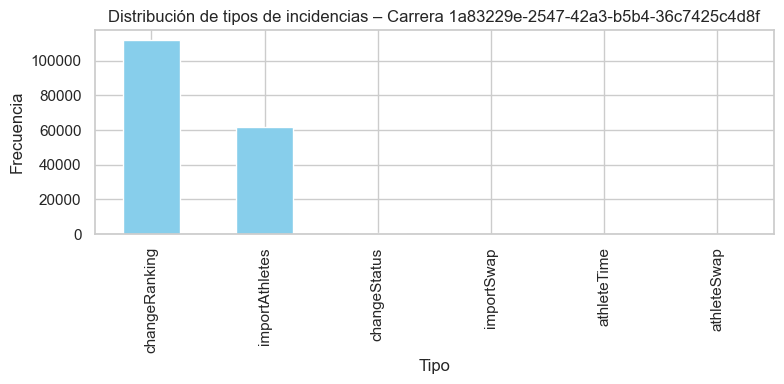

📅 Conteo diario – Carrera 1a83229e-2547-42a3-b5b4-36c7425c4d8f:
datetime
2025-02-11    36596
2025-02-12        0
2025-02-13        4
2025-02-14       15
2025-02-15    62271
2025-02-16    75511
2025-02-17       35
2025-02-18      140
2025-02-19       43
2025-02-20        6
2025-02-21        1
2025-02-22        0
2025-02-23        0
2025-02-24        0
2025-02-25        1
2025-02-26        0
2025-02-27        0
2025-02-28      105
2025-03-01        0
2025-03-02        1
2025-03-03        0
2025-03-04      183
2025-03-05        0
2025-03-06        0
2025-03-07        0
2025-03-08        0
2025-03-09        0
2025-03-10        0
2025-03-11       81
2025-03-12        0
2025-03-13       17
2025-03-14        0
2025-03-15        0
2025-03-16        0
2025-03-17        0
2025-03-18        0
2025-03-19        0
2025-03-20        0
2025-03-21        0
2025-03-22        0
2025-03-23        0
2025-03-24        0
2025-03-25        0
2025-03-26        0
2025-03-27        0
2025-03-28        0
2025-03

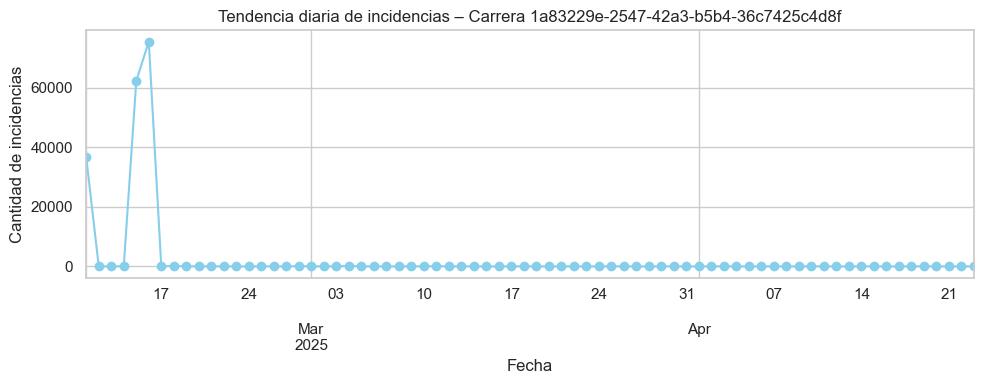


📊 Distribución de tipos – Carrera cf6f71f2-1235-45e3-802e-02833b71ae8b:
type
changeRanking    4978
athleteTime        57
changeStatus       46
athleteSwap        18
Name: count, dtype: int64


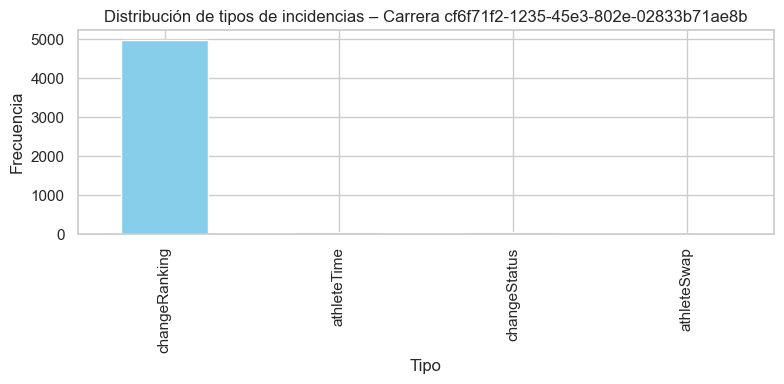

📅 Conteo diario – Carrera cf6f71f2-1235-45e3-802e-02833b71ae8b:
datetime
2025-04-25       4
2025-04-26       0
2025-04-27       0
2025-04-28     647
2025-04-29     268
2025-04-30      59
2025-05-01     648
2025-05-02    1052
2025-05-03     499
2025-05-04     514
2025-05-05     492
2025-05-06     916
Freq: D, Name: id, dtype: int64


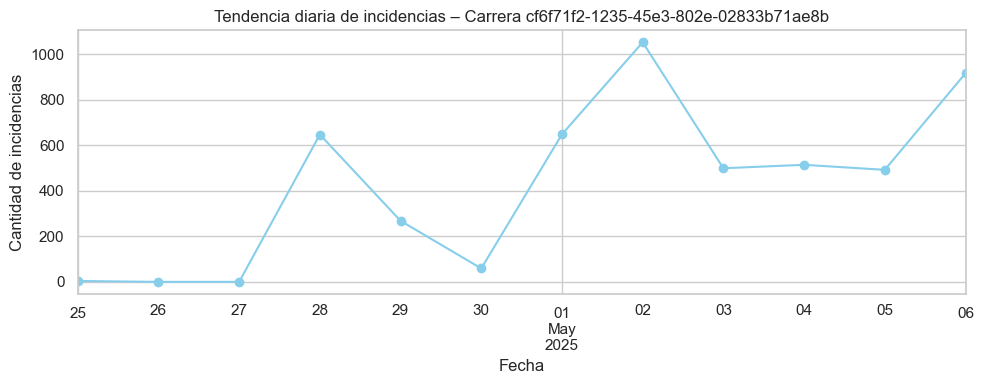


📊 Distribución de tipos – Carrera 331e7589-6440-4968-9b44-484ba589824e:
type
changeRanking     111979
importAthletes     61931
changeStatus         645
importSwap           281
athleteTime          116
athleteSwap           59
Name: count, dtype: int64


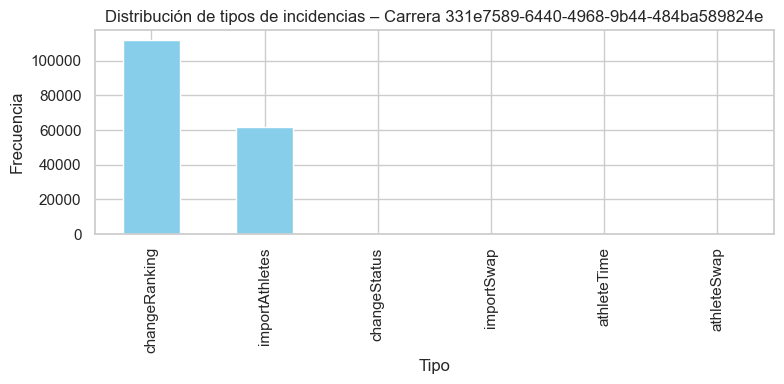

📅 Conteo diario – Carrera 331e7589-6440-4968-9b44-484ba589824e:
datetime
2025-02-11    36596
2025-02-12        0
2025-02-13        4
2025-02-14       15
2025-02-15    62271
2025-02-16    75511
2025-02-17       35
2025-02-18      140
2025-02-19       43
2025-02-20        6
2025-02-21        1
2025-02-22        0
2025-02-23        0
2025-02-24        0
2025-02-25        1
2025-02-26        0
2025-02-27        0
2025-02-28      105
2025-03-01        0
2025-03-02        1
2025-03-03        0
2025-03-04      183
2025-03-05        0
2025-03-06        0
2025-03-07        0
2025-03-08        0
2025-03-09        0
2025-03-10        0
2025-03-11       81
2025-03-12        0
2025-03-13       17
2025-03-14        0
2025-03-15        0
2025-03-16        0
2025-03-17        0
2025-03-18        0
2025-03-19        0
2025-03-20        0
2025-03-21        0
2025-03-22        0
2025-03-23        0
2025-03-24        0
2025-03-25        0
2025-03-26        0
2025-03-27        0
2025-03-28        0
2025-03

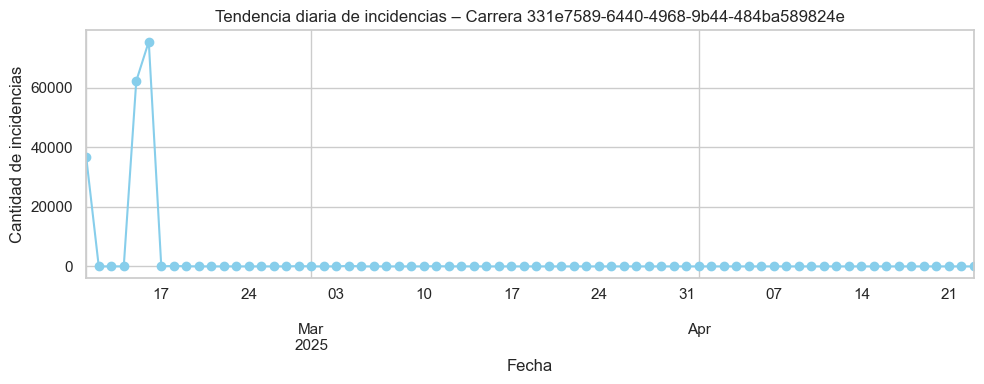

In [79]:
# --- Conteo total de tipos (solo tabla, no gráfico) ---
type_counts_total = issues_df['type'].value_counts().sort_values(ascending=False)
print("📊 Distribución total de tipos de incidencias:")
print(type_counts_total)

# --- Distribución y tendencia por carrera ---
for race in issues_df['race_id'].unique():
    df_race = issues_df[issues_df['race_id'] == race]
    
    # Tipos de incidencias
    type_counts = df_race['type'].value_counts().sort_values(ascending=False)
    print(f"\n📊 Distribución de tipos – Carrera {race}:")
    print(type_counts)
    
    plt.figure(figsize=(8,4))
    type_counts.plot(kind='bar', color='skyblue')
    plt.title(f"Distribución de tipos de incidencias – Carrera {race}")
    plt.xlabel("Tipo")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()
    
    # Conteo diario
    incidencias_diarias = df_race.set_index('datetime')['id'].resample('1D').count()
    print(f"📅 Conteo diario – Carrera {race}:")
    print(incidencias_diarias)
    
    plt.figure(figsize=(10,4))
    incidencias_diarias.plot(marker='o', color='skyblue')
    plt.title(f"Tendencia diaria de incidencias – Carrera {race}")
    plt.xlabel("Fecha")
    plt.ylabel("Cantidad de incidencias")
    plt.tight_layout()
    plt.show()

Podemos ver de forma sencilla la mayoría de incidencias se realizan los dias previos y el dia de carrera, y por otro lado los días posteriores a la misma se arreglan errores muy esporádicos pero muy extendidos en el tiempo. El último día que se arregla un error es el 23 de abril, casi 1 mes y medio después de haber terminado la carrera.

Por otro lado vemos que la mayoría de los errores que se cometen son de lña categoría changeRanking e importathletes, lógico al ser una de las categorías más generales, al igual que importathletes en al que se importan los datos de los atletas. 

In [105]:
import pandas as pd

# --- Filtrar incidencias de tipo 'athleteSwap' ---
swap_issues = issues_df[issues_df["type"].str.lower() == "athleteswap"].copy()

print(f"🔄 Total de incidencias 'athleteSwap': {len(swap_issues)}\n")

# --- Asegurar columna datetime ---
if "datetime" not in swap_issues.columns and "time" in swap_issues.columns:
    swap_issues["datetime"] = pd.to_datetime(
        swap_issues["time"], unit="ms", errors="coerce"
    )

# --- Mostrar ejemplos ---
cols_presentes = [c for c in ["id", "race_id", "event_id", "athlete_id", "time", "datetime", "fase_temporal"] if c in swap_issues.columns]

if len(swap_issues) > 0:
    print("🕒 Ejemplos de incidencias 'athleteSwap' con tiempos y fase temporal:\n")
    print(
        swap_issues[cols_presentes]
        .sort_values("datetime")
        .head(15)
        .to_string(index=False)
    )
else:
    print("⚠️ No se encontraron incidencias de tipo 'athleteSwap'.")

🔄 Total de incidencias 'athleteSwap': 226

🕒 Ejemplos de incidencias 'athleteSwap' con tiempos y fase temporal:

                                  id                              race_id event_id athlete_id                    time                datetime fase_temporal
5d669e60-ea34-11ef-bfc8-cd113cc67c17 331e7589-6440-4968-9b44-484ba589824e      NaN   52Z378F9 2025-02-13 18:00:09.798 2025-02-13 18:00:09.798  post-carrera
5d669e60-ea34-11ef-bfc8-cd113cc67c17 1a83229e-2547-42a3-b5b4-36c7425c4d8f    Mitja   52Z378F9 2025-02-13 18:00:09.798 2025-02-13 18:00:09.798  post-carrera
b3828130-ea37-11ef-97cd-25151eb901c3 331e7589-6440-4968-9b44-484ba589824e      NaN   1FY32A92 2025-02-13 18:24:02.755 2025-02-13 18:24:02.755  post-carrera
b3828130-ea37-11ef-97cd-25151eb901c3 1a83229e-2547-42a3-b5b4-36c7425c4d8f    Mitja   1FY32A92 2025-02-13 18:24:02.755 2025-02-13 18:24:02.755  post-carrera
7b6e1930-eac3-11ef-8afb-cbbb7b07f27b 1a83229e-2547-42a3-b5b4-36c7425c4d8f    Mitja   536Z51Y9 2025-02-14 11


📊 Distribución global de incidencias por fase temporal:
fase_temporal
en carrera       73216
post-carrera    307400
Name: count, dtype: int64


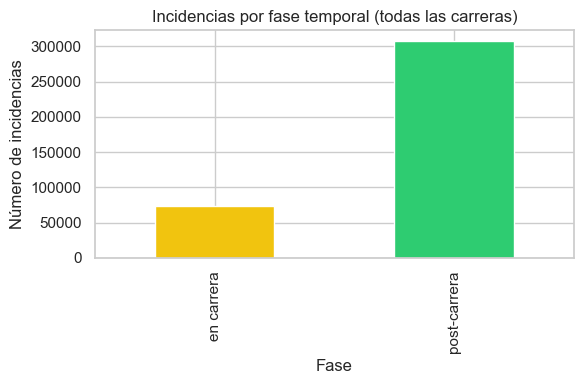


🏁 Carrera 1a83229e-2547-42a3-b5b4-36c7425c4d8f | Evento Mitja
  fase_temporal   count
0    en carrera   36589
1  post-carrera  138390


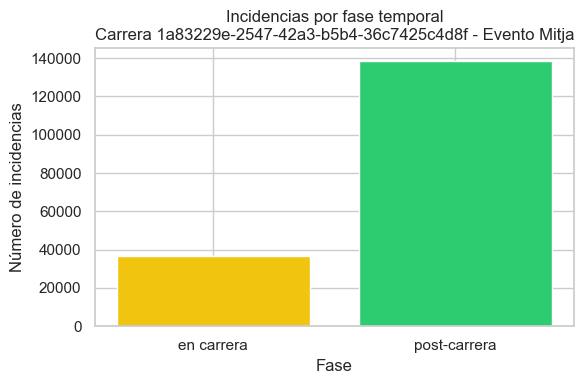


🏁 Carrera 1a83229e-2547-42a3-b5b4-36c7425c4d8f | Evento Mitja cadires
  fase_temporal  count
2    en carrera      7
3  post-carrera     25


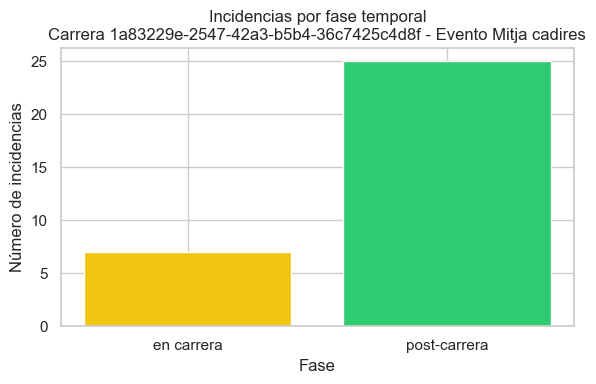


🏁 Carrera cf6f71f2-1235-45e3-802e-02833b71ae8b | Evento Stage 1
  fase_temporal  count
4    en carrera      4
5  post-carrera   5095


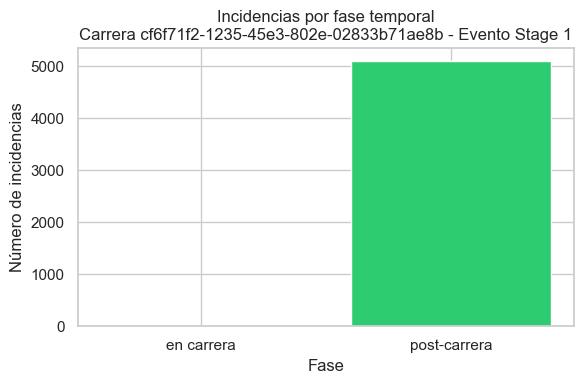


🏁 Carrera cf6f71f2-1235-45e3-802e-02833b71ae8b | Evento Stage 2
  fase_temporal  count
6    en carrera      4
7  post-carrera   5095


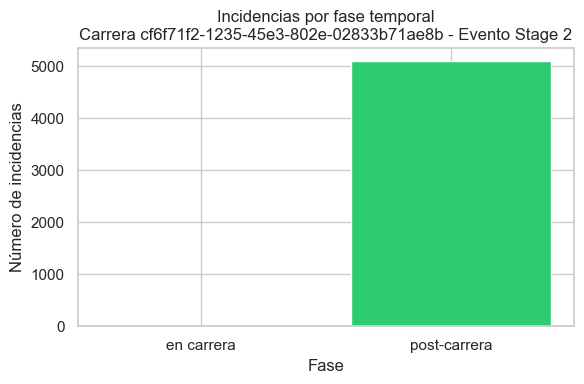


🏁 Carrera cf6f71f2-1235-45e3-802e-02833b71ae8b | Evento Stage 3
  fase_temporal  count
8    en carrera      4
9  post-carrera   5095


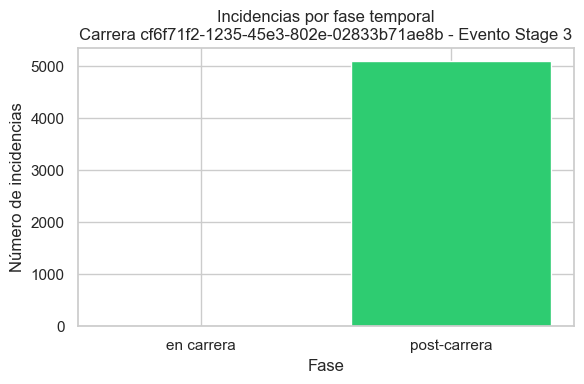


🏁 Carrera cf6f71f2-1235-45e3-802e-02833b71ae8b | Evento Stage 4
   fase_temporal  count
10    en carrera      4
11  post-carrera   5095


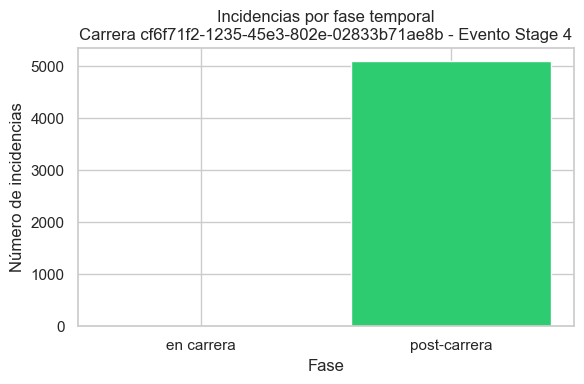


🏁 Carrera cf6f71f2-1235-45e3-802e-02833b71ae8b | Evento Stage 5
   fase_temporal  count
12    en carrera      4
13  post-carrera   5095


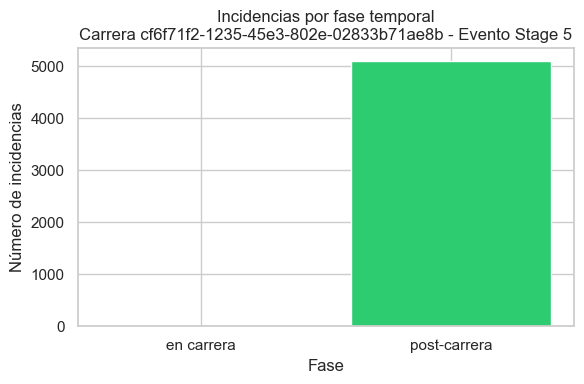


🏁 Carrera cf6f71f2-1235-45e3-802e-02833b71ae8b | Evento Stage 6
   fase_temporal  count
14    en carrera      4
15  post-carrera   5095


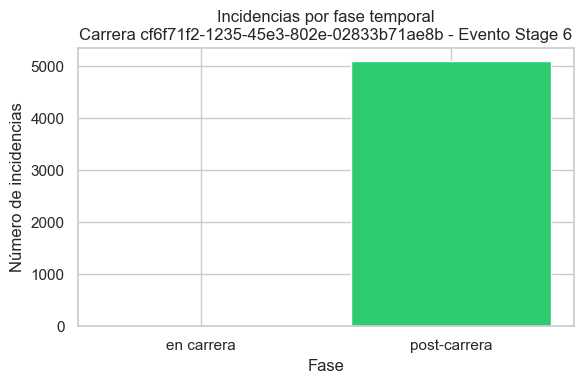

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Asegurar que datetime existe ---
if "datetime" not in issues_df.columns and "time" in issues_df.columns:
    issues_df["datetime"] = pd.to_datetime(issues_df["time"], unit="ms", errors="coerce")

# --- Añadir event_id a issues_df desde athletes_events_df ---
if "event_id" not in issues_df.columns:
    issues_df = issues_df.merge(
        athletes_events_df[["athlete_id", "race_id", "event_id"]],
        on=["athlete_id", "race_id"],
        how="left"
    )

# --- Distribución global ---
fase_counts_total = issues_df["fase_temporal"].value_counts().sort_index()
print("\n📊 Distribución global de incidencias por fase temporal:")
print(fase_counts_total)

plt.figure(figsize=(6, 4))
fase_counts_total.plot(kind="bar", color=["#F1C40F", "#2ECC71", "#E74C3C"])
plt.title("Incidencias por fase temporal (todas las carreras)")
plt.xlabel("Fase")
plt.ylabel("Número de incidencias")
plt.tight_layout()
plt.show()

# --- Agrupación por carrera y evento ---
fase_counts_race_event = (
    issues_df.groupby(["race_id", "event_id", "fase_temporal"])["id"]
    .count()
    .reset_index(name="count")
)

# --- Visualización ---
for (race, event), subdf in fase_counts_race_event.groupby(["race_id", "event_id"]):
    print(f"\n🏁 Carrera {race} | Evento {event}")
    print(subdf[["fase_temporal", "count"]])

    plt.figure(figsize=(6, 4))
    plt.bar(
        subdf["fase_temporal"],
        subdf["count"],
        color=["#F1C40F", "#2ECC71", "#E74C3C"]
    )
    plt.title(f"Incidencias por fase temporal\nCarrera {race} - Evento {event}")
    plt.xlabel("Fase")
    plt.ylabel("Número de incidencias")
    plt.tight_layout()
    plt.show()

La mayoría de incidencias se realizan pre-carrera, en la que el cronometrador se encarga de arreglar pequeños detalles de todos los atletas para ajustar como se va a cronometrar la carrera y la informacion y se importan los datos de los atletas. 

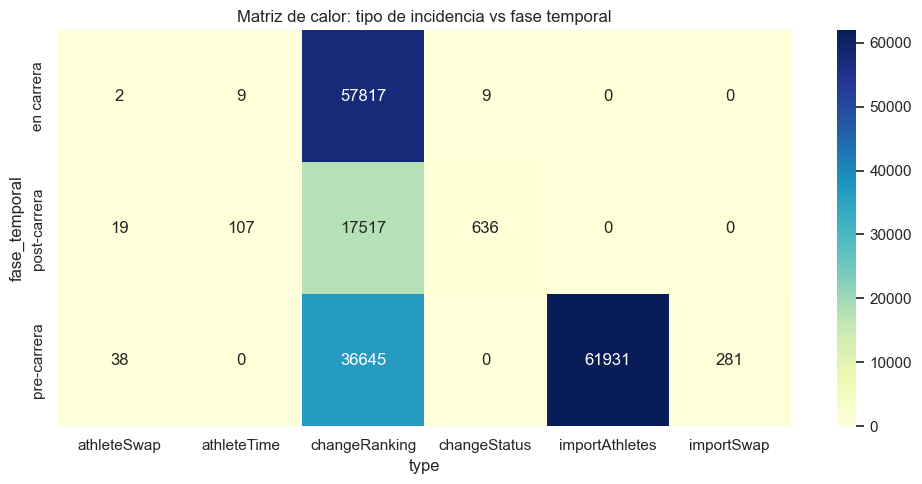

In [19]:
pivot = pd.crosstab(issues_df["fase_temporal"], issues_df["type"])
plt.figure(figsize=(10,5))
sns.heatmap(pivot, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Matriz de calor: tipo de incidencia vs fase temporal")
plt.tight_layout()
plt.show()

In [ ]:
duplicados = issues_df['id'].value_counts()
duplicados = duplicados[duplicados > 1]

print(duplicados)

id
3927efd0-ec42-11ef-a9ce-21a37501454e    7562
17922da0-ec41-11ef-a9ce-21a37501454e    5349
f27fab50-ec40-11ef-a9ce-21a37501454e    5349
137e4220-ec38-11ef-9ec6-616957f1a263    5175
c7ec4a30-ebee-11ef-94fe-1bab35233bd7    5147
                                        ... 
471e67a0-ebce-11ef-90f3-7fb351d97b78       2
acdbecb0-ebca-11ef-9447-45909889f692       2
7f598520-eb7c-11ef-84aa-b74ff1cca6c7       2
385725d0-eb93-11ef-9b57-a1ba2d2bc810       2
ca420920-ec32-11ef-a9ce-21a37501454e       2
Name: count, Length: 261, dtype: int64


Un issue se puede repetir en muchos atletas, por lo que conviene simplificar los datos. 

In [ ]:
import json
import os
import glob

def get_issues_by_id(duplicated_id, data_dir):
    
    issues_files = glob.glob(os.path.join(data_dir, "*.issues.json"))
    if not issues_files:
        raise FileNotFoundError("No se encontró ningún archivo de issues en el directorio.")

    matched_issues = []

    def issue_contains_id(issue, target_id):
        if isinstance(issue, dict):
            if issue.get("id") == target_id:
                return True
            return any(issue_contains_id(v, target_id) for v in issue.values())
        elif isinstance(issue, list):
            return any(issue_contains_id(v, target_id) for v in issue)
        return False

    for fpath in issues_files:
        with open(fpath, "r", encoding="utf-8") as f:
            data = json.load(f)
        
        flat_issues = []
        for sublist in data:
            if isinstance(sublist, list):
                flat_issues.extend(sublist)
            elif isinstance(sublist, dict):
                flat_issues.append(sublist)

        for issue in flat_issues:
            if issue_contains_id(issue, duplicated_id):
                matched_issues.append(issue)

    return matched_issues

data_dir = r"C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\raiz\datos\historicos\datos"
duplicated_id = "af4215f0-e856-11ef-aee0-f3683f511a40"

issues_json = get_issues_by_id(duplicated_id, data_dir)

# Guardar resultado en JSON
output_file = os.path.join(data_dir, f"issues_{duplicated_id}.json")
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(issues_json, f, ensure_ascii=False, indent=4)

print(f"✅ Se guardaron {len(issues_json)} issues con id {duplicated_id} en {output_file}")

✅ Se guardaron 4288 issues con id af4215f0-e856-11ef-aee0-f3683f511a40 en C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\raiz\datos\historicos\datos\issues_af4215f0-e856-11ef-aee0-f3683f511a40.json


Vemos que todos los issues con el mismo id han sido el mismo cambio pero para distintos atletas, estos nos va a servir para saber que cantidad de probloemas reales ha habido en la carrera como tal. 

In [69]:
import pandas as pd

# Suponiendo que ya tienes issues_df cargado
num_ids_unicos = issues_df['id'].nunique()
total_ids = len(issues_df)

print(f"Total de filas en issues_df: {total_ids}")
print(f"Número de ids únicos: {num_ids_unicos}")

# Opcional: mostrar cuántos ids están duplicados
num_duplicados = total_ids - num_ids_unicos
print(f"Número de ids duplicados: {num_duplicados}")

Total de filas en issues_df: 175011
Número de ids únicos: 402
Número de ids duplicados: 174609


Vemos como la mayoría de ids son duplicados y solo hay 402 errores en total, esto nos va a servir para poder hacer un análisis mucho más limpio y definido, por lo que vamos a pasar a agrupar los datos. 

In [81]:
import pandas as pd

def agrupar_issues_por_id_data_completo(
    issues_df, issues_data_df, issues_events_df,
    issues_times_df, issues_attributes_df, issues_chips_df,
    umbral_lista=10
):

    data_cols = [col for col in issues_data_df.columns if col.startswith("data_")]
    events_cols = [col for col in issues_events_df.columns if col.startswith("data_")]
    selected_cols = list(set(data_cols + events_cols))

    grouped = issues_df.groupby('id').agg({
        'type': 'first',
        'datetime': 'first',
        'fase_temporal': 'first',
        'priority': 'first',
        'race_id': 'first',
        'collection': 'first',
        'athlete_id': lambda x: list(x.dropna().unique()) 
    }).reset_index()

    grouped = grouped.rename(columns={'athlete_id': 'athletes_afectados'})

    total_athletes = issues_df['athlete_id'].nunique()

    def generar_afectacion(ids):
        num_afectados = len(ids)
        pct_afectados = num_afectados / total_athletes if total_athletes > 0 else 0
        return pct_afectados, num_afectados

    afectados_data = grouped['athletes_afectados'].apply(generar_afectacion)
    grouped['afectados'] = afectados_data.apply(lambda x: x[0])       
    grouped['num_afectados'] = afectados_data.apply(lambda x: x[1])   

    for col in selected_cols:
        if col in issues_data_df.columns:
            grouped[col] = issues_data_df.groupby('issue_id')[col].first().reindex(grouped['id']).values
        elif col in issues_events_df.columns:
            grouped[col] = issues_events_df.groupby('issue_id')[col].first().reindex(grouped['id']).values

    def map_afectacion(df):
        df_2 = df.copy()
        df_2 = df_2.merge(
            grouped[['id','afectados','num_afectados']], 
            left_on='issue_id', right_on='id', how='left'
        )
        return df_2

    issues_df_2 = map_afectacion(issues_df)
    issues_data_df_2 = map_afectacion(issues_data_df)
    issues_events_df_2 = map_afectacion(issues_events_df)
    issues_times_df_2 = map_afectacion(issues_times_df)
    issues_attributes_df_2 = map_afectacion(issues_attributes_df)
    issues_chips_df_2 = map_afectacion(issues_chips_df)

    return {
        'issues_agrupados': grouped,
        'issues_df_2': issues_df_2,
        'issues_data_df_2': issues_data_df_2,
        'issues_events_df_2': issues_events_df_2,
        'issues_times_df_2': issues_times_df_2,
        'issues_attributes_df_2': issues_attributes_df_2,
        'issues_chips_df_2': issues_chips_df_2
    }

# --- Uso ---
resultados = agrupar_issues_por_id_data_completo(
    issues_df,
    issues_data_df,
    issues_events_df,
    issues_times_df,
    issues_attributes_df,
    issues_chips_df
)

print(resultados['issues_agrupados'].columns.tolist())

['id', 'type', 'datetime', 'fase_temporal', 'priority', 'race_id', 'collection', 'athletes_afectados', 'afectados', 'num_afectados', 'data_club', 'data_events_gunTime', 'data_events_times_Meta_time', 'data_events_times_20K_time', 'data_events_times_5K_time', 'data_events_gunTimeModeConfig_wave', 'data_events_times_15K_time', 'data_events_attributes_Sillas', 'data_gender', 'data_events_times_10K_time', 'data_statusNote', 'data_name', 'data_document', 'data_events_category', 'data_events_status', 'data_nationality', 'data_TIEMPO ESTIMADO', 'data_events_auto_chip', 'data_events_auto_category', 'data_events_times_Salida_time', 'data_birthdate', 'data_Licencia', 'data_events_attributes_Discapacitado intelectual', 'data_surname', 'data_events_attributes_Discapacitado visual', 'data_events_dorsal']


In [82]:
IA = resultados['issues_agrupados']

# Opción 1: usando .shape
print("Número de filas:", IA.shape[0])
print("Número de columnas:", IA.shape[1])

Número de filas: 402
Número de columnas: 36


In [83]:
IA.columns

Index(['id', 'type', 'datetime', 'fase_temporal', 'priority', 'race_id',
       'collection', 'athletes_afectados', 'afectados', 'num_afectados',
       'data_club', 'data_events_gunTime', 'data_events_times_Meta_time',
       'data_events_times_20K_time', 'data_events_times_5K_time',
       'data_events_gunTimeModeConfig_wave', 'data_events_times_15K_time',
       'data_events_attributes_Sillas', 'data_gender',
       'data_events_times_10K_time', 'data_statusNote', 'data_name',
       'data_document', 'data_events_category', 'data_events_status',
       'data_nationality', 'data_TIEMPO ESTIMADO', 'data_events_auto_chip',
       'data_events_auto_category', 'data_events_times_Salida_time',
       'data_birthdate', 'data_Licencia',
       'data_events_attributes_Discapacitado intelectual', 'data_surname',
       'data_events_attributes_Discapacitado visual', 'data_events_dorsal'],
      dtype='object')

Ahora tenemos todos los issues en un solo dataframe que estudiaremos a nuestro antojo. 

In [84]:
IA.groupby('type')['num_afectados'].agg(['mean','max'])

,mean,max
type,,
athleteSwap,1.114286,2
athleteTime,1.468354,38
changeRanking,437.316406,7562
changeStatus,37.941176,423
importAthletes,4129.200000,4991


Vemos como hay tipos de errores que se aplican de forma masiva, y otros que no tanto, dando un poco de contexto de su utilidad. 

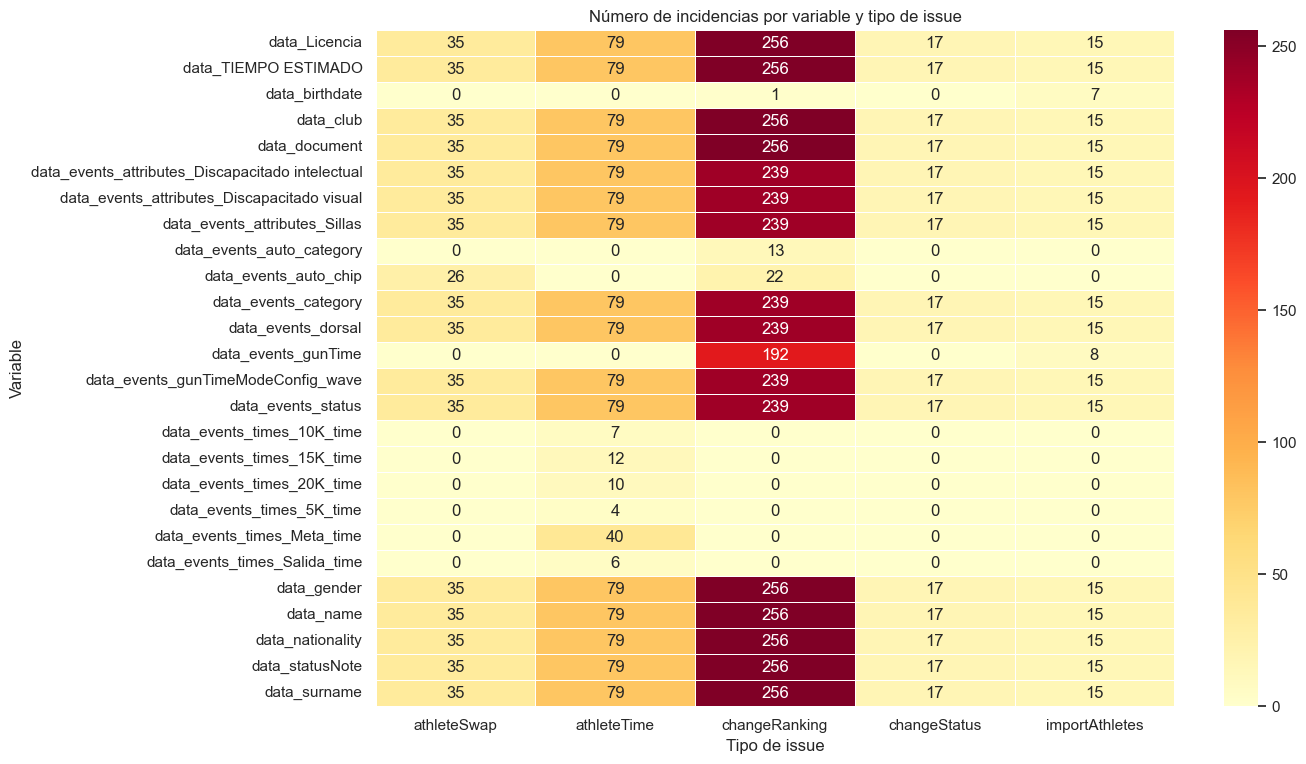

In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar columnas relevantes
cols_data = [c for c in IA.columns if c.startswith('data_') or c.startswith('data_events_')]

# Crear lista para almacenar los resultados
records = []

for col in cols_data:
    summary = IA.groupby('type')[col].apply(lambda x: x.notna().sum())
    for issue_type, count in summary.items():
        records.append({'variable': col, 'type': issue_type, 'count': count})

# Convertir a DataFrame
df_summary = pd.DataFrame(records)

# Pivot para heatmap
heatmap_data = df_summary.pivot(index='variable', columns='type', values='count').fillna(0)

# --- Heatmap ---
plt.figure(figsize=(14, max(6, len(heatmap_data)*0.3)))  # ajustar altura según número de variables
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".0f", 
    cmap="YlOrRd", 
    linewidths=0.5
)
plt.title("Número de incidencias por variable y tipo de issue")
plt.ylabel("Variable")
plt.xlabel("Tipo de issue")
plt.tight_layout()
plt.show()

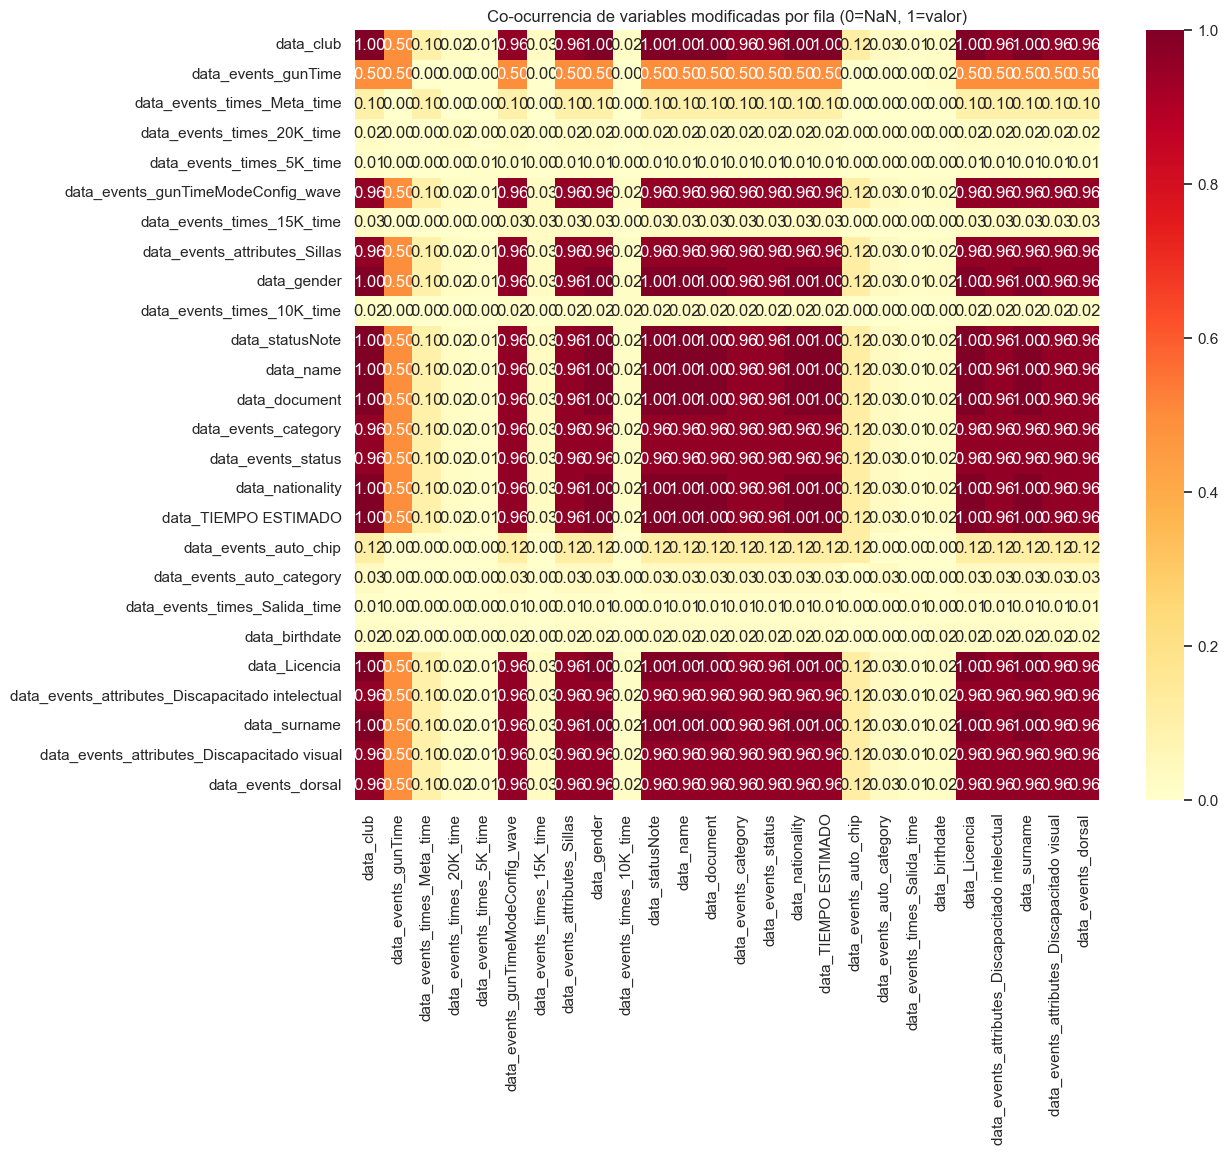

In [91]:
# 1️⃣ Crear matriz binaria: 1 si hay valor, 0 si NaN
df_binary = IA[cols_data].notna().astype(int)

# 2️⃣ Matriz de co-ocurrencia (cuántas veces se modifican juntas)
cooccurrence = df_binary.T.dot(df_binary)

# 3️⃣ Normalizar opcionalmente por número de incidencias para que sea % de co-ocurrencia
cooccurrence_pct = cooccurrence / len(IA)

# 4️⃣ Heatmap
plt.figure(figsize=(12,10))
sns.heatmap(cooccurrence_pct, cmap='YlOrRd', annot=True, fmt=".2f")
plt.title("Co-ocurrencia de variables modificadas por fila (0=NaN, 1=valor)")
plt.show()

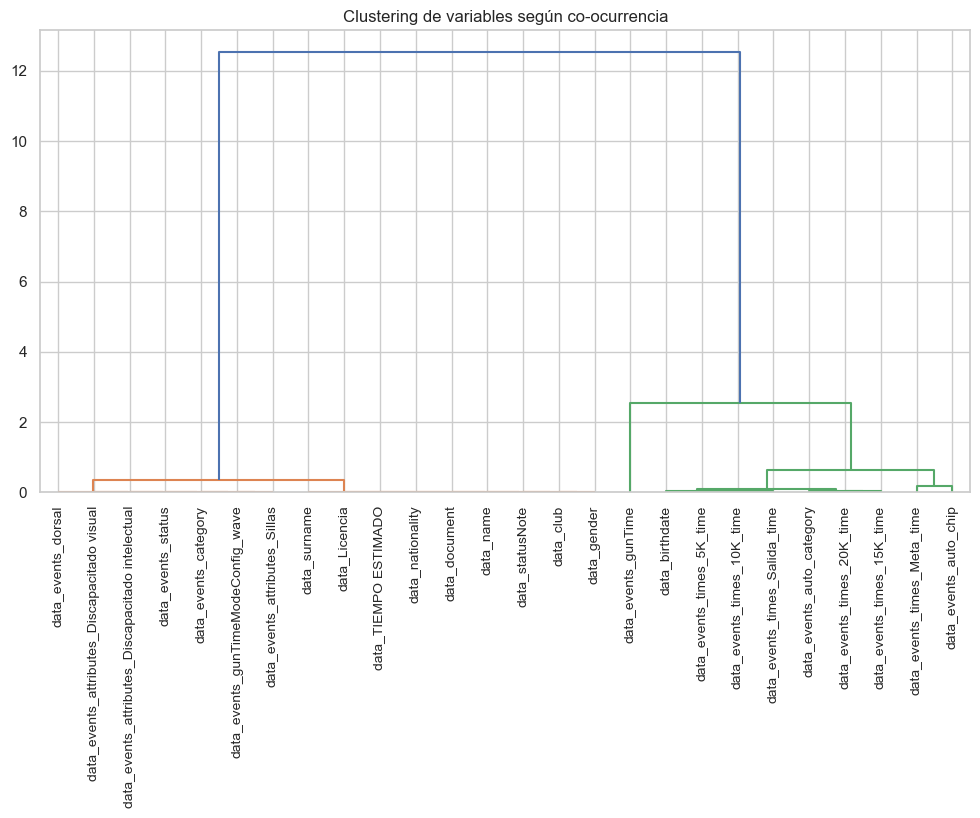

In [92]:
from scipy.cluster.hierarchy import linkage, dendrogram

# 1️⃣ Matriz binaria: 1 si hay valor, 0 si NaN
df_binary = IA[cols_data].notna().astype(int)

# 2️⃣ Matriz de co-ocurrencia normalizada
cooccurrence = df_binary.T.dot(df_binary) / len(df_binary)

# 3️⃣ Convertir a distancia
dist_matrix = 1 - cooccurrence

# 4️⃣ Clustering jerárquico
linked = linkage(dist_matrix, method='ward')

# 5️⃣ Dendrograma
plt.figure(figsize=(12,6))
dendrogram(linked, labels=cooccurrence.columns, leaf_rotation=90)
plt.title("Clustering de variables según co-ocurrencia")
plt.show()

In [117]:
from itertools import combinations
from collections import Counter

combinations_by_type = {}

for tipo in df_changes['type'].unique():
    df_tipo = df_changes[df_changes['type'] == tipo]
    
    # Agrupamos por instante y issue, obtenemos lista de variables modificadas
    grouped = df_tipo.groupby(['id', 'datetime'])['variable'].apply(list)
    
    # Contamos combinaciones de 2 variables (puedes aumentar n)
    comb_counter = Counter()
    for vars_list in grouped:
        comb_counter.update(combinations(sorted(vars_list), 2))
    
    combinations_by_type[tipo] = comb_counter.most_common(10)  # top 10 combinaciones

# Mostrar resultados
for tipo, combs in combinations_by_type.items():
    print(f"\nTipo: {tipo}\nTop combinaciones de variables cambiadas:")
    for combo, count in combs:
        print(f"{combo}: {count}")


Tipo: importAthletes
Top combinaciones de variables cambiadas:
('data_birthdate', 'data_document'): 7
('data_birthdate', 'data_events_gunTime'): 7
('data_birthdate', 'data_nationality'): 7
('data_document', 'data_events_gunTime'): 7
('data_document', 'data_nationality'): 7
('data_events_gunTime', 'data_nationality'): 7
('data_events_gunTime', 'data_events_gunTimeModeConfig_wave'): 6
('data_birthdate', 'data_events_gunTimeModeConfig_wave'): 5
('data_document', 'data_events_gunTimeModeConfig_wave'): 5
('data_events_gunTimeModeConfig_wave', 'data_nationality'): 5

Tipo: changeRanking
Top combinaciones de variables cambiadas:
('data_events_gunTime', 'data_events_gunTimeModeConfig_wave'): 179
('data_events_auto_category', 'data_events_category'): 11
('data_name', 'data_surname'): 4
('data_events_auto_category', 'data_statusNote'): 2
('data_events_gunTime', 'data_gender'): 1
('data_events_gunTimeModeConfig_wave', 'data_gender'): 1
('data_events_auto_chip', 'data_events_dorsal'): 1

Tipo: at

In [99]:
# Filtramos cambios reales (solo valores no nulos ni vacíos)
value_cols = [c for c in IA.columns if c.startswith('data_') or c.startswith('data_events_')]

df_changes = IA.melt(
    id_vars=['id', 'type', 'datetime', 'fase_temporal', 'afectados', 'athletes_afectados', 'num_afectados'],
    value_vars=value_cols,
    var_name='variable',
    value_name='valor'
)

# Filtrar valores válidos: no nulos, no vacíos ni NaT
df_changes = df_changes[df_changes['valor'].notna() & (df_changes['valor'] != "")]

# Convertimos datetime si no lo está
df_changes['datetime'] = pd.to_datetime(df_changes['datetime'])

In [103]:
# Calcular porcentaje de atletas afectados
total_athletes = len(athletes_df)
df_changes['pct_afectados'] = df_changes['num_afectados'] / total_athletes * 100

# Crear scatterplot con Plotly Express
import plotly.express as px

fig = px.scatter(
    df_changes,
    x='datetime',
    y='variable',
    color='type',
    size_max=12,
    hover_data=['pct_afectados'],
    title='Cambios de variables a lo largo del tiempo por tipo de issue'
)
fig.show()

Vemos como la mayoría de errores se distribuyen pre carrera, en carrera y unos pocos dias y horas despues de la carrera. Lo cuál nos da un contexto de como se van cambiando y en los momentos en el que lo hacen. 

In [105]:
import plotly.express as px

color_map = {
    'athleteTime': 'blue',
    'changeRanking': 'red',
    'athleteSwap': 'green',
    'importAthletes': 'orange',
    'changeStatus': 'purple',
    'other': 'brown'
}

for tipo in df_changes['type'].unique():
    df_tipo = df_changes[(df_changes['type'] == tipo) & (df_changes['pct_afectados'].notna())]

    if df_tipo.empty:
        continue  

    color = color_map.get(tipo, 'gray')

    fig = px.scatter(
        df_tipo,
        x='datetime',
        y='variable',
        color_discrete_sequence=[color],  # un solo color por tipo
        size_max=12,
        hover_data=['pct_afectados'],
        title=f'Cambios de variables a lo largo del tiempo - Tipo: {tipo}'
    )

    fig.update_layout(
        dragmode='zoom',           
        hovermode='closest',       
        yaxis={'categoryorder':'total ascending'}
    )

    fig.show(config={'scrollZoom': True, 'displayModeBar': True})

- **importAthletes**: Casi todos antes de empezar la carrera, seguramente se importan 

In [113]:
import pandas as pd
import plotly.express as px
import numpy as np

# Copiar DataFrame
df_plot = IA.copy()
df_plot['datetime'] = pd.to_datetime(df_plot['datetime'])

# Hover solo con valores no nulos
cols_data = [c for c in df_plot.columns if c.startswith("data_") or c.startswith("data_events_")]

def make_hover(row):
    hover_text = (
        f"ID: {row['id']}<br>"
        f"Tipo: {row['type']}<br>"
        f"Afectados: {row['afectados']*100:.1f}% ({row['num_afectados']})"
    )
    for col in cols_data:
        val = row[col]
        if pd.notna(val) and val not in ["", None, "NaT"]:
            hover_text += f"<br>{col}: {val}"
    return hover_text

df_plot['hover'] = df_plot.apply(make_hover, axis=1)

# Tamaño según número de afectados, escala gradual
# Usamos raíz cuadrada para suavizar diferencias grandes
df_plot['afectados_size'] = np.sqrt(df_plot['num_afectados'])

# Gráfico scatter
fig = px.scatter(
    df_plot,
    x='datetime',
    y='type',
    size='afectados_size',
    color='type',
    hover_name='hover',
    title="Distribución de tipos de issues en el tiempo",
    height=600
)

# Líneas verticales para fases temporales
for fase in df_plot['fase_temporal'].dropna().unique():
    fechas = df_plot[df_plot['fase_temporal'] == fase]['datetime']
    if not fechas.empty:
        fecha_min = fechas.min()
        fig.add_shape(
            type="line",
            x0=fecha_min,
            x1=fecha_min,
            y0=-0.5,
            y1=len(df_plot['type'].unique()) - 0.5,
            line=dict(color="gray", dash="dash"),
        )
        fig.add_annotation(
            x=fecha_min,
            y=len(df_plot['type'].unique()) - 0.5,
            text=fase,
            showarrow=False,
            xanchor="left",
            yanchor="bottom"
        )

# Configuración interacción y zoom
fig.update_layout(
    yaxis={'categoryorder':'total ascending'},
    dragmode=False,        # desactiva zoom por arrastre
    hovermode='closest'
)

# Ajuste del tamaño de los puntos
fig.update_traces(marker=dict(sizemode='area', sizeref=0.1, line_width=1))

# Zoom con Ctrl + rueda del ratón
fig.show(config={
    'scrollZoom': True,  
    'displayModeBar': True,
})

In [114]:
pd.crosstab(IA['type'], IA['fase_temporal'], normalize='index')

fase_temporal,en carrera,post-carrera,pre-carrera
type,,,
athleteSwap,0.028571,0.371429,0.60000
athleteTime,0.113924,0.886076,0.00000
changeRanking,0.175781,0.667969,0.15625
changeStatus,0.117647,0.882353,0.00000
importAthletes,0.000000,0.000000,1.00000


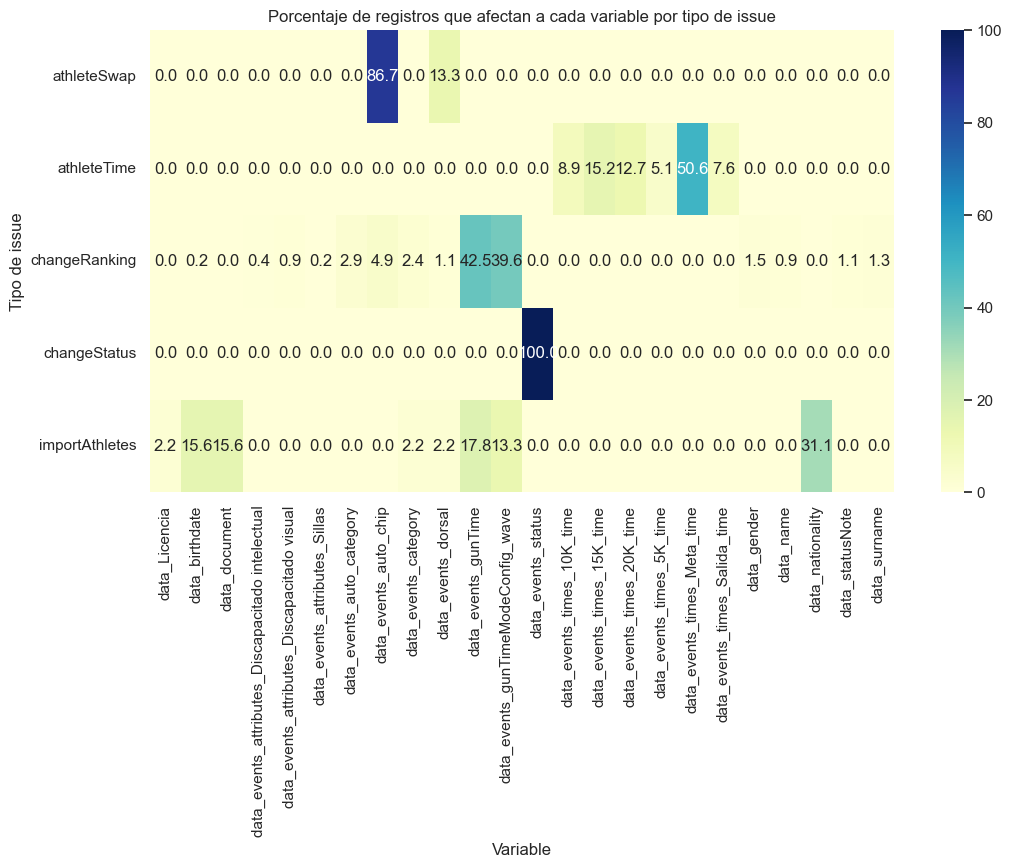

In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# df_changes: columnas ['type', 'variable', 'valor'] o cualquier columna que indique cambio

# 1️⃣ Contar cuántos registros tienen un valor modificado para cada variable y tipo
counts = df_changes.groupby(['type', 'variable'])['valor'].count().unstack(fill_value=0)

# 2️⃣ Dividir entre el total de registros de cada tipo para obtener porcentaje
counts_pct = counts.div(counts.sum(axis=1), axis=0) * 100

# 3️⃣ Visualización como heatmap
plt.figure(figsize=(12,6))
sns.heatmap(counts_pct, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Porcentaje de registros que afectan a cada variable por tipo de issue')
plt.ylabel('Tipo de issue')
plt.xlabel('Variable')
plt.show()

### Correlaciones de los issues con las variables

Anteriormente hemos obtenido algunas conclusiones en base a los tipos de error, y creemos que los errores de tipo changeranking, athleteswap e importathletes no entran en nuestro estudio por diferentes moticos (poca abstraccion y contexto e importaciones generales). Por lo que nuestro estudio se centrará en changestatus y athlete time, de las cuáles intentaremos predecir el porque un atleta cambia su estatus de carrera o modifica su tiempo en base a los datos de carrera. 

Identificar qué causas explican (o se asocian con alta probabilidad) la aparición de issues tipo:

- changeStatus — cambios de estado del atleta (p.ej. pasa a retired, DSQ, etc.)

- athleteTime — cambios de tiempos (errores o correcciones de cronometraje).

Y esas causas pueden venir de dos fuentes:

- Variables del atleta (athletes_df, athletes_events_df, …)

- Otros issues sobre el mismo atleta o variable, en momentos cercanos (correlación espacial-temporal).

In [103]:
df_changes.head()

,id,type,datetime,fase_temporal,afectados,athletes_afectados,variable,valor
79,2e616100-eec0-11ef-ba02-2d3eb2d81d1f,athleteTime,2025-02-19 12:51:05.104,post-carrera,0.000032,[19477A97],data_events_times_5K_time,1609398.0
140,5c88e2a0-ee94-11ef-9ab3-55798f1380ce,athleteTime,2025-02-19 07:37:24.682,post-carrera,0.000032,[28B12198],data_events_times_5K_time,1581000.0
336,ccb409f0-ed37-11ef-9ac5-999bc91314b6,athleteTime,2025-02-17 14:02:18.511,post-carrera,0.000032,[52674F19],data_events_times_5K_time,1499877.0
401,ff1b2cd0-edd6-11ef-b1a8-0779410a0038,athleteTime,2025-02-18 09:01:53.053,post-carrera,0.000032,[4D831Z6B],data_events_times_5K_time,1368000.0
427,11a62f30-edd7-11ef-b1a8-0779410a0038,athleteTime,2025-02-18 09:02:24.163,post-carrera,0.000032,[4D831Z6B],data_events_times_10K_time,2503000.0


Primero filtramos por issues relevantes

In [26]:
# Nos quedamos solo con los tipos de issue que queremos estudiar
df_filtrado = df_changes[df_changes['type'].isin(['changeStatus', 'athleteTime'])].copy()

# Aseguramos que la fecha esté en formato datetime
df_filtrado['datetime'] = pd.to_datetime(df_filtrado['datetime'])

print("Tipos de issue incluidos:", df_filtrado['type'].unique())
print("Filas seleccionadas:", len(df_filtrado))
df_filtrado.head()

Tipos de issue incluidos: ['athleteTime' 'changeStatus']
Filas seleccionadas: 96


,id,type,datetime,fase_temporal,afectados,athletes_afectados,variable,valor
79,2e616100-eec0-11ef-ba02-2d3eb2d81d1f,athleteTime,2025-02-19 12:51:05.104,post-carrera,0.000032,[19477A97],data_events_times_5K_time,1609398.0
140,5c88e2a0-ee94-11ef-9ab3-55798f1380ce,athleteTime,2025-02-19 07:37:24.682,post-carrera,0.000032,[28B12198],data_events_times_5K_time,1581000.0
336,ccb409f0-ed37-11ef-9ac5-999bc91314b6,athleteTime,2025-02-17 14:02:18.511,post-carrera,0.000032,[52674F19],data_events_times_5K_time,1499877.0
401,ff1b2cd0-edd6-11ef-b1a8-0779410a0038,athleteTime,2025-02-18 09:01:53.053,post-carrera,0.000032,[4D831Z6B],data_events_times_5K_time,1368000.0
427,11a62f30-edd7-11ef-b1a8-0779410a0038,athleteTime,2025-02-18 09:02:24.163,post-carrera,0.000032,[4D831Z6B],data_events_times_10K_time,2503000.0


In [27]:
# 1️⃣ Expandir la lista de atletas afectados
df_exploded = (
    df_filtrado
    .explode('athletes_afectados')
    .rename(columns={'athletes_afectados': 'athlete_id'})
)

# 2️⃣ Mantener todos los IDs como string limpio
df_exploded['athlete_id'] = df_exploded['athlete_id'].astype(str).str.strip()

print("Filas después de expandir:", len(df_exploded))
print("Ejemplo de athlete_id:", df_exploded['athlete_id'].unique()[:10])
df_exploded.head()

Filas después de expandir: 761
Ejemplo de athlete_id: ['19477A97' '28B12198' '52674F19' '4D831Z6B' 'D43Y2162' 'ZC3F3D71'
 'B4AC91Z4' '6F2A8Y61' 'A1Z3B616' 'BD2YBD42']


,id,type,datetime,fase_temporal,afectados,athlete_id,variable,valor
79,2e616100-eec0-11ef-ba02-2d3eb2d81d1f,athleteTime,2025-02-19 12:51:05.104,post-carrera,0.000032,19477A97,data_events_times_5K_time,1609398.0
140,5c88e2a0-ee94-11ef-9ab3-55798f1380ce,athleteTime,2025-02-19 07:37:24.682,post-carrera,0.000032,28B12198,data_events_times_5K_time,1581000.0
336,ccb409f0-ed37-11ef-9ac5-999bc91314b6,athleteTime,2025-02-17 14:02:18.511,post-carrera,0.000032,52674F19,data_events_times_5K_time,1499877.0
401,ff1b2cd0-edd6-11ef-b1a8-0779410a0038,athleteTime,2025-02-18 09:01:53.053,post-carrera,0.000032,4D831Z6B,data_events_times_5K_time,1368000.0
427,11a62f30-edd7-11ef-b1a8-0779410a0038,athleteTime,2025-02-18 09:02:24.163,post-carrera,0.000032,4D831Z6B,data_events_times_10K_time,2503000.0


In [28]:
# Filtrar solo issues de tipo changeStatus post-carrera
df_status = df_exploded[
    (df_exploded['type'] == 'changeStatus') &
    (df_exploded['fase_temporal'].str.lower().str.contains('post'))
].copy()

print(f"Total de changeStatus post-carrera: {len(df_status)}")
print("Tipos de estado detectados:")
print(df_status['valor'].value_counts())

Total de changeStatus post-carrera: 636
Tipos de estado detectados:
valor
retired         434
disqualified    200
quarantine        2
Name: count, dtype: int64


In [92]:
status_types = df_status['valor'].unique()

# Diccionario de atletas por tipo de status
status_dict = {
    s: set(df_status.loc[df_status['valor'] == s, 'athlete_id'])
    for s in status_types
}

# Añadir columnas binarias al athletes_events_df
for s in status_types:
    col_name = f'has_status_{s}'
    athletes_events_df[col_name] = athletes_events_df['athlete_id'].isin(status_dict[s]).astype(int)

# Añadir columnas binarias al athletes_events_df
for s in status_types:
    col_name = f'has_status_{s}'
    athletes_time_df[col_name] = athletes_time_df['athlete_id'].isin(status_dict[s]).astype(int)

    # Añadir columnas binarias al athletes_events_df
for s in status_types:
    col_name = f'has_status_{s}'
    athletes_df[col_name] = athletes_df['athlete_id'].isin(status_dict[s]).astype(int)

In [94]:
athletes_df.columns

Index(['Licencia', 'TIEMPO ESTIMADO', 'athlete_id', 'birthdate', 'club',
       'color', 'featured', 'fullName', 'gender', 'id', 'importId', 'name',
       'nationality', 'race_id', 'statusNote', 'surname', 'user_id',
       'club_clean', 'nationality_clean', 'has_status_disqualified',
       'has_status_retired', 'has_status_quarantine'],
      dtype='object')

In [31]:
import pandas as pd

# Fecha de la carrera
race_date = pd.Timestamp('2025-02-16')

# Calcular edad
athletes_df['age'] = (race_date - athletes_df['birthdate']).dt.days // 365

# Crear 4 grupos de edad
bins = [0, 25, 35, 45, 100]  # ajustable según tu población
labels = ['<25', '25-34', '35-44', '45+']

athletes_df['age_group'] = pd.cut(athletes_df['age'], bins=bins, labels=labels, right=False)

# Revisar
athletes_df[['age', 'age_group']].head(10)

athletes_df['age_group'] = athletes_df['age_group'].astype('category')

In [113]:
print(athletes_df['age_group'].dtype)

category


In [75]:
athletes_df.columns

Index(['Licencia', 'TIEMPO ESTIMADO', 'athlete_id', 'birthdate', 'club',
       'color', 'featured', 'fullName', 'gender', 'id', 'importId', 'name',
       'nationality', 'race_id', 'statusNote', 'surname', 'user_id',
       'has_status_disqualified', 'has_status_retired',
       'has_status_quarantine', 'age', 'age_group'],
      dtype='object')

In [79]:
athletes_df['has_status_retired'].value_counts()

has_status_retired
0    31249
1      434
Name: count, dtype: int64

In [89]:
import pandas as pd
import numpy as np
import warnings
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu, fisher_exact
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("ignore", category=RuntimeWarning)

# --- Función para V de Cramer ---
def cramers_v(confusion_matrix):
    """Calcula V de Cramer para tablas de contingencia"""
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    k = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * k))

# --- Función principal de análisis ---
def analyze_dataframe(df, dummy_cols, max_categories=20):
    """
    Analiza un DataFrame comparando variables categóricas, numéricas y timedelta frente a dummies.
    Incluye:
      - Chi² y Fisher (para categóricas)
      - t-test y Mann-Whitney (para numéricas)
      - Regresión logística balanceada (odds ratio)
    """
    results = {'categorical': [], 'numerical': []}

    # Identificar tipos de columnas
    numeric_cols = df.select_dtypes(include=[np.number, 'timedelta']).columns.difference(dummy_cols)
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    # --- Análisis categórico ---
    for cat_col in categorical_cols:
        n_categories = df[cat_col].nunique()
        if n_categories > max_categories:
            continue

        for dummy in dummy_cols:
            try:
                table = pd.crosstab(df[cat_col], df[dummy])

                if table.shape[0] > 1 and table.shape[1] > 1:
                    chi2, p_chi2, _, _ = chi2_contingency(table)
                    v = cramers_v(table)

                    # Fisher sólo si la tabla es 2x2
                    p_fisher = np.nan
                    if table.shape == (2, 2):
                        _, p_fisher = fisher_exact(table)

                    results['categorical'].append({
                        'categorical_var': cat_col,
                        'dummy': dummy,
                        'chi2': chi2,
                        'p_chi2': p_chi2,
                        'p_fisher': p_fisher,
                        'cramers_v': v
                    })
            except Exception as e:
                print(f"Error en {cat_col} vs {dummy}: {e}")
                continue

    # --- Análisis numérico / timedelta ---
    for num_col in numeric_cols:
        for dummy in dummy_cols:
            col_data = df[num_col]

            # Convertir timedelta a segundos si aplica
            if np.issubdtype(col_data.dtype, np.timedelta64):
                col_data = col_data.dt.total_seconds()

            group0 = col_data[df[dummy] == 0].dropna()
            group1 = col_data[df[dummy] == 1].dropna()

            # Saltar si falta un grupo
            if len(group0) == 0 or len(group1) == 0:
                continue

            try:
                # --- t-test ---
                t_stat, t_p = ttest_ind(group0, group1, nan_policy='omit')

                # --- Mann-Whitney ---
                u_stat, u_p = mannwhitneyu(group0, group1, alternative='two-sided')

                # --- Regresión logística balanceada ---
                valid_idx = df[[num_col, dummy]].dropna().index
                X = df.loc[valid_idx, [num_col]].astype(float)
                y = df.loc[valid_idx, dummy].astype(int)

                logit = LogisticRegression(class_weight='balanced', solver='liblinear')
                logit.fit(X, y)

                coef = logit.coef_[0][0]
                odds_ratio = np.exp(coef)

                results['numerical'].append({
                    'numeric_var': num_col,
                    'dummy': dummy,
                    't_stat': t_stat,
                    't_pvalue': t_p,
                    'mannwhitney_u': u_stat,
                    'mannwhitney_pvalue': u_p,
                    'logit_coef': coef,
                    'odds_ratio': odds_ratio
                })

            except Exception as e:
                print(f"Error en {num_col} vs {dummy}: {e}")
                continue

    return results


# === Ejemplo de uso ===
dummy_cols = ['has_status_retired', 'has_status_disqualified']

analysis_results = analyze_dataframe(athletes_df, dummy_cols, max_categories=20)

# Convertir resultados a DataFrames
cat_results_df = pd.DataFrame(analysis_results['categorical'])
num_results_df = pd.DataFrame(analysis_results['numerical'])

print("=== Resultados categóricos ===")
print(cat_results_df)

print("\n=== Resultados numéricos (con regresión logística balanceada) ===")
print(num_results_df)

=== Resultados categóricos ===
    categorical_var                    dummy          chi2        p_chi2  \
0   TIEMPO ESTIMADO       has_status_retired    223.364116  4.759258e-41   
1   TIEMPO ESTIMADO  has_status_disqualified     18.285532  1.072918e-01   
2             color       has_status_retired      9.977400  3.523180e-01   
3             color  has_status_disqualified     10.174898  3.365128e-01   
4            gender       has_status_retired      0.669888  7.153781e-01   
5            gender  has_status_disqualified      2.842526  2.414090e-01   
6          importId       has_status_retired    345.806557  1.581937e-64   
7          importId  has_status_disqualified     12.067927  6.738803e-01   
8        statusNote       has_status_retired      1.840983  1.748357e-01   
9        statusNote  has_status_disqualified  30726.815447  0.000000e+00   
10        age_group       has_status_retired      1.658274  6.462499e-01   
11        age_group  has_status_disqualified     54.23330

In [84]:
# --- Ejemplo de uso ---
dummy_cols = ['has_status_quarantine', 'has_status_retired', 'has_status_disqualified']
analysis_results = analyze_dataframe(athletes_events_df, dummy_cols, max_categories=20)

# Convertir a DataFrame para visualizar mejor
cat_results_df = pd.DataFrame(analysis_results['categorical'])
num_results_df = pd.DataFrame(analysis_results['numerical'])

print("Categorical results:")
print(cat_results_df)

print("\nNumerical results:")
print(num_results_df)

Error en leader_time_td vs has_status_quarantine: Cannot cast TimedeltaArray to dtype float64
Error en leader_time_td vs has_status_retired: Cannot cast TimedeltaArray to dtype float64
Error en leader_time_td vs has_status_disqualified: Cannot cast TimedeltaArray to dtype float64
Error en startNetTime_td vs has_status_retired: Cannot cast TimedeltaArray to dtype float64
Error en startNetTime_td vs has_status_disqualified: Cannot cast TimedeltaArray to dtype float64
Error en startTime_td vs has_status_retired: Cannot cast TimedeltaArray to dtype float64
Error en startTime_td vs has_status_disqualified: Cannot cast TimedeltaArray to dtype float64
Categorical results:
                         categorical_var                    dummy  \
0   attributes_Discapacitado intelectual    has_status_quarantine   
1   attributes_Discapacitado intelectual       has_status_retired   
2   attributes_Discapacitado intelectual  has_status_disqualified   
3        attributes_Discapacitado visual    has_st

In [90]:
# --- Ejemplo de uso ---
dummy_cols = ['has_status_quarantine', 'has_status_retired', 'has_status_disqualified']
analysis_results = analyze_dataframe(athletes_time_df, dummy_cols, max_categories=20)

# Convertir a DataFrame para visualizar mejor
cat_results_df = pd.DataFrame(analysis_results['categorical'])
num_results_df = pd.DataFrame(analysis_results['numerical'])

print("Categorical results:")
print(cat_results_df)

print("\nNumerical results:")
print(num_results_df)

Error en netTime_td vs has_status_quarantine: Cannot cast TimedeltaArray to dtype float64
Error en netTime_td vs has_status_retired: Cannot cast TimedeltaArray to dtype float64
Error en netTime_td vs has_status_disqualified: Cannot cast TimedeltaArray to dtype float64
Error en offset_td vs has_status_retired: Cannot cast TimedeltaArray to dtype float64
Error en offset_td vs has_status_disqualified: Cannot cast TimedeltaArray to dtype float64
Error en originalTime_td vs has_status_quarantine: Cannot cast TimedeltaArray to dtype float64
Error en originalTime_td vs has_status_disqualified: Cannot cast TimedeltaArray to dtype float64
Error en raw_backupOffset_td vs has_status_retired: Cannot cast TimedeltaArray to dtype float64
Error en raw_backupOffset_td vs has_status_disqualified: Cannot cast TimedeltaArray to dtype float64
Error en raw_times_official_td vs has_status_quarantine: Cannot cast TimedeltaArray to dtype float64
Error en raw_times_official_td vs has_status_retired: Cannot cas

**Retired**: average, netTime, order, splitsMissing,
**Disqualified**: age, issuesCount_data, splitsMissing, statusNote. 

In [93]:
# --- Calcular conteo de atletas descalificados por número de splits missing ---

# 1️⃣ Extraemos las columnas necesarias
df_splits = athletes_events_df[['athlete_id', 'splitsMissing', 'has_status_disqualified']]

# 2️⃣ Combinamos ambas tablas
merged = df_splits.merge(df_status, on='athlete_id', how='left')

# 3️⃣ Filtramos solo los atletas descalificados
disqualified = merged[merged['has_status_disqualified'] == 1]

# 4️⃣ Contamos cuántos tienen 0, 1, 2... splits faltantes
count_by_missing_splits = disqualified['splitsMissing'].value_counts().sort_index()

# 5️⃣ (Opcional) Calculamos también las proporciones
proportion_by_missing_splits = (count_by_missing_splits / count_by_missing_splits.sum()) * 100

# --- Resultados ---
print("Conteo de atletas descalificados por número de splits faltantes:")
print(count_by_missing_splits)

print("\nProporción (%):")
print(proportion_by_missing_splits.round(2))

Conteo de atletas descalificados por número de splits faltantes:
splitsMissing
0     2
2    79
3    58
4    37
5    26
Name: count, dtype: int64

Proporción (%):
splitsMissing
0     0.99
2    39.11
3    28.71
4    18.32
5    12.87
Name: count, dtype: float64


### Change status: correlacion temporal

Posible modelo de hawkess

In [105]:
import pandas as pd

df = df_changes.copy()
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')
df['type'] = df['type'].astype(str)

print("Rango temporal:", df['datetime'].min(), "→", df['datetime'].max())
print("\nNúmero de eventos por tipo:\n", df['type'].value_counts())

Rango temporal: 2025-02-11 08:57:51.349000 → 2025-04-23 07:48:44.243000

Número de eventos por tipo:
 type
changeRanking     452
athleteTime        79
importAthletes     45
athleteSwap        30
changeStatus       17
Name: count, dtype: int64


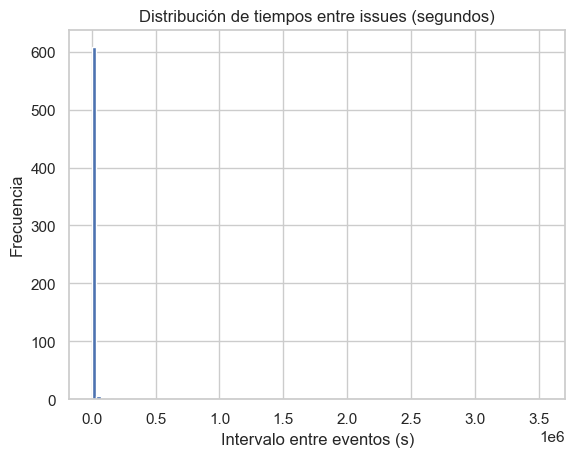

Media: 9855.71 segundos
Desviación estándar: 145613.42
Coeficiente de variación (CV): 14.77


In [107]:
import matplotlib.pyplot as plt

df_sorted = df.sort_values('datetime')
dt = df_sorted['datetime'].diff().dt.total_seconds().dropna()

plt.hist(dt, bins=100)
plt.title('Distribución de tiempos entre issues (segundos)')
plt.xlabel('Intervalo entre eventos (s)')
plt.ylabel('Frecuencia')
plt.show()

print("Media:", round(dt.mean(), 2), "segundos")
print("Desviación estándar:", round(dt.std(), 2))
print("Coeficiente de variación (CV):", round(dt.std()/dt.mean(), 2))

In [108]:
import numpy as np

def proportion_preceded(df, type_a, type_b, window_s=300):
    """
    Devuelve la proporción de eventos de tipo B que tienen al menos un A
    en los window_s segundos anteriores.
    """
    t0 = df['datetime'].min()
    df['t'] = (df['datetime'] - t0).dt.total_seconds()

    A_times = df.loc[df['type'] == type_a, 't'].values
    B_times = df.loc[df['type'] == type_b, 't'].values

    count_preceded = 0
    for tb in B_times:
        if np.any((A_times < tb) & (A_times > tb - window_s)):
            count_preceded += 1

    return count_preceded / len(B_times) if len(B_times) > 0 else np.nan

In [109]:
types = ['changeRanking', 'athleteTime', 'importAthletes', 'athleteSwap']

for t in types:
    prop = proportion_preceded(df_changes, t, 'changeStatus', window_s=300)
    print(f"{t} → changeStatus: {prop:.2%}")

changeRanking → changeStatus: 29.41%
athleteTime → changeStatus: 11.76%
importAthletes → changeStatus: 0.00%
athleteSwap → changeStatus: 0.00%


In [114]:
import pandas as pd

# --- CONFIGURACIÓN ---
window_s = 300  # ventana de 5 minutos
target_type = 'changeStatus'
reference_types = ['changeRanking', 'athleteTime', 'importAthletes', 'athleteSwap']

# Asegurar orden temporal
df_changes = df_changes.sort_values('datetime').reset_index(drop=True)

# --- Filtrar solo los changeStatus ---
target_events = df_changes[df_changes['type'] == target_type].copy()

# Detectar si el valor del changeStatus contiene retired/disqualified
target_events['status_value'] = target_events['valor'].astype(str).str.lower()

# --- Calcular precedentes ---
results = []

for status in ['disqualified']:
    targets = target_events[target_events['status_value'].str.contains(status, na=False)]
    
    for ref_type in reference_types:
        ref_events = df_changes[df_changes['type'] == ref_type]
        
        for _, target in targets.iterrows():
            nearby = ref_events[
                (ref_events['datetime'] <= target['datetime']) &
                (ref_events['datetime'] >= target['datetime'] - pd.Timedelta(seconds=window_s))
            ]
            for _, nb in nearby.iterrows():
                results.append({
                    'status': status,
                    'changeStatus_id': target['id'],
                    'preceding_type': ref_type,
                    'preceding_variable': nb['variable'],
                    'preceding_valor': nb['valor'],
                    'time_diff_s': (target['datetime'] - nb['datetime']).total_seconds()
                })

df_prox = pd.DataFrame(results)

# --- Agregar estadísticas ---
summary_vars = (
    df_prox.groupby(['status', 'preceding_type', 'preceding_variable'])
    .size()
    .reset_index(name='count')
)

summary_time = (
    df_prox.groupby(['status', 'preceding_type', 'preceding_variable'])['time_diff_s']
    .mean()
    .reset_index(name='avg_seconds_before')
)

# Unir y ordenar
summary = (
    summary_vars.merge(summary_time, on=['status', 'preceding_type', 'preceding_variable'])
    .sort_values(['status', 'avg_seconds_before', 'count'], ascending=[True, True, False])
    .reset_index(drop=True)
)

print("=== Variables precedentes antes de cada tipo de changeStatus (ordenadas) ===")
print(summary.head(30))

# --- (Opcional) Análisis de valores numéricos precedentes ---
numeric_subset = df_prox[
    pd.to_numeric(df_prox['preceding_valor'], errors='coerce').notnull()
].copy()
numeric_subset['preceding_valor'] = numeric_subset['preceding_valor'].astype(float)

mean_values = (
    numeric_subset.groupby(['status', 'preceding_variable'])['preceding_valor']
    .mean()
    .reset_index()
    .sort_values(['status', 'preceding_valor'], ascending=[True, False])
)

print("\n=== Valores promedio de variables que preceden a cada tipo de changeStatus ===")
print(mean_values.head(20))

=== Variables precedentes antes de cada tipo de changeStatus (ordenadas) ===
         status preceding_type                  preceding_variable  count  \
0  disqualified  changeRanking           data_events_auto_category      1   
1  disqualified  changeRanking                     data_statusNote      1   
2  disqualified    athleteTime          data_events_times_20K_time      1   
3  disqualified    athleteTime          data_events_times_15K_time      1   
4  disqualified  changeRanking                 data_events_gunTime      2   
5  disqualified  changeRanking  data_events_gunTimeModeConfig_wave      2   
6  disqualified  changeRanking                        data_surname      1   
7  disqualified  changeRanking               data_events_auto_chip      1   

   avg_seconds_before  
0              6.1950  
1              6.1950  
2             99.5930  
3            111.0310  
4            112.4925  
5            112.4925  
6            122.2960  
7            181.5730  

=== Valores 

🧭 Manual: Cómo estudiar las causas de los changeStatus
🎯 Objetivo

Queremos entender por qué se produce un cambio de estado (changeStatus) en un atleta, especialmente los que ocurren post-carrera, como “disqualified”, “retired”, etc.

El propósito es detectar qué variables o eventos previos pueden haber provocado ese cambio:
por ejemplo, si un atleta fue descalificado por una anomalía en su tiempo, una penalización, o una corrección posterior.

1️⃣ Qué datos vamos a usar

Tenemos varias tablas (dataframes):

df_exploded: contiene los issues o incidencias detectadas (por ejemplo athleteTime, changeStatus, etc.), junto con el momento (datetime), el atleta afectado y la variable implicada.

athletes_times_df: tiene los tiempos del atleta en diferentes puntos de la carrera (5K, 10K, meta, etc.).

athletes_events_df: tiene los datos generales del atleta en la competición (posición, estado, penalizaciones, etc.).

(Opcionalmente) otras tablas, como penalizaciones o atributos del atleta.

2️⃣ Filtrar los changeStatus relevantes

Solo analizamos los changeStatus post-carrera, porque son los que reflejan decisiones finales y no ajustes intermedios.
Estos suelen indicar descalificaciones, retiradas o correcciones del resultado final.

3️⃣ Consultar la información del atleta antes del cambio

Para cada atleta que tiene un changeStatus, buscamos cómo estaban sus datos durante la carrera, es decir:

Sus tiempos en athletes_times_df

Sus posiciones, estados o penalizaciones en athletes_events_df

Esto nos da el contexto: por ejemplo, si un atleta fue descalificado, podemos ver si tenía tiempos extraños, estaba muy atrás o tenía penalizaciones previas.

4️⃣ Analizar los issues anteriores cercanos en el tiempo

También es importante ver si antes del changeStatus hubo otros issues que pudieran estar relacionados, por ejemplo:

Un athleteTime justo antes (cambio o corrección de tiempo)

Un changeRanking (cambio en la clasificación)

O varios issues seguidos en el mismo atleta

La idea es mirar una ventana temporal corta (por ejemplo, 5 o 10 minutos antes del changeStatus) y comprobar si ocurrieron otros issues en ese periodo.

De esta forma podemos ver patrones como:

“Los atletas descalificados suelen tener un cambio en su tiempo pocos minutos antes”.

5️⃣ Construir una tabla resumen para el análisis

Una vez recogida la información anterior, se puede preparar una tabla (DataFrame) con una fila por cada atleta con changeStatus.
En esa tabla pondremos:

El athlete_id

El tipo de changeStatus (por ejemplo “disqualified”, “retired”)

Los tiempos que tenía (5K, 10K, meta, etc.)

Si tenía penalizaciones

Cuántos issues tuvo antes del cambio

Qué tipo de issues tuvo antes (por ejemplo, athleteTime, changeRanking, etc.)

Así podremos comparar visualmente y estadísticamente las características de cada caso.

6️⃣ Analizar las relaciones o correlaciones

Una vez tenemos esa tabla resumen:

Si las variables son numéricas (por ejemplo tiempos, posiciones, etc.), podemos estudiar correlaciones para ver si ciertos valores extremos están asociados a ciertos changeStatus.

Si las variables son categóricas (por ejemplo tipo de estado o penalización), podemos usar tablas de frecuencias para ver qué combinaciones son más comunes.

El objetivo es encontrar patrones del tipo:

“Los atletas con tiempos irregulares en los últimos 5K suelen tener un cambio de estado”.

“Las descalificaciones post-carrera se concentran en atletas que tuvieron un cambio de tiempo justo antes”.

### Análisis adicionales

In [11]:
# --- Código principal ---
print("📋 VARIABLES POR DATAFRAME:\n")
for nombre, df in dfs_final.items():
    print(f"➡️ {nombre}:")
    if df.empty:
        print("   ⚠️ DataFrame vacío\n")
    else:
        columnas = df.columns.tolist()
        print(f"   {len(columnas)} columnas")
        print("   Variables:", columnas, "\n")

📋 VARIABLES POR DATAFRAME:

➡️ athletes_df:
   17 columnas
   Variables: ['Licencia', 'TIEMPO ESTIMADO', 'athlete_id', 'birthdate', 'club', 'color', 'featured', 'fullName', 'gender', 'id', 'importId', 'name', 'nationality', 'race_id', 'statusNote', 'surname', 'user_id'] 

➡️ athletes_events_df:
   62 columnas
   Variables: ['athlete_id', 'attributes_Discapacitado intelectual', 'attributes_Discapacitado visual', 'attributes_Sillas', 'auto_category', 'auto_chip', 'calculatedTimes_10K_net', 'calculatedTimes_10K_official', 'calculatedTimes_15K_net', 'calculatedTimes_15K_official', 'calculatedTimes_20K_net', 'calculatedTimes_20K_official', 'calculatedTimes_5K_net', 'calculatedTimes_5K_official', 'calculatedTimes_Meta_net', 'calculatedTimes_Meta_official', 'category', 'commentatorTimes_10K', 'commentatorTimes_15K', 'commentatorTimes_20K', 'commentatorTimes_5K', 'commentatorTimes_Meta', 'commentatorTimes_Salida', 'distance', 'dorsal', 'event', 'event_id', 'gunTime', 'gunTimeMode', 'gunTimeMod

In [15]:
athletes_df = dfs_final['athletes_df']
athletes_events_df = dfs_final['athletes_events_df']
athletes_time_df = dfs_final['athletes_time_df']

In [22]:
df_base = (
    athletes_time_df.merge(athletes_events_df, on=['athlete_id', 'race_id'], how='left', suffixes=('_time', '_event'))
         .merge(athletes_df, on='athlete_id', how='left')
)

In [23]:
df_base

,athlete_id,average,distance_time,event_id_time,incidence,isBackup,location,netTime,offset,order,...,fullName,gender,id,importId,name,nationality,race_id_y,statusNote,surname,user_id
0,31,0.00000,0,Mitja,NaN,NaN,,0,NaN,1,...,Abdezaliz Merzougui,male,31,aae3f350-e853-11ef-8d89-09ba8cee1a95,Abdezaliz,es,1a83229e-2547-42a3-b5b4-36c7425c4d8f,,Merzougui,0
1,31,0.17876,5000,Mitja,NaN,NaN,,891230,NaN,2,...,Abdezaliz Merzougui,male,31,aae3f350-e853-11ef-8d89-09ba8cee1a95,Abdezaliz,es,1a83229e-2547-42a3-b5b4-36c7425c4d8f,,Merzougui,0
2,159,0.00000,0,Mitja,NaN,NaN,,0,NaN,1,...,Floriane Hot,female,159,aae3f350-e853-11ef-8d89-09ba8cee1a95,Floriane,FR,1a83229e-2547-42a3-b5b4-36c7425c4d8f,,Hot,0
3,159,0.21763,5000,Mitja,NaN,NaN,,1081165,NaN,2,...,Floriane Hot,female,159,aae3f350-e853-11ef-8d89-09ba8cee1a95,Floriane,FR,1a83229e-2547-42a3-b5b4-36c7425c4d8f,,Hot,0
4,159,0.21633,10000,Mitja,NaN,NaN,,2156349,NaN,3,...,Floriane Hot,female,159,aae3f350-e853-11ef-8d89-09ba8cee1a95,Floriane,FR,1a83229e-2547-42a3-b5b4-36c7425c4d8f,,Hot,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162738,168758C2,0.28797,5000,Mitja,NaN,NaN,,1384781,NaN,2,...,Baltasar Barberán Esteve,male,168758C2,aad4d820-e853-11ef-a149-eb364f5bb657,Baltasar,ES,1a83229e-2547-42a3-b5b4-36c7425c4d8f,,Barberán Esteve,0
162739,168758C2,0.27847,10000,Mitja,NaN,NaN,,2729600,NaN,3,...,Baltasar Barberán Esteve,male,168758C2,aad4d820-e853-11ef-a149-eb364f5bb657,Baltasar,ES,1a83229e-2547-42a3-b5b4-36c7425c4d8f,,Barberán Esteve,0
162740,168758C2,0.27513,15000,Mitja,NaN,NaN,,4071865,NaN,4,...,Baltasar Barberán Esteve,male,168758C2,aad4d820-e853-11ef-a149-eb364f5bb657,Baltasar,ES,1a83229e-2547-42a3-b5b4-36c7425c4d8f,,Barberán Esteve,0
162741,168758C2,0.27566,20000,Mitja,NaN,NaN,,5458158,NaN,5,...,Baltasar Barberán Esteve,male,168758C2,aad4d820-e853-11ef-a149-eb364f5bb657,Baltasar,ES,1a83229e-2547-42a3-b5b4-36c7425c4d8f,,Barberán Esteve,0


Filas con nulos en netTime, gender, category, distance, age o split se eliminan.

Split de salida se excluye porque no aporta variabilidad.

Tests aplicados por split

Gender vs netTime: Mann–Whitney U (no paramétrico).

Category vs netTime: Kruskal–Wallis (no paramétrico).

Distance vs netTime: Spearman (correlación de rangos).

Age vs netTime: Spearman (correlación de rangos).

Supuestos

Observaciones independientes dentro de cada split y grupo.

No se requiere normalidad (tests no paramétricos).

Suficiente variabilidad en las variables; si todos los valores son iguales, se omite el test.

In [35]:
import pandas as pd

# merge básico con las claves comunes
merged_df = (
    athletes_time_df
    .merge(athletes_df[['athlete_id', 'gender', 'birthdate']], on='athlete_id', how='left')
    .merge(athletes_events_df[['athlete_id', 'category']], on='athlete_id', how='left')
)

In [38]:
race_date = pd.Timestamp("2025-02-16")

In [44]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, kruskal, spearmanr

df = merged_df.copy()

# --- Fecha de la carrera (ajústala según corresponda) ---
race_date = pd.Timestamp("2025-02-16")

# --- Calcular edad en el momento de la carrera ---
df["age"] = ((race_date - df["birthdate"]).dt.days / 365.25).round(1)

# --- Variables relevantes ---
vars_to_keep = ["netTime", "gender", "category", "distance", "age", "split"]

# --- Limpiar datos ---
df_clean = df.dropna(subset=vars_to_keep)
print(f"Filas iniciales: {len(df)}")
print(f"Filas tras eliminar nulos: {len(df_clean)}")

# --- Excluir el split de salida ---
# (ajusta el valor según cómo se codifique: 0, 'start', etc.)
df_clean = df_clean[df_clean["split"] != 0]

# --- Análisis por split ---
results = []

for split_name, subset in df_clean.groupby("split"):
    print(f"\n🔹 Análisis para split: {split_name}")

    # --- Gender vs netTime ---
    male = subset[subset["gender"] == "male"]["netTime"]
    female = subset[subset["gender"] == "female"]["netTime"]

    if len(male) > 5 and len(female) > 5:
        stat, p_gender = mannwhitneyu(male, female, alternative="two-sided")
        print(f"  Gender vs netTime → Mann-Whitney U: p={p_gender:.4f}")
    else:
        print("  ⚠️ No hay suficientes datos en alguna categoría de gender.")

    # --- Category vs netTime ---
    groups = [g["netTime"] for _, g in subset.groupby("category") if len(g) > 5]

    # Evita error si todos los tiempos son iguales
    if len(groups) > 1 and any(g.nunique() > 1 for g in groups):
        stat, p_category = kruskal(*groups)
        print(f"  Category vs netTime → Kruskal-Wallis: p={p_category:.4f}")
    else:
        print("  ⚠️ No hay variabilidad suficiente en los tiempos.")

    # --- Distance vs netTime (Spearman) ---
    if subset["distance"].nunique() > 1:
        corr_dist, p_dist = spearmanr(subset["distance"], subset["netTime"])
        print(f"  Distance–netTime → Spearman ρ={corr_dist:.3f}, p={p_dist:.4f}")
    else:
        print("  ⚠️ Distance constante, se omite correlación.")

    # --- Age vs netTime (Spearman) ---
    if subset["age"].nunique() > 1:
        corr_age, p_age = spearmanr(subset["age"], subset["netTime"])
        print(f"  Age–netTime → Spearman ρ={corr_age:.3f}, p={p_age:.4f}")
    else:
        print("  ⚠️ Age constante, se omite correlación.")

Filas iniciales: 162743
Filas tras eliminar nulos: 162625

🔹 Análisis para split: 10K
  Gender vs netTime → Mann-Whitney U: p=0.0000
  Category vs netTime → Kruskal-Wallis: p=0.0000
  ⚠️ Distance constante, se omite correlación.
  Age–netTime → Spearman ρ=0.029, p=0.0000

🔹 Análisis para split: 15K
  Gender vs netTime → Mann-Whitney U: p=0.0000
  Category vs netTime → Kruskal-Wallis: p=0.0000
  ⚠️ Distance constante, se omite correlación.
  Age–netTime → Spearman ρ=0.034, p=0.0000

🔹 Análisis para split: 20K
  Gender vs netTime → Mann-Whitney U: p=0.0000
  Category vs netTime → Kruskal-Wallis: p=0.0000
  ⚠️ Distance constante, se omite correlación.
  Age–netTime → Spearman ρ=0.040, p=0.0000

🔹 Análisis para split: 5K
  Gender vs netTime → Mann-Whitney U: p=0.0000
  Category vs netTime → Kruskal-Wallis: p=0.0000
  ⚠️ Distance constante, se omite correlación.
  Age–netTime → Spearman ρ=0.025, p=0.0000

🔹 Análisis para split: Meta
  Gender vs netTime → Mann-Whitney U: p=0.0000
  Category 

C:\Users\mario\AppData\Local\Temp\ipykernel_11920\144542155.py:60: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_age, p_age = spearmanr(subset["age"], subset["netTime"])


Gender vs netTime: diferencias significativas en todos los splits excepto Salida → género influye en los tiempos parciales.

Category vs netTime: diferencias significativas en todos los splits excepto Salida → categoría influye en los tiempos parciales.

Age vs netTime: correlación muy débil pero significativa (ρ≈0.025–0.040) → edad tiene efecto mínimo sobre los tiempos.

Split de salida: tiempos constantes → no aporta información para estas comparaciones.